In [22]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
import pickle

### Visualize the data

<AxesSubplot: >

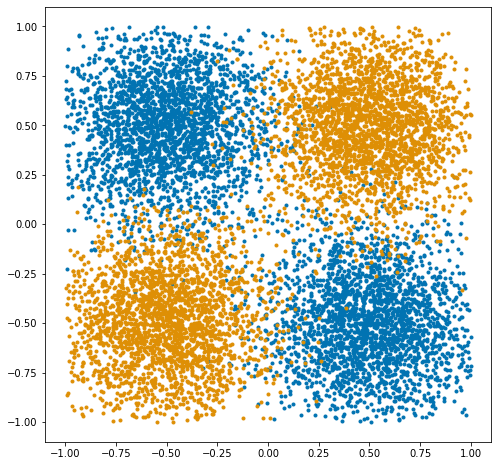

In [23]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

In [24]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [25]:
# network architecture [10, 10, 10, 10, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [26]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

2023-02-25 18:05:21.107450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping


### Calculate posteriors and likelihoods using KDN

In [27]:
df = {}
model_kdn = kdn(k=.1, network=nn)
model_kdn.fit(X, y, epsilon=1e-4)

#define grids
p = np.arange(-3, 3, step=0.01)
q = np.arange(-3, 3, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(600,600)
posterior_kdn = posterior_kdn[:,0].reshape(600,600)
class1_likelihoods = likelihoods_kdn[:,0].reshape(600,600)
class2_likelihoods = likelihoods_kdn[:,1].reshape(600,600)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods

   85/11250 [..............................] - ETA: 20s

2023-02-25 18:14:43.521086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11250/11250 [==============================] - 20s 2ms/step


In [28]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
proba_true = 0.5*np.ones((600, 600))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[200:400, 200:400] = 1 - tmp
#df["true_proba"] = proba_true

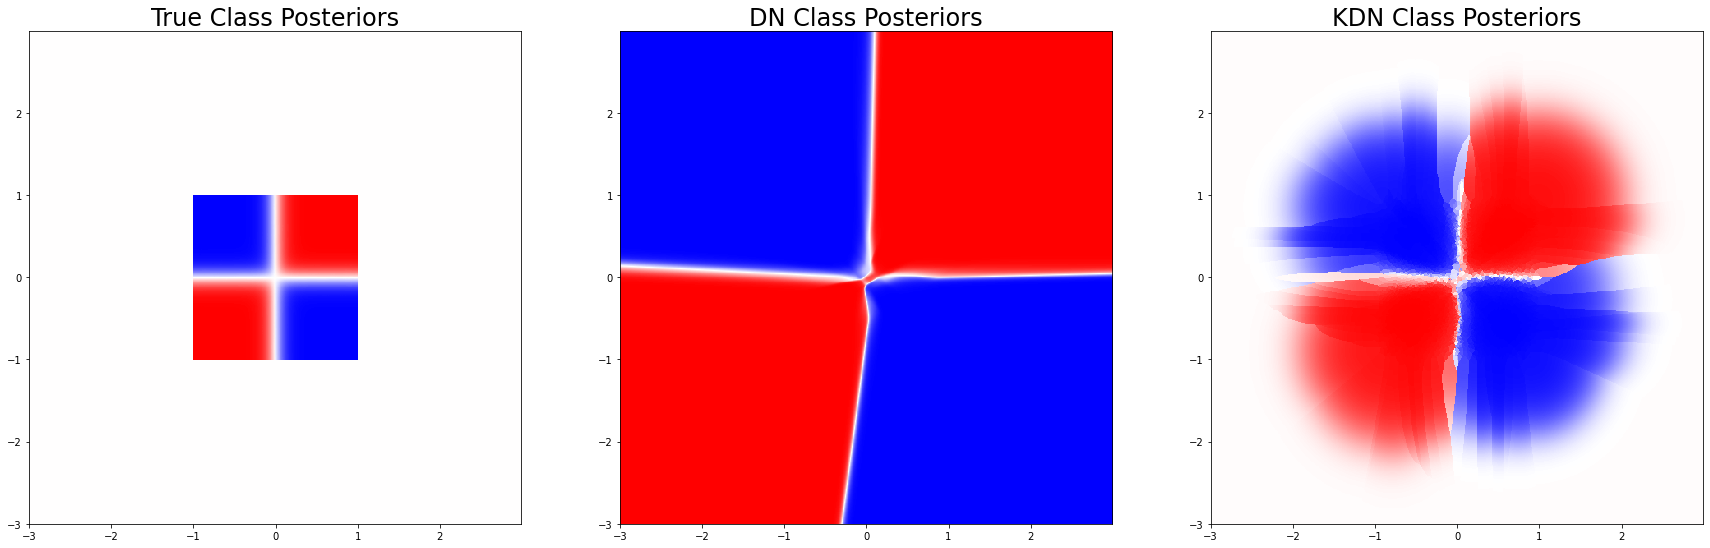

In [29]:
fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()

### Visualize class likelihoods

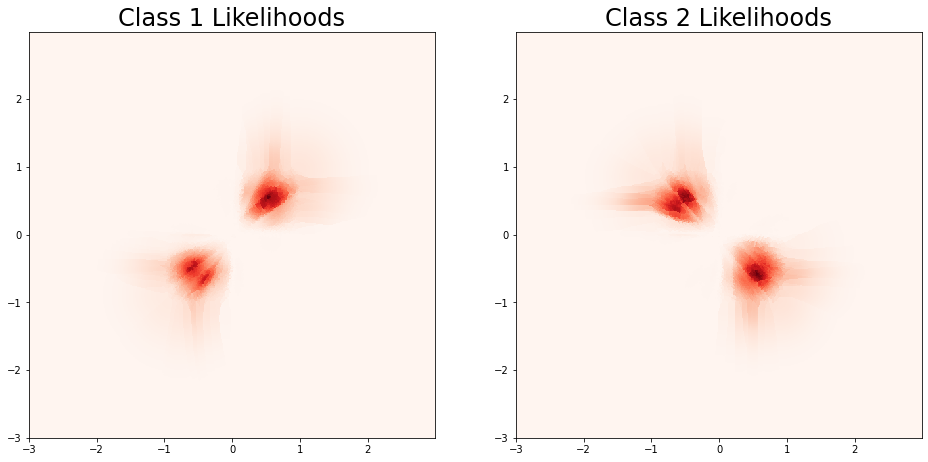

In [30]:
fig1, ax = plt.subplots(1, 2, figsize=(16, 8))

class1_likelihoods /= np.max(np.max(class1_likelihoods))
class2_likelihoods /= np.max(np.max(class2_likelihoods))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods", fontsize=24)
ax[1].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [27]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((1-true_posterior.ravel(), true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)
    
    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    error_kdn = 1 - np.mean(model_kdn.predict(X_test)==y_test)   
    error_dn = 1 - np.mean(np.argmax(
        model_kdn.network.predict(X_test), axis=1
    )==y_test)
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_dn = model_kdn.network.predict(grid_samples)
    hellinger_dis_kdn = hellinger(1-true_posterior, proba_kdn)
    hellinger_dis_dn = hellinger(1-true_posterior, proba_dn)
    mmcIn_dn = np.mean(np.max(proba_dn, axis=1)) 
    mmcIn_kdn = np.mean(np.max(proba_kdn, axis=1))
    
    return error_kdn, error_dn, hellinger_dis_kdn, hellinger_dis_dn, mmcIn_kdn, mmcIn_dn

def experiment_out(in_sample, r, n_test):
    X, y = generate_gaussian_parity(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)

    X_ood = sample_unifrom_circle(n=n_test, r=r)
    mmcOut_dn = np.mean(np.max(
        model_kdn.network.predict(X_ood), axis=1
        )
    )
    mmcOut_kdn = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
    
    return mmcOut_kdn, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []

mmcIn_kdn_med = []
mmcIn_kdn_25 = []
mmcIn_kdn_75 = []
mmcIn_dn_med = []
mmcIn_dn_25 = []
mmcIn_dn_75 = []

mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []

#### do out-of-distribution results ####
for r in np.arange(0,10.5,.5):
    mmcOut_kdn = []
    mmcOut_dn = []
    res = Parallel(n_jobs=-1)(
            delayed(experiment_out)(
                    1000,
                    r,
                    n_test
                    ) for _ in range(mc_reps)
                )
    
    for ii in range(mc_reps):
        mmcOut_kdn.append(res[ii][0])
        mmcOut_dn.append(res[ii][1])
    
    
    mmcOut_kdn_med.append(
        np.median(mmcOut_kdn)
    )
    mmcOut_kdn_25.append(
        np.quantile(mmcOut_kdn, [0.25])[0]
    )
    mmcOut_kdn_75.append(
        np.quantile(mmcOut_kdn, [0.75])[0]
    )
    
    mmcOut_dn_med.append(
        np.median(mmcOut_dn)
    )
    mmcOut_dn_25.append(
        np.quantile(mmcOut_dn, [0.25])[0]
    )
    mmcOut_dn_75.append(
        np.quantile(mmcOut_dn, [0.75])[0]
    )
    
    
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=-1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdn = []
    err_dn = []
    hellinger_kdn = []
    hellinger_dn = []
    mmcIn_kdn = []
    mmcIn_dn = []
    for ii in range(mc_reps):
        err_kdn.append(res[ii][0])
        err_dn.append(res[ii][1])
        hellinger_kdn.append(res[ii][2])
        hellinger_dn.append(res[ii][3])
        mmcIn_kdn.append(res[ii][4])
        mmcIn_dn.append(res[ii][5])

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )

    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )

    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )

    mmcIn_kdn_med.append(
        np.median(mmcIn_kdn)
    )
    mmcIn_kdn_25.append(
        np.quantile(mmcIn_kdn, [0.25])[0]
    )
    mmcIn_kdn_75.append(
        np.quantile(mmcIn_kdn, [0.75])[0]
    )

    mmcIn_dn_med.append(
        np.median(mmcIn_dn)
    )
    mmcIn_dn_25.append(
        np.quantile(mmcIn_dn, [0.25])[0]
    )
    mmcIn_dn_75.append(
        np.quantile(mmcIn_dn, [0.75])[0]
    )


df = pd.DataFrame()
df_out = pd.DataFrame()
df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcIn_kdn_med'] = mmcIn_kdn_med
df['mmcIn_kdn_25'] = mmcIn_kdn_25
df['mmcIn_kdn_75'] = mmcIn_kdn_75

df['mmcIn_dn_med'] = mmcIn_dn_med
df['mmcIn_dn_25'] = mmcIn_dn_25
df['mmcIn_dn_75'] = mmcIn_dn_75

df_out['mmcOut_kdn_med'] = mmcOut_kdn_med
df_out['mmcOut_kdn_25'] = mmcOut_kdn_25
df_out['mmcOut_kdn_75'] = mmcOut_kdn_75

df_out['mmcOut_dn_med'] = mmcOut_dn_med
df_out['mmcOut_dn_25'] = mmcOut_dn_25
df_out['mmcOut_dn_75'] = mmcOut_dn_75

INFO:tensorflow:Assets written to: ram://2918ceaf-fcd7-4a3f-9dd0-0f21cc8834a5/assets
INFO:tensorflow:Assets written to: ram://c7b0166c-d9ee-4af3-9403-a330f601a4d5/assets
INFO:tensorflow:Assets written to: ram://0aa7e5a6-91cd-44af-8932-5a3d5574e913/assets
INFO:tensorflow:Assets written to: ram://4b143da5-bd31-46c6-a7d0-6bc523e80bcd/assets
INFO:tensorflow:Assets written to: ram://7326a4f1-c666-4fb5-85c0-a543d38586f0/assets
INFO:tensorflow:Assets written to: ram://64cf72fd-5ab7-4f58-abf7-ff3dd8d14475/assets
INFO:tensorflow:Assets written to: ram://8abb4317-7fed-427b-bc7f-e250df8f7204/assets
Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max


2023-02-25 01:45:51.910295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 01:45:51.910423: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-25 01:45:51.910446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 01:45:51.910643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

INFO:tensorflow:Assets written to: ram://4babf6ae-ea49-4e69-92c7-045951a8e920/assets
Metal device set to: Apple M1 Max


2023-02-25 01:45:52.356765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 01:45:52.356901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-25 01:45:52.396074: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 01:45:52.405855: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 01:45:52.628581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:45:52.678484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_r

Metal device set to: Apple M1 Max
INFO:tensorflow:Assets written to: ram://fa2cd02c-c559-4bd2-b94b-8baeaf361c4a/assets


2023-02-25 01:45:52.917580: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 01:45:52.953485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 01:45:52.953602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-25 01:45:53.227255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Max
INFO:tensorflow:Assets written to: ram://7d5d4c72-2d54-45e9-afa4-0dbb6369f0c4/assets


2023-02-25 01:45:53.561208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 01:45:53.561347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-25 01:45:53.596427: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 01:45:53.840131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:45:54.153560: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Max


2023-02-25 01:45:54.306139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 01:45:54.306292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-25 01:45:54.480406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f126381a-df0e-4803-a4b4-851b554a49a2/assets
Metal device set to: Apple M1 Max


2023-02-25 01:45:55.015231: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 01:45:55.015386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-25 01:45:55.110477: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 01:45:55.389865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:45:55.749968: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 01:45:55.795791: I tensorflow/core/common_runtime/pluggable_device/pluggable_de

Metal device set to: Apple M1 Max


2023-02-25 01:45:56.051832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:45:56.748992: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 01:45:56.811140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 01:45:56.811294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


2023-02-25 01:45:57.090036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:45:57.922128: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 01:45:58.060645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 01:45:58.060801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


2023-02-25 01:45:58.284293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:45:59.403121: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 01:45:59.782844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
Epoch 40: early stopping
Epoch 46: early stopping
Epoch 29: early stopping
Epoch 43: early stopping
Epoch 62: early stopping


2023-02-25 01:46:11.085583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:46:11.221446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 01:46:11.700923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://a0fa1214-6048-4b73-a7e8-8eb610ae2eb9/assets


2023-02-25 01:46:12.368252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:46:12.679268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://27379b2b-67f0-48b1-9edb-483bda971037/assets


2023-02-25 01:46:13.253651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a8ff15ed-e9c4-4f9a-931e-3295e51a6031/assets


2023-02-25 01:46:14.153760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 106: early stopping
INFO:tensorflow:Assets written to: ram://8714fb12-aa4c-4ed9-9168-73736b15a3c2/assets


2023-02-25 01:46:15.187209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 102: early stopping


2023-02-25 01:46:17.595544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0sINFO:tensorflow:Assets written to: ram://7192e005-ff29-4401-a1a6-a68a9399c084/assets


2023-02-25 01:46:18.780797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/32 [===========================>..] - ETA: 0s

2023-02-25 01:46:19.032909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://fdd64f7f-9ab9-4957-a067-349e40d048cd/assets


2023-02-25 01:46:20.399460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:46:21.920134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
INFO:tensorflow:Assets written to: ram://462ebc49-b621-4640-bc8c-bd49399ca11e/assets


2023-02-25 01:46:23.800981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
 1/32 [..............................] - ETA: 3s

2023-02-25 01:46:25.567055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://11a5813f-92cd-4c4e-ba53-bb38cde17567/assets
Epoch 171: early stopping


2023-02-25 01:46:26.950894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 01:46:27.282336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping
INFO:tensorflow:Assets written to: ram://9372b44d-8eb2-4349-a7fa-90acfe59222c/assets


2023-02-25 01:46:28.891660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 106: early stopping
Epoch 54: early stopping
Epoch 49: early stopping
14/32 [============>.................] - ETA: 0s

2023-02-25 01:46:37.127218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 121: early stopping


2023-02-25 01:46:37.862998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://32f0177b-f771-4adf-bd58-54519594b5aa/assets


2023-02-25 01:46:38.403957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:46:38.726449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:46:39.332947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7be6cd10-bfd4-46b5-b109-16edbe571fff/assets
INFO:tensorflow:Assets written to: ram://5ad700d2-8a71-406f-a810-b45892719fc9/assets


2023-02-25 01:46:40.427508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 135: early stopping


2023-02-25 01:46:43.300611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 5/32 [===>..........................] - ETA: 0s

2023-02-25 01:46:43.636211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://ccebf770-fccc-4297-8800-4b72ad7fc870/assets


2023-02-25 01:46:44.780944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://94982a74-415c-47ce-8cea-1325a6fc0ac4/assets
Epoch 176: early stopping


2023-02-25 01:46:45.789443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
Epoch 40: early stopping
 8/32 [======>.......................] - ETA: 0s

2023-02-25 01:46:46.535507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:46:46.982782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://9f42b8fd-949e-4577-8040-8a0427054fa1/assets


2023-02-25 01:46:47.766837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 98: early stopping
INFO:tensorflow:Assets written to: ram://5b09c0f5-9431-441d-b921-df545f858f0d/assets


2023-02-25 01:46:48.778821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:46:52.018099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 21: early stopping
Epoch 72: early stopping
INFO:tensorflow:Assets written to: ram://199b8540-8265-4493-8534-d1015b62eeb9/assets


2023-02-25 01:46:53.783787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:46:55.389804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 01:46:55.630105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:46:55.732214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://ac842836-0357-484d-a363-dad245b269f6/assets


2023-02-25 01:46:56.454227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:46:57.061710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:46:57.270892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
Epoch 58: early stopping
INFO:tensorflow:Assets written to: ram://ac3c5b66-fff7-4edd-be38-ac5e97e97ba9/assets


2023-02-25 01:46:58.909421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 72: early stopping
INFO:tensorflow:Assets written to: ram://741c69ca-d19b-4e73-ab9f-b1fedea75421/assets
INFO:tensorflow:Assets written to: ram://43eff72c-435d-4c5c-a5fa-a4e868534ae3/assets


2023-02-25 01:47:00.050003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:47:02.483003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/32 [================>.............] - ETA: 0s

2023-02-25 01:47:02.713632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
INFO:tensorflow:Assets written to: ram://0c48870b-596c-469d-b24d-2d6e2e2ef035/assets


2023-02-25 01:47:04.038675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6a5d35ac-9b41-4be6-afa5-2db050a12192/assets


2023-02-25 01:47:04.883367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
Epoch 45: early stopping


2023-02-25 01:47:07.935368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 102: early stopping
32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://3df06aa1-8911-454d-8bc0-c98a065bc88b/assets


2023-02-25 01:47:09.675491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:47:09.831444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://56f4f80e-9a54-4587-8b6b-ceb4bc20679d/assets


2023-02-25 01:47:11.343489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 105: early stopping


2023-02-25 01:47:16.144496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
INFO:tensorflow:Assets written to: ram://19466eb1-40e6-4d9c-a3f6-887d57e43b3a/assets
Epoch 109: early stopping


2023-02-25 01:47:17.984912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:47:18.263142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:47:18.335384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 01:47:19.643917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://82dda4d4-f5d5-44d1-a3e9-6845447b5598/assets
Epoch 45: early stopping
INFO:tensorflow:Assets written to: ram://3217edae-01ce-4292-8916-0fabd28a6e52/assets


2023-02-25 01:47:21.034632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 94: early stopping
Epoch 120: early stopping


2023-02-25 01:47:25.148595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://5ae376d5-c044-4ee6-b53e-e8c44f45ffcd/assets


2023-02-25 01:47:26.523984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:47:27.970698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 01:47:28.733757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://0e3f2088-79ae-4822-950d-65c1afe6408e/assets


2023-02-25 01:47:29.473339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
28/32 [=========================>....] - ETA: 0s

2023-02-25 01:47:30.161359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: ram://ac15b2c5-a484-4227-9cd3-0483a084c378/assets


2023-02-25 01:47:30.412646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://74a2640a-00e8-4d94-82f0-d6b17d797183/assets


2023-02-25 01:47:31.504022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:47:32.715509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 01:47:34.032292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/32 [===========================>..] - ETA: 0s

2023-02-25 01:47:34.391134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step


2023-02-25 01:47:35.848614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a70b76e1-1a62-4172-acf9-08f332d8f8a3/assets
Epoch 42: early stopping
Epoch 109: early stopping
 1/32 [..............................] - ETA: 3s

2023-02-25 01:47:40.647268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Epoch 51: early stopping


2023-02-25 01:47:42.128169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:47:42.192226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 92: early stopping


2023-02-25 01:47:48.124273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 01:47:49.382640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 01:47:50.203150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 01:47:52.240655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 75: early stopping


2023-02-25 01:47:55.623947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:47:56.588861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 133: early stopping


2023-02-25 01:48:00.688525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 200: early stopping


2023-02-25 01:48:04.261061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:48:09.459302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f2c79c55-1656-4d63-8c86-dda891faf894/assets


2023-02-25 01:48:10.667200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2b32b756-5299-4006-96df-6db168e0dce1/assets
INFO:tensorflow:Assets written to: ram://29627cd3-d604-403d-b635-083a52de9498/assets


2023-02-25 01:48:11.371928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6c85c8d5-6177-4749-a490-ac81b1666885/assets


2023-02-25 01:48:11.923472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4531b7e1-bdb1-4d0d-81e1-f3e8d57a9e99/assets


2023-02-25 01:48:12.510496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://47467a79-6fa8-469e-9dab-f3b2ac45eb20/assets


2023-02-25 01:48:13.056446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f5c8bf2a-4e30-48d1-b6bc-bc54336936d0/assets


2023-02-25 01:48:13.679485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://161cd799-08dc-44f8-beb8-78964a561597/assets


2023-02-25 01:48:14.443322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 17: early stopping


2023-02-25 01:48:15.297330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://be0acfb2-89da-41f2-a8d5-6841d45fc507/assets
INFO:tensorflow:Assets written to: ram://b5ce20db-8b4e-442f-8daf-6dec143fa8db/assets


2023-02-25 01:48:16.350386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping


2023-02-25 01:48:17.540550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://26695874-5e1e-4fd7-851a-3ebb2d240c53/assets
Epoch 19: early stopping
Epoch 57: early stopping
Epoch 67: early stopping
12/32 [==========>...................] - ETA: 0s

2023-02-25 01:48:25.570049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://e318419d-5b7e-45f0-a35a-6824e12209fe/assets


2023-02-25 01:48:27.011688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:48:27.977227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://d587ea8b-2a3a-486c-9cf0-e331d31596dd/assets


2023-02-25 01:48:29.705040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:48:30.362093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 77: early stopping
32/32 [==============================] - 1s 16ms/step
INFO:tensorflow:Assets written to: ram://999e7f66-538b-4deb-87f8-5ad3b308cda2/assets


2023-02-25 01:48:32.240980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
Epoch 132: early stopping


2023-02-25 01:48:37.080301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:48:37.215074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 100: early stopping
32/32 [==============================] - 0s 9ms/step
Epoch 25: early stopping
INFO:tensorflow:Assets written to: ram://6716066d-ebe9-4866-8be2-2f5a94778261/assets


2023-02-25 01:48:38.336423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:48:39.261303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a5eae29b-4c4f-4b6c-99c7-6dc6d3b7f1ef/assets
Epoch 132: early stopping


2023-02-25 01:48:41.736741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://69700b3b-409e-4245-8366-4ad14aee6cf8/assets


2023-02-25 01:48:43.174094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:48:44.640909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 01:48:45.318687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://a64ac284-e2e3-40d1-8dcc-35238f059629/assets


2023-02-25 01:48:46.250052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 94: early stopping
12/32 [==========>...................] - ETA: 0s

2023-02-25 01:48:47.283784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:48:47.300058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 01:48:48.848785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 01:48:49.189501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://11eeeb6c-e853-44e9-97d7-e76221b7022b/assets


2023-02-25 01:48:50.166602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/32 [========================>.....] - ETA: 0s

2023-02-25 01:48:50.540566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
INFO:tensorflow:Assets written to: ram://07734477-e2dd-4b00-bc0a-d1576ccec4b1/assets


2023-02-25 01:48:52.185772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping
INFO:tensorflow:Assets written to: ram://70553672-3717-40fa-9cc7-f92e45c51a54/assets
Epoch 43: early stopping
Epoch 133: early stopping
Epoch 95: early stopping
Epoch 25: early stopping


2023-02-25 01:48:58.779514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://e3ec8833-9f67-4e5f-b8e8-75c754906e3b/assets


2023-02-25 01:49:00.168490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:00.512061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 78: early stopping
INFO:tensorflow:Assets written to: ram://302f4742-a1e0-48e1-af47-1465337bc6d6/assets


2023-02-25 01:49:01.798081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:02.790955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://48c3ff7f-91a2-4f75-a449-8bc4598b571b/assets


2023-02-25 01:49:04.036480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:05.369483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:49:06.355315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://e11d4581-1ae6-4f61-a9c4-0a3fe3cb5e18/assets


2023-02-25 01:49:06.657404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://6493864d-6fb7-4d21-8264-4dee0460091b/assets


2023-02-25 01:49:07.736073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:07.772472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 01:49:08.316391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Epoch 90: early stopping
INFO:tensorflow:Assets written to: ram://b73e3613-d14e-4ee3-8740-8d5138dd0811/assets


2023-02-25 01:49:09.312737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:10.264970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:10.575392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3sINFO:tensorflow:Assets written to: ram://f8a55e53-7936-464e-9280-f5c9c9c471bd/assets


2023-02-25 01:49:11.134888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 01:49:12.161529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9b241d83-7220-4a7b-a76f-b733bb8f05de/assets


2023-02-25 01:49:13.514180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://12b9b25c-f927-4782-a29f-11da4b7dbfed/assets
Epoch 37: early stopping
Epoch 56: early stopping


2023-02-25 01:49:20.973314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/32 [========================>.....] - ETA: 0s

2023-02-25 01:49:21.225460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://69586b4d-4b58-4c9b-801d-d7709aebbe64/assets


2023-02-25 01:49:22.423035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:23.384058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://957d05b1-ebb1-47f1-9fd7-fe346933c621/assets


2023-02-25 01:49:27.369046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 23ms/step
Epoch 122: early stopping
Epoch 91: early stopping
INFO:tensorflow:Assets written to: ram://73600399-e254-4290-8979-998e50b0f890/assets


2023-02-25 01:49:29.337276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:30.422150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://48cf3a17-e0cd-4a7b-b537-c475ee62f424/assets


2023-02-25 01:49:32.012210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 91: early stopping


2023-02-25 01:49:33.134901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 51: early stopping
Epoch 47: early stopping
INFO:tensorflow:Assets written to: ram://01774665-93b7-4309-ab3a-099c58950dea/assets


2023-02-25 01:49:34.693677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping
Epoch 127: early stopping


2023-02-25 01:49:38.494048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:49:39.399641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:39.579351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:49:39.747056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:40.644811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://54b24b3a-9d58-4aed-9c71-8abd512012ca/assets
INFO:tensorflow:Assets written to: ram://eb39ce9e-1b2e-4c1a-9aad-3a8ad45cd00f/assets


2023-02-25 01:49:41.871423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:42.473154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://ef3f8f31-9f85-4747-9c4a-e57096048592/assets


2023-02-25 01:49:43.909902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:43.932269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 01:49:44.177853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://ac11b19d-b0d7-426e-a214-84621e4c764f/assets


2023-02-25 01:49:45.674257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:46.599324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5735310b-5360-48fc-a836-37082b07d411/assets
Epoch 69: early stopping
 1/32 [..............................] - ETA: 4s

2023-02-25 01:49:47.333715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
Epoch 60: early stopping
 4/32 [==>...........................] - ETA: 0s

2023-02-25 01:49:48.022242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
INFO:tensorflow:Assets written to: ram://012d5f29-fbe2-442f-8194-5f1a61b701d4/assets


2023-02-25 01:49:49.387236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:49:50.601956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9a8befdb-c9a6-41d3-9254-3e9d480a3ff8/assets
Epoch 51: early stopping


2023-02-25 01:50:00.429015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step
Epoch 47: early stopping
 5/32 [===>..........................] - ETA: 0s

2023-02-25 01:50:01.233556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
INFO:tensorflow:Assets written to: ram://86a0680c-a060-4930-8209-1201466a678d/assets


2023-02-25 01:50:02.333575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 106: early stopping


2023-02-25 01:50:03.364893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 78: early stopping
Epoch 61: early stopping
Epoch 116: early stopping


2023-02-25 01:50:10.043553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
32/32 [==============================] - 0s 6ms/step


2023-02-25 01:50:11.581324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 01:50:12.553338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 134: early stopping
32/32 [==============================] - 0s 4ms/step


2023-02-25 01:50:13.411977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:50:14.452991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 67: early stopping


2023-02-25 01:50:15.604673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:50:17.402110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 189: early stopping


2023-02-25 01:50:19.875230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:50:21.622941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:50:23.941211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a3180a2d-70d7-49e9-9749-059c170db380/assets


2023-02-25 01:50:25.188190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9ab3c9fc-888b-488c-81e7-ad99296aa685/assets
INFO:tensorflow:Assets written to: ram://1445f405-b7d6-4acf-8026-1416a9c45380/assets


2023-02-25 01:50:25.902685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://973647f3-256b-4ac7-9763-85fc6b011880/assets


2023-02-25 01:50:26.451952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://88b2a7b4-8513-46a4-80d7-062472f3ec58/assets


2023-02-25 01:50:27.052140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3254a408-95ef-433a-9a97-15fe112c4dc2/assets


2023-02-25 01:50:27.652318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ab746d1e-6f07-4b7d-91d5-b032875a9bc7/assets


2023-02-25 01:50:28.288487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://83d45ae4-ebbe-4934-a3ba-2fa9630ebb05/assets


2023-02-25 01:50:28.946384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9aa03cfd-dc23-4d36-9076-84e3dc23ca5c/assets


2023-02-25 01:50:29.787656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:50:31.254261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://eb0a7716-c320-4107-99bd-3a1e6679ddc1/assets


2023-02-25 01:50:33.676121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d4c101a4-8bc2-4981-8a70-3d957f23a65b/assets
Epoch 56: early stopping
Epoch 57: early stopping
Epoch 27: early stopping
Epoch 50: early stopping
Epoch 43: early stopping
Epoch 38: early stopping
Epoch 73: early stopping
Epoch 64: early stopping


2023-02-25 01:50:47.013918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 01:50:47.993624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: ram://204ff131-b1d9-4303-bc2a-eb32b1a31a50/assets


2023-02-25 01:50:48.263836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:50:48.307833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:50:48.385915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 01:50:48.496484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:50:48.607316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:50:48.611226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://3662f873-a219-485c-8946-2b2e84d3cc69/assets


2023-02-25 01:50:49.008951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:50:49.207135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 59: early stopping
INFO:tensorflow:Assets written to: ram://b557b616-c4d3-40f7-ac97-e1abc89d2248/assets


2023-02-25 01:50:49.726235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8741bbd4-c1ce-4eeb-a470-6f1c253ac7a7/assets


2023-02-25 01:50:50.378853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1ad73136-8cbd-4337-8b8a-70a11e30ede1/assets


2023-02-25 01:50:51.050237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://21cae50d-dfed-4902-ab5f-2c1d20f791eb/assets


2023-02-25 01:50:51.841493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:50:52.727183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d9a69686-07f7-46dd-96cb-16a69c3e2415/assets


2023-02-25 01:50:54.065767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4003e862-255d-43e0-aa8f-a448c7023015/assets
Epoch 23: early stopping
Epoch 40: early stopping


2023-02-25 01:50:58.973622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 01:50:59.450212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 01:51:00.536629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://942933f5-2200-4f5f-b930-2fa1dae467f1/assets


2023-02-25 01:51:02.327624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2f762da6-e43d-4c93-b6cd-64533e61bf5f/assets
Epoch 65: early stopping
Epoch 79: early stopping


2023-02-25 01:51:06.877282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 01:51:07.308249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://24abfb54-5465-4944-9111-24d3c67967b9/assets


2023-02-25 01:51:08.546738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://80d8dcd9-3f3e-4b4c-a20e-e14e8c73b540/assets


2023-02-25 01:51:09.647017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
Epoch 47: early stopping
Epoch 90: early stopping
 1/32 [..............................] - ETA: 2s

2023-02-25 01:51:13.572775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 101: early stopping
INFO:tensorflow:Assets written to: ram://a4131161-96d7-4185-b2a7-ad6ee3b32807/assets


2023-02-25 01:51:14.843667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:51:16.008448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://073bac5c-6c5e-4203-8b05-a05cba93c871/assets


2023-02-25 01:51:17.258668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:51:17.905251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 01:51:19.242270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://706cbb22-1d99-4ff0-986b-681c21479935/assets


2023-02-25 01:51:20.100097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 54: early stopping


2023-02-25 01:51:21.137294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 01:51:21.401867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f6a950f9-51de-449d-b1f5-f3d98bba11af/assets
INFO:tensorflow:Assets written to: ram://44f2c646-c0a6-4f78-9903-6b74b6d1ad98/assets


2023-02-25 01:51:22.614483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:51:23.587907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 01:51:25.201545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:51:25.221986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://9dac699a-dbbc-4698-b36e-559e2c1d5d70/assets


2023-02-25 01:51:26.950960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6f3352e4-e3b4-4528-a775-33e3cfd0cb0c/assets
Epoch 50: early stopping
Epoch 91: early stopping


2023-02-25 01:51:29.376744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://629ef839-f864-4bf7-8b78-530e28c0f246/assets


2023-02-25 01:51:30.633051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:51:32.076040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
INFO:tensorflow:Assets written to: ram://3954b065-0463-48d7-9842-76a1f45d85c4/assets


2023-02-25 01:51:33.729795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping


2023-02-25 01:51:36.544938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
INFO:tensorflow:Assets written to: ram://a1c13708-ec81-47b3-8052-5d019968cebc/assets


2023-02-25 01:51:38.369126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:51:38.974088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step


2023-02-25 01:51:39.964721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 01:51:40.845005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f58b5d71-1014-4fe0-ad41-9787bddb99ae/assets


2023-02-25 01:51:42.686732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d5a64c61-4f49-41aa-9376-b85d908d8da0/assets
Epoch 86: early stopping
Epoch 66: early stopping


2023-02-25 01:51:47.334482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 67: early stopping
Epoch 47: early stopping
Epoch 123: early stopping
INFO:tensorflow:Assets written to: ram://bbd1e0df-3ad3-4e32-95b9-65f3d8315516/assets


2023-02-25 01:51:48.872353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping


2023-02-25 01:51:53.062727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://fd49b8f7-8b30-4c57-9224-49df5d9a974e/assets


2023-02-25 01:51:54.248957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 136: early stopping


2023-02-25 01:51:57.459732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:51:57.646772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 01:51:58.580855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
INFO:tensorflow:Assets written to: ram://d1cd29b7-c267-466d-864a-e7c9cb0d2098/assets


2023-02-25 01:51:59.472941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:51:59.649117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://b41fe67f-7fb2-49fd-8d0d-382fddeb5045/assets
22/32 [===================>..........] - ETA: 0s

2023-02-25 01:52:00.029380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 89: early stopping
INFO:tensorflow:Assets written to: ram://7b2fb93c-e3d4-4891-972c-c89eb07c0485/assets


2023-02-25 01:52:00.791170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f690dd82-cb5b-4197-a18e-514e099e3f94/assets


2023-02-25 01:52:01.820336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:52:04.277672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 56: early stopping
INFO:tensorflow:Assets written to: ram://ec258e27-7d8f-44ad-8aa3-83d7ac4f5705/assets


2023-02-25 01:52:05.993262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping


2023-02-25 01:52:08.539903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 01:52:08.929077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:52:08.935987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://66133f45-b4c6-4829-9b92-802a7c35d7b6/assets
10/32 [========>.....................] - ETA: 0s

2023-02-25 01:52:10.057051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:52:10.118977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://c91dcd2f-176f-41fc-ab69-7355453d53fc/assets


2023-02-25 01:52:10.740218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:52:11.735367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5a7ee3f6-87e6-40ea-8405-32b9dd9e2620/assets


2023-02-25 01:52:12.915478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 61: early stopping


2023-02-25 01:52:15.675754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 22ms/step
Epoch 30: early stopping
Epoch 90: early stopping


2023-02-25 01:52:17.782459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:52:23.191399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 01:52:25.917975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 73: early stopping
12/32 [==========>...................] - ETA: 0s

2023-02-25 01:52:26.266682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 118: early stopping
Epoch 114: early stopping


2023-02-25 01:52:33.300125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:52:34.364239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:52:37.683359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 185: early stopping


2023-02-25 01:52:41.229680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:52:44.775587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://5448f596-1528-4960-b5ef-317a8c7afa90/assets


2023-02-25 01:52:46.015697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9912d753-434d-44e0-b978-a85d9d659a90/assets
INFO:tensorflow:Assets written to: ram://ef260c71-44b5-4000-980f-22e9f2d004f3/assets


2023-02-25 01:52:46.733173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0c60cb1d-1e4c-46bd-b065-6f5cf1a55ae4/assets


2023-02-25 01:52:47.270793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cb09298e-24eb-4579-b85c-ee285c4a972f/assets


2023-02-25 01:52:47.855889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fec26ea4-e956-473a-9123-08027c14072a/assets


2023-02-25 01:52:48.463603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://214fe701-021c-4485-a72b-44f6070902b8/assets


2023-02-25 01:52:49.077520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c030b020-0a09-4d75-a2c8-76dbe07c6adb/assets


2023-02-25 01:52:49.818945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:52:50.703912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://89a8207c-a139-443c-ad5f-cfad43e9f210/assets


2023-02-25 01:52:52.274931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bf40b8ef-aa5f-4ebb-bd89-fb882a30c643/assets


2023-02-25 01:52:54.873388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
INFO:tensorflow:Assets written to: ram://6150c8c3-0374-4b21-812e-c3b6c78827a0/assets
Epoch 42: early stopping
Epoch 68: early stopping
Epoch 66: early stopping
Epoch 54: early stopping
Epoch 78: early stopping


2023-02-25 01:53:06.893810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:07.055844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://6b87231f-f244-4821-a465-6e9205edba87/assets


2023-02-25 01:53:08.198943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 89: early stopping
INFO:tensorflow:Assets written to: ram://0f360a70-dd13-4ca1-80b3-63ea8ba8cdb2/assets


2023-02-25 01:53:09.045900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:09.065406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://ff21b4d0-11ca-4e94-8360-bee9b146ba09/assets


2023-02-25 01:53:10.812901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:12.627838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step
Epoch 109: early stopping
INFO:tensorflow:Assets written to: ram://e0b3003a-b78b-4e24-a800-118f254fed97/assets


2023-02-25 01:53:14.159919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:15.374022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://f43c1994-046a-403d-8b75-a993f0059464/assets


2023-02-25 01:53:16.868980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping


2023-02-25 01:53:18.084621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 01:53:18.707269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 01:53:19.578076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:19.749926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 01:53:20.856342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f3e6029f-b624-43c3-9d6b-6a064adcbcf5/assets


2023-02-25 01:53:22.122969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 69: early stopping
Epoch 144: early stopping
INFO:tensorflow:Assets written to: ram://87f86df0-d1a2-417c-ba6c-c00bcd4514b7/assets


2023-02-25 01:53:25.062438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 01:53:26.719081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://dd21c47d-4d08-4edf-9e6d-a1d5abeaeab0/assets
Epoch 51: early stopping


2023-02-25 01:53:28.798758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Epoch 32: early stopping
Epoch 71: early stopping
INFO:tensorflow:Assets written to: ram://eea29932-5220-4e2d-8077-e6a0f1d1a107/assets


2023-02-25 01:53:30.560605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:33.113524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:33.278928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://61ee1764-4aa3-4a0b-ad44-d405500928f1/assets


2023-02-25 01:53:34.699369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:35.703167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e63643f9-3f0f-4370-a22b-8cd1050c8cb0/assets
Epoch 70: early stopping
Epoch 82: early stopping
Epoch 49: early stopping


2023-02-25 01:53:37.573532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 38: early stopping
20/32 [=================>............] - ETA: 0sINFO:tensorflow:Assets written to: ram://8654b162-f51c-4662-8485-5944ab3bf327/assets


2023-02-25 01:53:39.203148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:39.310962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 01:53:40.181072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://c03d6f00-8aa9-424c-b837-0a0451e8b2db/assets


2023-02-25 01:53:40.563246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:41.468876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ac03746b-7ea8-478f-95df-1445ec29c9eb/assets


2023-02-25 01:53:45.223042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 01:53:46.444053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://8cb7c7a0-87b3-465b-8470-1a6b823e1335/assets


2023-02-25 01:53:46.864846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:46.914429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 62: early stopping
INFO:tensorflow:Assets written to: ram://38ad1b29-259b-4b96-8b7d-f86f3580beb2/assets


2023-02-25 01:53:48.075485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:48.755639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:49.133307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Epoch 42: early stopping


2023-02-25 01:53:49.493942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://f11146d7-c93c-433d-bffa-b9b1d5df52a4/assets
Epoch 192: early stopping
INFO:tensorflow:Assets written to: ram://b3b6cf07-baba-4cc3-89da-e14a1884facc/assets


2023-02-25 01:53:50.732702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping


2023-02-25 01:53:51.776925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ad2c34ca-c0b9-4ec2-a9f5-9a150898e38c/assets
Epoch 24: early stopping


2023-02-25 01:53:58.373653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://060baca8-ea3b-4a02-8245-2fe1933b53dd/assets


2023-02-25 01:53:59.768793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:53:59.797570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 01:54:00.453411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://e7e322a7-26ad-4131-9fca-86b477ead4ac/assets


2023-02-25 01:54:01.416857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:02.494552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:02.609464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/32 [===========================>..] - ETA: 0s

2023-02-25 01:54:02.943399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://3a504a28-3769-43a2-9f75-fe895f0a73c5/assets


2023-02-25 01:54:04.414420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:05.863271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d5ec4dc1-e94d-493a-8e5e-e3a26ff47331/assets
Epoch 82: early stopping
Epoch 144: early stopping
Epoch 82: early stopping
Epoch 98: early stopping
Epoch 39: early stopping


2023-02-25 01:54:11.308779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: ram://1a226197-c0c9-470a-b40c-53e0472ad44c/assets


2023-02-25 01:54:12.706669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:17.999362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 62: early stopping
 7/32 [=====>........................] - ETA: 0s

2023-02-25 01:54:18.705245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 01:54:18.908233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 01:54:19.190582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:19.347515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3d577b0c-919c-4d4d-97ab-3f390a421210/assets
Epoch 36: early stopping
11/32 [=========>....................] - ETA: 0s

2023-02-25 01:54:20.171347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:20.348369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: ram://231d75f0-4498-4f23-92ea-75a2f60fcb1f/assets
INFO:tensorflow:Assets written to: ram://f73eaf86-551b-40f0-a605-00402beefb04/assets


2023-02-25 01:54:21.155419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://963483fb-b46d-44db-8e86-8c9931707482/assets


2023-02-25 01:54:21.941828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:22.975642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f395391d-7607-42b2-b8f9-2f512241d719/assets
Epoch 38: early stopping
Epoch 45: early stopping
 1/32 [..............................] - ETA: 2s

2023-02-25 01:54:29.075903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:29.170245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:54:30.216967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 01:54:30.422058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 137: early stopping
INFO:tensorflow:Assets written to: ram://339a9a24-a79f-413b-8ddf-e3ab571b8d65/assets


2023-02-25 01:54:31.400930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fa257a63-b034-42ea-b657-466381de1ca9/assets


2023-02-25 01:54:32.433934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 62: early stopping
Epoch 131: early stopping
Epoch 31: early stopping


2023-02-25 01:54:38.936243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 01:54:39.462736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:54:40.255740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:41.149416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 95: early stopping


2023-02-25 01:54:43.037791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:43.091823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 01:54:45.681027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 84: early stopping


2023-02-25 01:54:48.527786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:54:48.705049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 103: early stopping
Epoch 73: early stopping


2023-02-25 01:54:53.424364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:54:55.527871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:54:56.921964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://61d90674-6606-4b15-bd4f-9a3797257936/assets


2023-02-25 01:54:58.200827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c2a7a5b2-9a6f-46af-8a82-73da2f1818bd/assets
INFO:tensorflow:Assets written to: ram://ab341cee-7318-4e94-bf67-ef91fe78eaf8/assets


2023-02-25 01:54:58.907942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://08c09256-f401-4225-875a-2a148e93e958/assets


2023-02-25 01:54:59.456801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://14db998b-abc5-4833-9e9e-236d4360487e/assets


2023-02-25 01:55:00.020664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d7c4ed0e-00d3-4e32-8ab0-859aac516706/assets


2023-02-25 01:55:00.612004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f376685e-906e-4130-ae70-3cba7e332ca3/assets


2023-02-25 01:55:01.227372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bbda368a-4e1b-4e03-b54c-968a1f94d2e3/assets


2023-02-25 01:55:01.965855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:55:02.819642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6ce57f1d-a497-4dc5-bf3c-8ff0d276bf51/assets


2023-02-25 01:55:04.340078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5a0d2af1-43f5-46a9-ada6-8f45ac05524e/assets
Epoch 29: early stopping
INFO:tensorflow:Assets written to: ram://e9969d40-3752-44be-8690-df7e52c89038/assets


2023-02-25 01:55:06.268591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
Epoch 70: early stopping
Epoch 79: early stopping
Epoch 56: early stopping


2023-02-25 01:55:18.203306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 90: early stopping
Epoch 75: early stopping
Epoch 60: early stopping


2023-02-25 01:55:19.832283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c1ade1ee-315c-4a2d-83d9-b5eb6d8822ae/assets


2023-02-25 01:55:21.293029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://c0bfada2-5baa-43c0-9de1-375f4524957f/assets


2023-02-25 01:55:22.536636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:55:23.149349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 01:55:23.562550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://26c2c8aa-18d6-469a-9220-470bb23ecf0a/assets


2023-02-25 01:55:24.366004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:55:25.336726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a20db785-c3bc-42b7-8716-66f7bb251ebd/assets


2023-02-25 01:55:26.480988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://2bdf6e40-708b-4bbc-8c0d-d63c2537e083/assets


2023-02-25 01:55:28.102063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:55:28.607194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:55:28.775117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:55:28.787317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: ram://6a71fe1a-1d09-414a-89f7-beb6008282a0/assets


2023-02-25 01:55:29.937568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:55:30.539456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://76f13ba6-e910-4d23-9e09-87e468c416d4/assets


2023-02-25 01:55:30.897365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping


2023-02-25 01:55:31.896468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://be720821-87d9-4054-b75d-60e731213fd7/assets
Epoch 40: early stopping
Epoch 40: early stopping


2023-02-25 01:55:33.395838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b7dc02ad-a539-486f-9b73-d28e63522ba8/assets
Epoch 35: early stopping
Epoch 50: early stopping


2023-02-25 01:55:41.155367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:55:42.471348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:55:42.587387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://4b75e1d7-a3e8-411f-a530-437a8c4fa9d2/assets


2023-02-25 01:55:43.329674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://fcf1245a-a1f1-400a-ac77-542aad1bfca5/assets


2023-02-25 01:55:43.953453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0s

2023-02-25 01:55:44.161023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://f877b90a-40a6-40e3-8582-ec749e5b11ed/assets


2023-02-25 01:55:45.085522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:55:46.101316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://7136c4d2-bb58-42e8-afe2-fc81fe858d4e/assets


2023-02-25 01:55:46.306736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://1680b9fa-f42b-442a-a38c-8c44b4c052d1/assets


2023-02-25 01:55:47.761390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 90: early stopping


2023-02-25 01:55:51.828033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://82ec019b-2685-48fd-8a9f-969e250e1b3d/assets


2023-02-25 01:55:53.372797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping


2023-02-25 01:55:54.195449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 01:55:54.501425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 01:55:55.768818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d3c30b03-d4fd-43b4-818b-13f862526c75/assets
Epoch 167: early stopping


2023-02-25 01:55:56.930672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2889da0f-d6a6-491f-a9bf-40e892ea8161/assets


2023-02-25 01:56:00.026273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
Epoch 79: early stopping
INFO:tensorflow:Assets written to: ram://269bbd0f-0340-4ed6-a8ef-26bc8f3c7361/assets


2023-02-25 01:56:01.862884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
Epoch 82: early stopping


2023-02-25 01:56:04.681547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 01:56:06.069712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ac6c824d-7567-412f-b37f-7995f0f89cd6/assets


2023-02-25 01:56:06.831606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://97d345d8-d4be-48bc-8e1e-ac619d764aad/assets


2023-02-25 01:56:08.194656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 102: early stopping


2023-02-25 01:56:11.326128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 146: early stopping
Epoch 89: early stopping
INFO:tensorflow:Assets written to: ram://5656f4c5-37ed-4a27-b686-cc229f524787/assets
 1/32 [..............................] - ETA: 3s

2023-02-25 01:56:12.871051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:56:12.925669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 55: early stopping


2023-02-25 01:56:13.717756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://576debc3-7b19-4edc-b10e-c2dcbadfeb36/assets


2023-02-25 01:56:14.356210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 86: early stopping
INFO:tensorflow:Assets written to: ram://c745da5e-7633-4d43-921f-dd2f88ab240e/assets


2023-02-25 01:56:15.325816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 60: early stopping


2023-02-25 01:56:18.826200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://ec2dff56-77a1-44d2-a4cb-ba67816be560/assets


2023-02-25 01:56:20.162833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping


2023-02-25 01:56:22.442618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/32 [=====================>........] - ETA: 0s

2023-02-25 01:56:22.697789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://07e38055-ea9f-46a6-a526-0fb30b6addc6/assets


2023-02-25 01:56:23.695102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:56:23.710676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://c5d9fe62-a568-4382-ba3d-fc8fdcf40c10/assets


2023-02-25 01:56:24.524749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:56:24.825606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 58: early stopping
INFO:tensorflow:Assets written to: ram://1ababfc3-ebec-4e99-a049-1972e082bc5e/assets


2023-02-25 01:56:25.642452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:56:26.665202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://47bba5da-090e-4a09-836e-0e49cbee4773/assets


2023-02-25 01:56:29.192554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 22: early stopping
32/32 [==============================] - 1s 17ms/step
INFO:tensorflow:Assets written to: ram://ce15a394-d20a-4f94-930b-5e8db46fbf71/assets


2023-02-25 01:56:31.012293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:56:31.709182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
Epoch 34: early stopping
INFO:tensorflow:Assets written to: ram://358b1086-af6a-4c94-b4d7-c6bbf5b154e2/assets


2023-02-25 01:56:34.101686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping


2023-02-25 01:56:36.723796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://ac7c801b-686a-4648-aa94-c1f0632a08d1/assets


2023-02-25 01:56:38.284910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping


2023-02-25 01:56:40.049056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 101: early stopping
INFO:tensorflow:Assets written to: ram://8020dfa9-9fd7-4234-912c-74089d99456c/assets


2023-02-25 01:56:41.499480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 97: early stopping
 1/32 [..............................] - ETA: 2s

2023-02-25 01:56:42.865845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/32 [===================>..........] - ETA: 0s

2023-02-25 01:56:43.224061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://3d3a2644-0570-48b0-b8cf-f35059cafe5e/assets


2023-02-25 01:56:44.340798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:56:45.224085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 158: early stopping
INFO:tensorflow:Assets written to: ram://656cac3f-2e7b-4d5a-907a-d9221567f384/assets


2023-02-25 01:56:46.667828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 01:56:48.063606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:56:49.178050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step


2023-02-25 01:56:50.585580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 01:56:52.076135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 41: early stopping


2023-02-25 01:56:54.479100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 86: early stopping
Epoch 145: early stopping


2023-02-25 01:57:00.528470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 113: early stopping
32/32 [==============================] - 0s 4ms/step


2023-02-25 01:57:02.112723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 01:57:06.452390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 01:57:07.140382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:57:07.409150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 160: early stopping


2023-02-25 01:57:16.032179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://15df0fc1-4647-4202-b601-d210213277d8/assets
INFO:tensorflow:Assets written to: ram://0332b955-edc5-4812-bbfd-beac1134848e/assets


2023-02-25 01:57:17.272138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:57:17.817168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://24245aad-93ec-4501-ab2b-c96cb25ca42c/assets
INFO:tensorflow:Assets written to: ram://e2377c27-cdd0-4b13-a3cb-b1ba42589a14/assets


2023-02-25 01:57:18.544986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://eca56e61-bed2-4367-b80a-5024a7bf3900/assets


2023-02-25 01:57:19.154975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://61ffe04f-73b9-4bb4-b773-000b5df7fd82/assets


2023-02-25 01:57:19.743273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b326c990-acb3-4b28-8de3-da87be65330b/assets


2023-02-25 01:57:20.380832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0d49cfba-652a-4fa5-b243-f7670987aabb/assets


2023-02-25 01:57:21.084256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2b16b96b-dd3c-40c3-8923-651d374e348f/assets


2023-02-25 01:57:21.981379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:57:23.238837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ea9918e6-4347-47d9-8638-8449b5e7887f/assets


2023-02-25 01:57:26.056475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://580123f8-7789-4e11-a275-be2fc30f2280/assets
Epoch 35: early stopping
Epoch 31: early stopping
Epoch 57: early stopping
Epoch 38: early stopping
Epoch 81: early stopping


2023-02-25 01:57:37.925916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:57:38.703876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://1bed3e76-6f4c-417a-a607-98f5a81df57f/assets


2023-02-25 01:57:39.305894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 100: early stopping


2023-02-25 01:57:40.120476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:57:40.244520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://cef9e510-7e0d-4a4e-9bb4-e5ebf0c3c370/assets


2023-02-25 01:57:41.090959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: ram://62e5037a-0fd0-4d3f-a076-6218306ff6ac/assets


2023-02-25 01:57:41.947058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:57:43.062845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://58902d26-3917-4b85-a6a1-71dc3198cefc/assets


2023-02-25 01:57:44.224448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step


2023-02-25 01:57:46.847184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
INFO:tensorflow:Assets written to: ram://6a38a079-602e-404e-bbbe-bb49fa3f80b5/assets
Epoch 44: early stopping


2023-02-25 01:57:49.128716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://8a4e90e9-10bf-4f88-a536-41f97d42bc8a/assets


2023-02-25 01:57:50.801365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:57:50.814109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
Epoch 172: early stopping
INFO:tensorflow:Assets written to: ram://53454283-1e49-4b26-8126-9cdd7683c995/assets


2023-02-25 01:57:52.857598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 142: early stopping
Epoch 37: early stopping
Epoch 66: early stopping
Epoch 142: early stopping


2023-02-25 01:57:58.301639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping
32/32 [==============================] - 0s 9ms/step


2023-02-25 01:57:59.397633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:57:59.575223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://ba0d3871-9ca5-474b-8839-8a6508559247/assets


2023-02-25 01:58:00.766303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:58:02.231313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 01:58:03.442395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/32 [============>.................] - ETA: 0sINFO:tensorflow:Assets written to: ram://6995d3ac-0022-406f-b036-100c2ecf1e34/assets


2023-02-25 01:58:03.656907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 98: early stopping


2023-02-25 01:58:04.874991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6c5bc557-a252-4f8f-95c6-f907855c813d/assets


2023-02-25 01:58:05.595066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/32 [==================>...........] - ETA: 0s

2023-02-25 01:58:05.820301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://cc185a55-2bd4-4f00-b73a-01729932c1b6/assets


2023-02-25 01:58:06.877911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:58:07.054772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 01:58:07.906088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://41fb68f9-5cca-486e-b68e-da08855bb297/assets


2023-02-25 01:58:08.834971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/32 [=========================>....] - ETA: 0s

2023-02-25 01:58:09.236320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
INFO:tensorflow:Assets written to: ram://94458cc3-9baa-41ba-a09d-304ed598ef8c/assets


2023-02-25 01:58:10.896815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://71cffb80-164c-4258-b556-51bd07cd030d/assets


2023-02-25 01:58:16.515930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 47: early stopping


2023-02-25 01:58:18.423261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1b660a68-7a28-48f8-9c41-37d7504e0f51/assets
Epoch 124: early stopping
Epoch 57: early stopping


2023-02-25 01:58:21.882229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 51: early stopping
INFO:tensorflow:Assets written to: ram://70a76107-385c-4a92-bc9e-232197a4df24/assets


2023-02-25 01:58:23.313160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 133: early stopping


2023-02-25 01:58:28.600166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 01:58:29.323336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://3ca5f8fa-a85d-4b44-924d-4426336dd214/assets


2023-02-25 01:58:29.923318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
19/32 [================>.............] - ETA: 0s

2023-02-25 01:58:30.787588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:58:30.883699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 01:58:32.045224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://647a81da-8a25-4c4e-8b7d-8b91d97c7c69/assets
 8/32 [======>.......................] - ETA: 0s

2023-02-25 01:58:32.657932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/32 [==>...........................] - ETA: 0s

2023-02-25 01:58:32.992302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://c9107293-73b2-435b-abd5-23c5e2368007/assets


2023-02-25 01:58:34.207220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:58:35.056768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://00b4ca52-2ebe-428b-99d9-c51074feaa8f/assets
Epoch 95: early stopping


2023-02-25 01:58:38.501978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 178: early stopping
INFO:tensorflow:Assets written to: ram://42ad571f-7905-4208-9c40-82203ec90280/assets


2023-02-25 01:58:40.104046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:58:41.164407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 61: early stopping
INFO:tensorflow:Assets written to: ram://520c2d29-9e33-4b0c-9cd8-97822f77d8d3/assets


2023-02-25 01:58:42.942482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:58:43.197560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://fd741a33-f66b-4ecb-bdc3-2820e6a213b4/assets


2023-02-25 01:58:44.722137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:58:48.365472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://fbedc90d-d0aa-4e4c-ac6f-68abaed52a51/assets


2023-02-25 01:58:49.617462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s

2023-02-25 01:58:49.882122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
Epoch 49: early stopping
INFO:tensorflow:Assets written to: ram://e57d6180-bf9d-4428-8746-b5d00310bc14/assets


2023-02-25 01:58:51.300086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:58:52.224920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 86: early stopping
 5/32 [===>..........................] - ETA: 0s

2023-02-25 01:58:53.506773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:58:53.536060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:58:53.577018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Epoch 116: early stopping


2023-02-25 01:58:55.056874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://962594fe-3e67-4660-b3f3-eab371db6da6/assets
Epoch 55: early stopping


2023-02-25 01:58:56.233459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8279c05d-cd9a-4e95-b2ab-7dcb44050575/assets
Epoch 37: early stopping
Epoch 28: early stopping


2023-02-25 01:59:01.235095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 96: early stopping
INFO:tensorflow:Assets written to: ram://35568dcf-162d-491b-bff4-3872981bf3ea/assets


2023-02-25 01:59:02.606436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 68: early stopping


2023-02-25 01:59:03.558763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3sINFO:tensorflow:Assets written to: ram://ce51278d-968d-4eb2-af8f-49602b1380f3/assets


2023-02-25 01:59:04.721489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:59:04.801650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://f6811d91-d450-4720-9485-d543c9ca83e0/assets


2023-02-25 01:59:06.155318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:59:06.448373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://50535c51-0d48-43f8-8217-f41da75828dc/assets


2023-02-25 01:59:07.668209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:59:08.756358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 01:59:09.402739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 01:59:10.141043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:59:11.735061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 83: early stopping


2023-02-25 01:59:12.357472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 53: early stopping


2023-02-25 01:59:20.016501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 96: early stopping
Epoch 164: early stopping
Epoch 132: early stopping
Epoch 127: early stopping


2023-02-25 01:59:26.583816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 118: early stopping


2023-02-25 01:59:29.328142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:59:31.751971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:59:31.918742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:59:32.231269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 01:59:33.391031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://8745a101-e3ac-4fec-a985-aff84a8001ba/assets
INFO:tensorflow:Assets written to: ram://4fc94d18-cf7f-42b3-8b78-934e7daa67d5/assets


2023-02-25 01:59:34.627503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:59:35.183383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6bebfaaa-ebb1-4e49-9d30-bbc2c8f3074a/assets
INFO:tensorflow:Assets written to: ram://e84b5d9a-952d-4291-8ecc-acbd1dba1b3d/assets


2023-02-25 01:59:35.918397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6db2b40e-869c-4768-aa4b-f804ec09fdeb/assets


2023-02-25 01:59:36.501445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c493c26a-fb33-4521-9b0e-69afd23ca2e3/assets


2023-02-25 01:59:37.105594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2416eb62-be41-43ce-adde-f6c051c208ea/assets


2023-02-25 01:59:37.732121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f8f9f893-bd83-49a7-a177-edc3749bd3f5/assets


2023-02-25 01:59:38.398353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:59:39.150976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8b940a78-f190-4a38-9983-d9bbfb3791e7/assets
Epoch 30: early stopping


2023-02-25 01:59:40.320027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bedb8a22-f3e5-4965-8457-71ff3f7f7768/assets


2023-02-25 01:59:42.164440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://39e52760-7ef9-4b22-a8cb-e83f30c3ca4a/assets
Epoch 43: early stopping
Epoch 55: early stopping
Epoch 63: early stopping


2023-02-25 01:59:52.341597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
INFO:tensorflow:Assets written to: ram://b8bb200c-60a3-4489-a59b-43f17ca11967/assets


2023-02-25 01:59:54.086938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping


2023-02-25 01:59:56.614868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 01:59:56.716870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Epoch 83: early stopping


2023-02-25 01:59:58.175126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://43286bb0-465c-497b-8d83-34043086ea61/assets


2023-02-25 01:59:59.508817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a7d1869f-77a9-4308-9412-d3f12f052c17/assets
Epoch 120: early stopping
Epoch 111: early stopping
Epoch 110: early stopping
Epoch 105: early stopping


2023-02-25 02:00:02.019109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 40: early stopping
INFO:tensorflow:Assets written to: ram://087356a8-4389-46f9-9863-cddd341be0bf/assets


2023-02-25 02:00:03.268156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:05.042095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://5a6e13a0-59f0-466b-87e5-ab71920e25b0/assets


2023-02-25 02:00:06.118607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:07.211184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://c180621e-e0e0-4906-8982-a07e87f77eed/assets


2023-02-25 02:00:08.377478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:09.230162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:09.307512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:00:09.944162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://b1fa4bfa-2b54-437c-afc9-b0ff67feb9e9/assets


2023-02-25 02:00:10.303002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:10.798763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://cc006fcb-94cd-4b0b-b835-5bb9e7f5064c/assets


2023-02-25 02:00:11.155851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://14a9c201-e6ad-403b-970d-fb34ffc6fb62/assets


2023-02-25 02:00:12.017777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:12.970982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://faf6bd1d-4f32-4324-8fb5-e6d3e692d953/assets
Epoch 47: early stopping
Epoch 32: early stopping
Epoch 28: early stopping


2023-02-25 02:00:19.956794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 34: early stopping
Epoch 89: early stopping
INFO:tensorflow:Assets written to: ram://06c1edb3-8c2b-4631-adc1-a32af0cacbdd/assets


2023-02-25 02:00:21.313248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:24.916807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 89: early stopping
Epoch 75: early stopping


2023-02-25 02:00:26.204377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://8515d8a1-f3a3-4aa2-bf7e-56ec95cd9f16/assets


2023-02-25 02:00:26.620363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:27.464709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:27.546341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://753078eb-c1a8-48a5-bea0-cb5f9e1c5c35/assets
Epoch 158: early stopping
INFO:tensorflow:Assets written to: ram://87c8e817-e266-48ba-9773-9413fc2653d4/assets


2023-02-25 02:00:28.695105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:29.624409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/32 [=================>............] - ETA: 0s

2023-02-25 02:00:29.844655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:00:30.620993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://6f399f8f-1304-407b-847d-5b9255f18b67/assets


2023-02-25 02:00:30.859019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://072e5c63-8dec-4bff-9a08-415534836ba5/assets


2023-02-25 02:00:31.724206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://89a7a75c-bcdc-4203-8073-63f0f4bc4ae3/assets


2023-02-25 02:00:32.636030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:35.395415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:35.482148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 39: early stopping
Epoch 33: early stopping
INFO:tensorflow:Assets written to: ram://aefe05f6-c61f-41e2-a636-006b04371aa0/assets


2023-02-25 02:00:36.611178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:37.343640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://34d92ccb-d444-477e-a2f2-04a604fb5a28/assets
11/32 [=========>....................] - ETA: 0s

2023-02-25 02:00:37.965422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:00:39.298979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0c3ce57c-17de-470c-968a-dcdea52d62fd/assets


2023-02-25 02:00:40.053855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
INFO:tensorflow:Assets written to: ram://1f15d09d-24c1-406e-8845-a9f2adb465fe/assets


2023-02-25 02:00:41.982490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 84: early stopping
Epoch 40: early stopping


2023-02-25 02:00:46.901780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: ram://9770cb3f-c254-4c48-925c-2b658bfe82fb/assets


2023-02-25 02:00:48.487700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
Epoch 85: early stopping


2023-02-25 02:00:50.083527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 40: early stopping
Epoch 93: early stopping
INFO:tensorflow:Assets written to: ram://bf75e90d-2e51-403b-b3b0-1be8bc889d28/assets


2023-02-25 02:00:51.233767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:54.409982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0sINFO:tensorflow:Assets written to: ram://34ffb854-0466-4110-b2e2-e6181512769d/assets


2023-02-25 02:00:55.647532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:55.687977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://9476e85a-f6e6-4dac-8fda-35f2b29c10d7/assets


2023-02-25 02:00:57.099106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:00:57.930363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 02:00:59.448960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://32ec8f01-0c5a-4da8-9c09-fc3cb62cae78/assets
Epoch 131: early stopping


2023-02-25 02:01:00.349913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 02:01:00.902912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 02:01:01.288420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://e6ae2090-5a4a-4f5c-80b0-a31d7e1bba38/assets


2023-02-25 02:01:01.778595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fcd70e83-9868-42fa-9429-a5724398e82c/assets


2023-02-25 02:01:02.665743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:01:03.710469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping
INFO:tensorflow:Assets written to: ram://dd2c47e6-005e-43b1-9356-b792232a244c/assets
Epoch 71: early stopping
Epoch 56: early stopping


2023-02-25 02:01:09.797397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:01:10.509773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 1sINFO:tensorflow:Assets written to: ram://74f2a339-1dc3-4408-9b2d-347d8d6b3916/assets


2023-02-25 02:01:11.093907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:01:11.139652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://ad43f209-ebe5-4c2a-812f-fd46cc7137f4/assets


2023-02-25 02:01:12.156830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping


2023-02-25 02:01:13.038206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://12a37159-877a-4160-8dce-fdbf122137f9/assets


2023-02-25 02:01:13.546120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:01:14.533496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://0271b6ab-01d0-42ef-9a32-1c26f12061d2/assets


2023-02-25 02:01:15.339719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:01:16.337453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5008f38c-3682-46d3-b381-d6cdc8ac2293/assets
Epoch 66: early stopping


2023-02-25 02:01:18.976363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step


2023-02-25 02:01:21.559303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:01:24.431530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Epoch 56: early stopping
Epoch 111: early stopping
Epoch 70: early stopping
Epoch 52: early stopping


2023-02-25 02:01:28.414895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 86: early stopping
30/32 [===========================>..] - ETA: 0s

2023-02-25 02:01:32.858552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 60: early stopping
Epoch 163: early stopping
32/32 [==============================] - 0s 4ms/step


2023-02-25 02:01:33.300548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:01:33.413165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:01:34.952777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:01:35.157592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:01:39.552068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:01:39.693655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/32 [=====================>........] - ETA: 0s

2023-02-25 02:01:39.759464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://887e9419-9e8c-4cad-9f57-6d8edcd60545/assets
INFO:tensorflow:Assets written to: ram://1e972252-b378-4a39-b91b-10e6935e716e/assets


2023-02-25 02:01:40.899043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://22b59be2-bdea-4753-97d2-bc7ecff7ad9f/assets


2023-02-25 02:01:41.468260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:01:42.049838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9401bc11-6338-42a8-92d3-4ef819541be6/assets
INFO:tensorflow:Assets written to: ram://e5a582a7-535d-4f7a-bcac-0788add19ad5/assets


2023-02-25 02:01:42.811776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2480998b-de95-44cf-beb9-ab9d018cb29c/assets


2023-02-25 02:01:43.417998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9a1d0382-4c7a-4ad5-96dd-57aee1d06961/assets


2023-02-25 02:01:44.042406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2da6a5ea-1681-4b2b-904c-aace38f3903e/assets


2023-02-25 02:01:44.729148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:01:45.544897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9c971268-c48d-49fc-83bc-470203d75e9a/assets


2023-02-25 02:01:46.881943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
INFO:tensorflow:Assets written to: ram://be17cf1f-8bd9-48a4-a4d4-7cea1d877936/assets
Epoch 22: early stopping


2023-02-25 02:01:49.276603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0af1ef3a-c10c-4c2b-b225-bf0fdd9af11e/assets
Epoch 18: early stopping
Epoch 33: early stopping
Epoch 64: early stopping
Epoch 76: early stopping
Epoch 58: early stopping
Epoch 67: early stopping


2023-02-25 02:02:00.160767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:02:00.986889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://bbfc7763-4edd-45d8-ad87-0653e2eedb41/assets


2023-02-25 02:02:01.387487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:02.499317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2b89a5a9-8e8e-4c22-a696-664e6af93273/assets


2023-02-25 02:02:03.714228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:02:04.203301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:04.318731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://5c2ca6a4-5e98-40e7-88f1-7cd224834291/assets


2023-02-25 02:02:04.860207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:04.895448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 02:02:05.238200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://1df1fefd-4c9c-4afc-b787-17c2f4e00290/assets


2023-02-25 02:02:05.630901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:06.180475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://18c1a364-514f-4899-9507-74cbec36cbfc/assets


2023-02-25 02:02:06.387525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://89317144-01fb-4382-9f3d-c8f47a16dc31/assets


2023-02-25 02:02:07.348758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping


2023-02-25 02:02:08.334460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://36caa872-1b4c-4dd9-9b30-e6a8d2b81fac/assets
Epoch 18: early stopping


2023-02-25 02:02:09.414336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://26b61080-0b99-4dbe-8973-7b39a4ec0e85/assets


2023-02-25 02:02:10.110814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:02:11.852871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b6ca6d7d-6db4-48dd-abb5-302b6a97672d/assets
Epoch 135: early stopping
Epoch 46: early stopping
Epoch 35: early stopping
Epoch 49: early stopping


2023-02-25 02:02:18.616529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:02:19.556486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping
32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://d34612b3-bb51-4d49-a290-7405b890166f/assets


2023-02-25 02:02:19.997724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:20.993717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a1083ccd-6bea-4fdd-8bf5-b91e98fa0f88/assets
Epoch 65: early stopping


2023-02-25 02:02:24.199414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://a9bd5d96-3f2c-469d-8941-f99fa8e8eefc/assets


2023-02-25 02:02:25.542566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 113: early stopping


2023-02-25 02:02:26.450460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:02:27.387742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://731b0c87-cfdd-4f97-8584-ac5c3b524406/assets


2023-02-25 02:02:28.013310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:28.350033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://2e9c2755-2a75-4ad4-ad41-d8dca0c4e174/assets


2023-02-25 02:02:29.096473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:29.606302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:02:30.025909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ed6e1fde-b8be-463d-9ed7-2626a379d007/assets
Epoch 25: early stopping
INFO:tensorflow:Assets written to: ram://f8b13d91-b295-4a23-9aa0-73be1fe33900/assets


2023-02-25 02:02:31.439892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:32.655976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step
Epoch 133: early stopping
INFO:tensorflow:Assets written to: ram://0d025041-6635-4654-87f5-707769f41bdb/assets


2023-02-25 02:02:35.108625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping
Epoch 86: early stopping
16/32 [==============>...............] - ETA: 0s

2023-02-25 02:02:37.111453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://5a030fe8-225a-4a41-90a1-12a10badd82c/assets


2023-02-25 02:02:38.462369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 99: early stopping
Epoch 51: early stopping


2023-02-25 02:02:41.575807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: ram://40c67f14-5c26-4165-a927-a549388cb840/assets


2023-02-25 02:02:42.811790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:43.717927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:02:45.068989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d9bf6259-3cb3-4d67-9081-090d39decf45/assets


2023-02-25 02:02:45.962132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:02:46.729480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://c6580895-f682-4a9b-9c0a-b9faeaac02ce/assets


2023-02-25 02:02:47.243238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:47.589398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://3460132e-a2a7-42cb-9f21-2617f5a79d6c/assets


2023-02-25 02:02:48.210956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:02:49.326635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b9b8c80f-899d-4d90-85b4-02a502829343/assets
Epoch 35: early stopping


2023-02-25 02:02:50.206527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


2023-02-25 02:02:50.747636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://ad1d7414-c0c9-4b8d-957b-07f3b6b478d9/assets


2023-02-25 02:02:51.790617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://18940424-2db0-4737-9132-d720f62dd87d/assets


2023-02-25 02:02:52.852778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping


2023-02-25 02:02:56.577858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Epoch 22: early stopping
INFO:tensorflow:Assets written to: ram://51f8fea5-1586-48e2-aae0-deb2058a5e22/assets


2023-02-25 02:02:58.140227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
Epoch 58: early stopping
Epoch 118: early stopping


2023-02-25 02:03:00.451784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:03:01.099736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://e34e31f9-ef04-4b0c-aae7-5971d42a9d67/assets


2023-02-25 02:03:01.947802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:03:02.842900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://14d03cc2-2562-40f8-a240-c8b8f42ef25d/assets


2023-02-25 02:03:05.408584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:03:06.318493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:03:06.661966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9aea84b0-39cc-4df3-826a-0bbce8c233a2/assets


2023-02-25 02:03:07.351922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://72f899b5-d00e-4c24-b37e-ff4f4ce5e74d/assets


2023-02-25 02:03:08.019542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:03:08.162036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/32 [============>.................] - ETA: 0s

2023-02-25 02:03:08.362799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/32 [========>.....................] - ETA: 0s

2023-02-25 02:03:08.841294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:03:08.977495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 51: early stopping
INFO:tensorflow:Assets written to: ram://4fbee173-9ef6-4845-aeec-ac2a0d29e764/assets


2023-02-25 02:03:10.011521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0c678d8c-d16c-4f7a-b249-65cb8ce9d20e/assets


2023-02-25 02:03:10.977070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:03:12.421191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0d77be46-cc8e-44b6-a983-486d427255df/assets
Epoch 128: early stopping
Epoch 73: early stopping
Epoch 58: early stopping
Epoch 50: early stopping


2023-02-25 02:03:20.915224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:03:22.390645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 94: early stopping


2023-02-25 02:03:23.856433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 02:03:26.747890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 96: early stopping


2023-02-25 02:03:28.517701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:03:28.950236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:03:30.970959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 132: early stopping
17/32 [==============>...............] - ETA: 0s

2023-02-25 02:03:34.818472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 143: early stopping


2023-02-25 02:03:35.687175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:03:41.263219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:03:41.771312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 140: early stopping


2023-02-25 02:03:48.501814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://b54a1069-f896-444d-bcbe-57a349635da3/assets
INFO:tensorflow:Assets written to: ram://e4e4cdb4-292b-46a8-8e07-2a81d96fc237/assets


2023-02-25 02:03:49.635140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:03:50.191934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d397b480-596a-4264-9a3d-feea1b8a585f/assets
INFO:tensorflow:Assets written to: ram://e6446618-bdec-42a5-ae4c-c6b9f074e5ee/assets


2023-02-25 02:03:50.931541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://15479f7a-c35e-4235-859c-25cd639aeb20/assets


2023-02-25 02:03:51.519626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b84ccbff-e386-4c36-9ed6-960d68e5b66e/assets


2023-02-25 02:03:52.107533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://94c861ad-6e6b-4636-a4c1-ba36f33c9158/assets


2023-02-25 02:03:52.754018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://03a87116-3399-4ba8-ad41-b3d5a1c778b8/assets


2023-02-25 02:03:53.432276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://03ebf820-93df-4ad6-b765-a62f1a83eb68/assets


2023-02-25 02:03:54.126914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:03:55.472557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3c97818d-3584-4438-972a-67775f6f55a6/assets


2023-02-25 02:03:58.072667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e14e5b5c-00f4-4daa-bee1-7f00a7c687f0/assets
Epoch 44: early stopping
Epoch 30: early stopping
Epoch 88: early stopping
Epoch 63: early stopping


2023-02-25 02:04:11.701642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 102: early stopping
INFO:tensorflow:Assets written to: ram://c6b78d21-9bb7-4048-b033-07e9a286e34a/assets


2023-02-25 02:04:13.538033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:04:14.261308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 118: early stopping
Epoch 109: early stopping


2023-02-25 02:04:15.686709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://08d8fdae-236b-4162-9836-af376e98482d/assets


2023-02-25 02:04:17.985358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 02:04:18.191769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://28843fa5-6322-4de0-8480-6d3b2122ecba/assets


2023-02-25 02:04:19.204551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ab640053-8c14-4f9f-80c7-e5945478ff0f/assets


2023-02-25 02:04:20.129986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 125: early stopping


2023-02-25 02:04:22.712713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://0ce781d6-f3c0-4511-9184-e79a84af0779/assets


2023-02-25 02:04:24.203866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:04:24.436722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 02:04:25.492163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:04:25.694399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/32 [==============>...............] - ETA: 0s

2023-02-25 02:04:25.980763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
INFO:tensorflow:Assets written to: ram://71c63226-2f61-4a08-83a4-b9b769fa6437/assets


2023-02-25 02:04:27.069680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a26044cd-3448-4bcd-95e4-e0e2947187be/assets
Epoch 139: early stopping


2023-02-25 02:04:28.599723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://35016d34-658a-4981-816d-cb19cfe4f174/assets
Epoch 45: early stopping
Epoch 40: early stopping
13/32 [===========>..................] - ETA: 0s

2023-02-25 02:04:32.833057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://65f46158-8e16-4c5f-a731-3e2d03413a34/assets


2023-02-25 02:04:34.586240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping
Epoch 118: early stopping
Epoch 125: early stopping


2023-02-25 02:04:39.774704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:04:40.922555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 67: early stopping
INFO:tensorflow:Assets written to: ram://165e70e8-7c61-49a4-8c06-d600ebcafc1f/assets


2023-02-25 02:04:41.446852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 75: early stopping


2023-02-25 02:04:42.529461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a777fb18-6e78-4eab-8384-8a2c523fcf27/assets


2023-02-25 02:04:43.334144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://7d42c801-8cf8-4e17-9777-68ca6d7d8783/assets


2023-02-25 02:04:44.665188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 127: early stopping
Epoch 57: early stopping


2023-02-25 02:04:47.593903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:04:48.375099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:04:48.400472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://f91bfd84-01d1-464b-aa97-8f0c190339a2/assets


2023-02-25 02:04:48.667983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0abad52b-a9a0-4bba-a4dc-4973d7c6d25e/assets


2023-02-25 02:04:49.534600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://94b0ea8f-4f7d-4fab-9480-ddcaff7484c6/assets


2023-02-25 02:04:50.312118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 02:04:50.558259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/32 [==========>...................] - ETA: 0s

2023-02-25 02:04:50.872392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://cad900c2-49b5-4748-b385-7c78d3e70a03/assets


2023-02-25 02:04:51.901881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b4e76750-4cc1-4da0-89d5-2bcfc34d670f/assets


2023-02-25 02:04:52.852620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:04:55.106296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
INFO:tensorflow:Assets written to: ram://97ab15f4-3841-49d2-a3fe-e0e1b5b106fb/assets


2023-02-25 02:04:57.436004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping
Epoch 95: early stopping
Epoch 64: early stopping
Epoch 56: early stopping


2023-02-25 02:05:06.829988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://afc39baf-08b1-463f-bd66-1f977331e9e6/assets


2023-02-25 02:05:08.274553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:05:08.803049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 96: early stopping


2023-02-25 02:05:10.411366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://73d22b74-8832-4903-98a9-b48f7622ac86/assets
Epoch 114: early stopping


2023-02-25 02:05:12.647846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:05:13.570748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 159: early stopping
INFO:tensorflow:Assets written to: ram://8871c8f4-0035-409f-8d99-b595c693e72a/assets


2023-02-25 02:05:14.210250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping
INFO:tensorflow:Assets written to: ram://cc8665fc-ddc5-4a1c-bb13-fed33da34ce7/assets


2023-02-25 02:05:15.243531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 150: early stopping


2023-02-25 02:05:16.398248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://62184c14-ebb2-44f0-b142-2df23c479c77/assets


2023-02-25 02:05:17.621099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:05:19.913365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://0254f141-f624-45d2-9c7b-9506fa245532/assets


2023-02-25 02:05:21.156459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:05:21.375910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://b457d0dd-c919-421e-8232-ee78249276b0/assets


2023-02-25 02:05:22.686037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:05:23.174791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/32 [===============>..............] - ETA: 0sEpoch 123: early stopping


2023-02-25 02:05:23.445310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 71: early stopping
INFO:tensorflow:Assets written to: ram://eeaf9f3e-9876-42ee-9db9-19a153dc1d3f/assets


2023-02-25 02:05:24.585262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:05:25.404150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4816affb-03b3-4e2d-a16e-5edd95d3e488/assets
Epoch 59: early stopping
Epoch 60: early stopping
Epoch 33: early stopping


2023-02-25 02:05:33.320302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:05:34.284082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


26/32 [=======================>......] - ETA: 0s

2023-02-25 02:05:34.544472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://e03518d8-babd-4132-88ed-76101663f97b/assets


2023-02-25 02:05:35.172751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:05:35.295253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:05:35.897919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a731a09a-206d-4fb8-a10d-9fcb88b1837e/assets


2023-02-25 02:05:36.492521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://981f461e-36bd-42d2-bb62-d60990eb97da/assets


2023-02-25 02:05:36.929865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 71: early stopping
INFO:tensorflow:Assets written to: ram://33a04357-f2cf-4044-bcf4-200d718440ef/assets


2023-02-25 02:05:37.875636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:05:38.763517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://dff539a4-a6bc-4f03-80ba-4c94f212b324/assets
Epoch 99: early stopping
Epoch 30: early stopping


2023-02-25 02:05:42.162820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:05:42.921392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://c6910fb1-a55e-4112-8d72-8905ee2d0346/assets


2023-02-25 02:05:43.472431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:05:44.360272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d5160028-2b58-4110-a997-5038310a3f52/assets


2023-02-25 02:05:46.470792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 02:05:47.194230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 02:05:47.874466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:05:50.839152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 1s

2023-02-25 02:05:51.281783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 97: early stopping
Epoch 102: early stopping
Epoch 88: early stopping
 1/32 [..............................] - ETA: 1s

2023-02-25 02:05:59.126836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 118: early stopping
Epoch 89: early stopping


2023-02-25 02:06:02.550045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:06:02.591921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:06:05.807278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:06:06.158203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:06:07.207132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 129: early stopping
32/32 [==============================] - 0s 3ms/step


2023-02-25 02:06:13.204440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ab366e55-9605-4108-8ef1-58ad0e397ccb/assets
INFO:tensorflow:Assets written to: ram://1a2fb7cc-b466-4cb9-8265-c856a953f519/assets


2023-02-25 02:06:14.318346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a0f0d8e9-1554-43b0-82ca-f91255b164a7/assets


2023-02-25 02:06:14.859294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:06:15.427372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4d2dd454-f4ad-4186-9294-4cd92543cebe/assets
INFO:tensorflow:Assets written to: ram://b39242fb-0377-492a-a0cd-8ef522bc3cf5/assets


2023-02-25 02:06:16.216667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://836f1c8f-f410-4bba-90e5-6d3c0b9adf75/assets


2023-02-25 02:06:16.817594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b37166d1-a5a9-46db-89f2-5f105e717fcc/assets


2023-02-25 02:06:17.472178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c129c9b6-7bde-4fa8-99ab-51aea0b499d7/assets


2023-02-25 02:06:18.144737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:06:19.021978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d79f50fb-d81d-497d-8737-bee3c80f69cc/assets


2023-02-25 02:06:20.309315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3d4c49d4-1773-483c-b924-d207c9886bc8/assets


2023-02-25 02:06:22.570548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://49faddfc-4fa5-485e-be22-c79c0f09bad8/assets
Epoch 39: early stopping
Epoch 34: early stopping
Epoch 51: early stopping
Epoch 49: early stopping
Epoch 75: early stopping
Epoch 88: early stopping


2023-02-25 02:06:36.609923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 72: early stopping


2023-02-25 02:06:37.262986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://551f9498-39e6-4277-8a5e-725e8ad21a86/assets


2023-02-25 02:06:37.955795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:06:37.970657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:06:38.668721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 02:06:38.830075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://e44d0e75-dcdf-4be2-bbe1-ce4525e82414/assets
Epoch 73: early stopping
INFO:tensorflow:Assets written to: ram://421c8d81-eac1-4991-973b-4dcbe486b1a9/assets


2023-02-25 02:06:40.181296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:06:40.963302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://73f7f2d9-85a6-4449-a8a0-4398980438cc/assets


2023-02-25 02:06:41.593190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://94079eb8-2ef0-4236-994d-3fd295bf5f04/assets


2023-02-25 02:06:42.939228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:06:43.700109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://8b4334d4-1f71-4a36-9fe5-647e32b68912/assets


2023-02-25 02:06:45.605839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 28: early stopping


2023-02-25 02:06:47.303175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
INFO:tensorflow:Assets written to: ram://833daa4d-bc29-4793-a18b-74d3ab713e1c/assets


2023-02-25 02:06:49.129745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:06:49.856157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:06:51.695098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://158c3d12-b334-4330-a09e-3df4eb5922d7/assets
Epoch 29: early stopping
Epoch 56: early stopping
 1/32 [..............................] - ETA: 3s

2023-02-25 02:06:53.027854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
INFO:tensorflow:Assets written to: ram://6289d396-26ba-4a42-a2e7-4494b160cb70/assets


2023-02-25 02:06:54.741044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
Epoch 188: early stopping
Epoch 36: early stopping


2023-02-25 02:06:58.350837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 72: early stopping
INFO:tensorflow:Assets written to: ram://92438c05-1af0-4081-aa6c-46ab1a8748be/assets


2023-02-25 02:07:00.036181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:02.709247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0s

2023-02-25 02:07:03.074172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://43c2fabc-87c3-49b4-9952-0308ddc76787/assets


2023-02-25 02:07:03.960898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:04.785582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:04.941636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://d44d548b-dc16-44ca-a4e2-183643605459/assets


2023-02-25 02:07:06.354050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://70be0d42-5178-4344-aa60-ea865977bac8/assets


2023-02-25 02:07:07.212136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:07.252198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 146: early stopping


2023-02-25 02:07:08.649180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:08.710003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
32/32 [==============================] - 1s 14ms/step


2023-02-25 02:07:09.706155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://78e456e7-167f-47c7-baf9-1bd6d26246fe/assets


2023-02-25 02:07:11.065994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cbf90c22-0a9a-419a-ac3c-cf60cb2ad389/assets
Epoch 32: early stopping
Epoch 88: early stopping
Epoch 119: early stopping
Epoch 60: early stopping
 7/32 [=====>........................] - ETA: 0s

2023-02-25 02:07:19.445335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:19.451863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 54: early stopping
INFO:tensorflow:Assets written to: ram://e12d52b2-7e58-4f01-890a-8f8e0f0b82c4/assets


2023-02-25 02:07:20.772301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://dd95c6b0-b505-4b94-9f56-062e63128c1b/assets


2023-02-25 02:07:21.780714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:22.676441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:07:23.730927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 02:07:24.015198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 62: early stopping
INFO:tensorflow:Assets written to: ram://42ed08ff-e222-4802-9469-57ff1cd0d815/assets


2023-02-25 02:07:25.544405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:27.185029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:07:28.782672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 122: early stopping
INFO:tensorflow:Assets written to: ram://72e8d4b0-164f-4769-ae53-faac2eae249f/assets


2023-02-25 02:07:29.903767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0sINFO:tensorflow:Assets written to: ram://0065a7a0-220e-4ae3-afef-ae387b39379a/assets


2023-02-25 02:07:31.540981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:31.549300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 39: early stopping
INFO:tensorflow:Assets written to: ram://c50e2e84-0972-428a-a0a2-81c27ce94ff5/assets


2023-02-25 02:07:32.937366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:33.346679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://ce766873-85b0-4734-8222-e09dc61292c0/assets


2023-02-25 02:07:34.763752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:34.928715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 02:07:36.576227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8d623cd1-e7cb-4ca5-8fbb-5bb3aa9c7e38/assets
Epoch 51: early stopping


2023-02-25 02:07:40.095786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 27: early stopping
INFO:tensorflow:Assets written to: ram://234bd9cf-d15d-4066-9dff-610f26b98ed3/assets


2023-02-25 02:07:41.530886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:45.421195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 02:07:46.026938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://83288ab7-f9eb-4a3d-9702-622eca3e0d6e/assets


2023-02-25 02:07:47.001960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0fcb292c-dd20-403e-ac0c-8ae5a0181e51/assets


2023-02-25 02:07:47.986339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 115: early stopping
Epoch 132: early stopping


2023-02-25 02:07:49.752024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:07:50.444707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 02:07:51.171615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c4139c9d-f48f-45ec-8510-33dcfb7ad06d/assets
Epoch 70: early stopping


2023-02-25 02:07:52.307605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:07:52.400559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://6452e524-3070-4ae3-9516-5b57b294f310/assets


2023-02-25 02:07:54.097040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://def3ddfb-1c6e-4bca-9f4d-26801f130757/assets
Epoch 86: early stopping


2023-02-25 02:08:00.634484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0s

2023-02-25 02:08:00.920348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping
32/32 [==============================] - 1s 15ms/step
INFO:tensorflow:Assets written to: ram://443b83d3-83b0-4074-be61-ed57f546e366/assets


2023-02-25 02:08:02.117487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 144: early stopping
Epoch 51: early stopping
INFO:tensorflow:Assets written to: ram://e27fb6a7-0d69-4a70-8542-fd9c32ff224f/assets


2023-02-25 02:08:03.039727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:03.156634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://059115c9-c55a-4f7b-b695-62bc1dcd04ad/assets


2023-02-25 02:08:04.947334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
Epoch 105: early stopping
13/32 [===========>..................] - ETA: 0s

2023-02-25 02:08:10.037691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:08:11.319846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:08:11.652187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:12.487972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:12.511249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:08:14.749030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 114: early stopping
Epoch 35: early stopping


2023-02-25 02:08:17.722543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 82: early stopping


2023-02-25 02:08:18.551017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 73: early stopping
32/32 [==============================] - 0s 5ms/step


2023-02-25 02:08:22.355758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:08:23.807200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:08:24.247223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:08:24.859996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://5100896d-33c6-4a7e-9a9d-9d4da0a33fcd/assets
INFO:tensorflow:Assets written to: ram://ff318fd0-0d1c-480b-b212-7e4407e044fc/assets


2023-02-25 02:08:26.027580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7c7c53f2-d940-4bd9-97e9-f59e801b8e47/assets


2023-02-25 02:08:26.556674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a3665a37-8978-4f55-9216-2b60231d78a7/assets


2023-02-25 02:08:27.136924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:27.732043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0666b4ec-c26b-4a70-92ff-0cb4ac5a8c6b/assets
INFO:tensorflow:Assets written to: ram://23de214c-1468-4964-83f8-6f26358e8050/assets


2023-02-25 02:08:28.529225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ce483005-6285-4c21-9670-8bde8a73be52/assets


2023-02-25 02:08:29.170526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b19fdd2f-7f40-4920-a517-1eb4b212fc62/assets


2023-02-25 02:08:30.144786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c9452095-9684-4ac8-99ef-59c2012740af/assets


2023-02-25 02:08:30.735860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:32.007280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5ae7dce9-f71b-421c-b544-3bbf003ab0e7/assets
Epoch 33: early stopping


2023-02-25 02:08:33.398431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f9d14dda-fca9-40a2-a8fc-19e8f16fc3ad/assets
Epoch 50: early stopping
Epoch 29: early stopping
Epoch 35: early stopping
Epoch 70: early stopping
Epoch 69: early stopping


2023-02-25 02:08:45.165107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:08:46.020669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:46.090657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 81: early stopping
INFO:tensorflow:Assets written to: ram://66edd1c6-0161-4c63-8b9c-17b99e9428df/assets


2023-02-25 02:08:46.768791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 92: early stopping
INFO:tensorflow:Assets written to: ram://2eb6f67f-f5b3-4d4b-983a-ee27cb188684/assets


2023-02-25 02:08:47.517663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:48.589200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d1cb2ec3-5872-42a0-a29e-ffd36d76cf4a/assets


2023-02-25 02:08:49.966478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://d5d11cca-a679-4883-83d6-5c4015cf4f34/assets


2023-02-25 02:08:51.375034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:53.105919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 28: early stopping
Epoch 99: early stopping
INFO:tensorflow:Assets written to: ram://42545cad-f44d-493b-b884-4f21c4ea0c60/assets


2023-02-25 02:08:54.619336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:55.041488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://d0e002dc-b075-4a30-9ddb-550ea3948ff8/assets


2023-02-25 02:08:56.538638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:57.075589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/32 [============>.................] - ETA: 0s

2023-02-25 02:08:57.366315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://550fdc5f-0d3c-40f6-a7a2-43887d995fe6/assets


2023-02-25 02:08:58.618340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:08:59.786374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
INFO:tensorflow:Assets written to: ram://72b817ae-4506-4ae2-a92f-3c3d7a14735b/assets
Epoch 129: early stopping
Epoch 34: early stopping


2023-02-25 02:09:04.867358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 5/32 [===>..........................] - ETA: 0s

2023-02-25 02:09:05.262766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
INFO:tensorflow:Assets written to: ram://cf1ef759-a86e-49c1-9b7d-2ef724ea3493/assets


2023-02-25 02:09:06.644867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:07.701571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://21606246-6d86-44fa-b888-04282371d22e/assets


2023-02-25 02:09:08.826171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 38: early stopping


2023-02-25 02:09:09.891893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:10.032807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://2f4360f1-aaac-4e29-be7d-698497beec7f/assets
Epoch 49: early stopping


2023-02-25 02:09:11.190360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping
INFO:tensorflow:Assets written to: ram://b195030b-885c-4d46-bf42-6c88043bd32a/assets
Epoch 94: early stopping


2023-02-25 02:09:14.045590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://8763b8e7-6fbc-4f45-b66e-788a403eb557/assets


2023-02-25 02:09:15.699887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping


2023-02-25 02:09:19.180069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:19.334775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:09:20.156299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://0618de39-054e-46a6-80d7-eb50a243ab1b/assets


2023-02-25 02:09:20.441225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:20.882769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/32 [==>...........................] - ETA: 0sINFO:tensorflow:Assets written to: ram://44c6bee4-c50f-45fd-aef5-23ac6aa78a3c/assets


2023-02-25 02:09:21.293641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:21.312253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://8a3178c5-0e7d-460d-801a-5243688637ac/assets


2023-02-25 02:09:22.156019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
INFO:tensorflow:Assets written to: ram://79b8ed2b-a7f8-49e0-af75-65383bc3a77b/assets


2023-02-25 02:09:23.115350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:24.250651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5f1f88c9-7639-48d9-970a-9b84cb4b178d/assets


2023-02-25 02:09:26.269005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/32 [=============>................] - ETA: 0sINFO:tensorflow:Assets written to: ram://9497d7e8-b54b-490b-bec0-491a09466e6a/assets


2023-02-25 02:09:27.913637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:09:28.325725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:28.897351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 21ms/step


2023-02-25 02:09:29.533561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://02b05863-9992-4b08-8ea0-5668f548a1a4/assets
Epoch 60: early stopping


2023-02-25 02:09:30.760918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:09:31.646574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d30dad3b-2351-4e66-b09a-2b4d347a65b1/assets
Epoch 48: early stopping
Epoch 40: early stopping


2023-02-25 02:09:32.848156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://549a1e14-7e49-43bb-9c22-9986476d1f5a/assets
Epoch 58: early stopping
Epoch 32: early stopping
Epoch 31: early stopping
Epoch 74: early stopping
Epoch 22: early stopping


2023-02-25 02:09:40.976924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step


2023-02-25 02:09:42.016064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 02:09:42.537541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:42.574955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Epoch 75: early stopping
INFO:tensorflow:Assets written to: ram://22af6dc1-1f3f-41be-b6d6-af3785b76bff/assets


2023-02-25 02:09:43.691613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:44.775206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:44.791474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:44.891146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/32 [=========>....................] - ETA: 0s

2023-02-25 02:09:45.159001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://2c945121-d149-409d-9518-b4994751f820/assets


2023-02-25 02:09:45.973699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:46.637852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:46.735797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:09:46.969620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6fb1e4c5-8f2e-40e0-b737-7765cf37fc75/assets
INFO:tensorflow:Assets written to: ram://7c5f3d87-b834-4fe2-96f9-1e4c7257ba98/assets


2023-02-25 02:09:47.855306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:48.807517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://645dd343-1745-4a70-97e1-4f7df0d35597/assets


2023-02-25 02:09:50.161165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ec2958c2-6fa9-41b1-9fcc-0f630630e1f5/assets
Epoch 31: early stopping


2023-02-25 02:09:53.610748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:09:53.666111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Epoch 40: early stopping


2023-02-25 02:09:54.833058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3df14279-7fe5-47f9-924e-b8e0e5136307/assets


2023-02-25 02:09:56.581509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping
INFO:tensorflow:Assets written to: ram://75ba4449-f12b-449b-8fae-6a0759e120a6/assets
Epoch 77: early stopping
Epoch 61: early stopping


2023-02-25 02:10:02.898393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:10:03.868489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:10:04.376906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
INFO:tensorflow:Assets written to: ram://1f627dfa-d9db-455a-85c8-0ec885e3fb92/assets
INFO:tensorflow:Assets written to: ram://d57dec9d-0333-49bf-9670-a66074359370/assets


2023-02-25 02:10:05.561935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:10:05.673233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 95: early stopping


2023-02-25 02:10:06.866856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:10:11.203914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:10:13.125540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:10:14.565612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:10:15.884977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 71: early stopping
Epoch 158: early stopping
Epoch 126: early stopping
Epoch 84: early stopping
Epoch 163: early stopping
Epoch 113: early stopping


2023-02-25 02:10:26.195831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:10:27.622882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:10:27.790625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:10:28.987041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:10:29.514239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:10:31.304325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://cf537202-5fc0-4249-b24c-e96745348feb/assets
INFO:tensorflow:Assets written to: ram://9f0f832c-47ee-4945-86da-11728417e636/assets


2023-02-25 02:10:32.461185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://56264c5f-d59b-4ae8-9550-f691293ecd31/assets


2023-02-25 02:10:32.995707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4947d95f-e5ca-4141-8a4a-cd2d9718fc16/assets


2023-02-25 02:10:33.559172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1616a7f1-66ef-47ae-9dbb-e35f948dbc90/assets


2023-02-25 02:10:34.140950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:10:34.776397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a4e9ec1e-58c9-4605-9953-016d2bf60996/assets
INFO:tensorflow:Assets written to: ram://99f7711f-203c-4428-9f3b-8a5fbe90c141/assets


2023-02-25 02:10:35.590396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fee67e4b-6558-495e-8b9f-d96f24ba16c5/assets


2023-02-25 02:10:36.251752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://62704af4-94dd-4f49-bf62-e479521e10d5/assets


2023-02-25 02:10:37.076827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:10:37.963312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b328e1e4-8425-4262-b8a3-150f037f16f5/assets
Epoch 36: early stopping


2023-02-25 02:10:40.213888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4645083e-6908-463b-af7e-c5cd54b57593/assets
Epoch 67: early stopping
Epoch 50: early stopping
Epoch 29: early stopping
Epoch 54: early stopping


2023-02-25 02:10:55.019978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 84: early stopping
Epoch 89: early stopping
INFO:tensorflow:Assets written to: ram://76db917c-c187-41d0-82e3-bc4ea23f6207/assets


2023-02-25 02:10:56.671992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 113: early stopping


2023-02-25 02:10:58.358662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:10:59.132511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:10:59.863582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:11:00.013490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://4f32ef3e-e0be-406f-9794-68853c4368b6/assets


2023-02-25 02:11:00.975365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s

2023-02-25 02:11:01.207838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step


2023-02-25 02:11:02.236746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9dfa2266-ab06-4f24-9612-6b9d56b78f04/assets
INFO:tensorflow:Assets written to: ram://8d7a46b0-26a1-4a2d-adc3-4d9870210579/assets


2023-02-25 02:11:03.507907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:11:05.231405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/32 [=>............................] - ETA: 0s

2023-02-25 02:11:05.788014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:11:05.811115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step


2023-02-25 02:11:06.711282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://d28be282-f99e-4d80-91fa-c5be623a5635/assets


2023-02-25 02:11:07.021354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e8a73e68-dd15-4201-8e7c-0fed1bd864a6/assets


2023-02-25 02:11:07.837036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 21: early stopping


2023-02-25 02:11:08.900172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://306496d9-a799-4d5e-90da-bec9ec5cbb99/assets


2023-02-25 02:11:09.787284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://639b94a0-5a8f-40fd-844c-35a83a43141c/assets
Epoch 49: early stopping
Epoch 157: early stopping


2023-02-25 02:11:18.086237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
INFO:tensorflow:Assets written to: ram://0a7b2c0b-b2a4-4b42-b86c-145935ce9276/assets


2023-02-25 02:11:20.073731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 6s

2023-02-25 02:11:20.326924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
INFO:tensorflow:Assets written to: ram://31ce481a-fd60-442c-889f-dcaacca0de79/assets


2023-02-25 02:11:22.749403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:11:23.396478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:11:24.578202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
Epoch 111: early stopping
INFO:tensorflow:Assets written to: ram://5bb5c515-06e4-47ba-908e-ebc24fdeb694/assets


2023-02-25 02:11:26.756350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
INFO:tensorflow:Assets written to: ram://35d7c9e9-0892-48ce-a5ea-85cca9b66223/assets


2023-02-25 02:11:28.489694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 122: early stopping
Epoch 147: early stopping
Epoch 46: early stopping
Epoch 57: early stopping
 1/32 [..............................] - ETA: 2s

2023-02-25 02:11:36.652922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:11:37.140286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://449d7ae9-c452-4081-8a55-685d84714fe3/assets


2023-02-25 02:11:37.832361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:11:38.198968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://126029bc-db8c-462f-a0ca-802a95b469b8/assets


2023-02-25 02:11:38.750987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://dfd6a710-8863-4445-bbd3-6c37fd20298c/assets


2023-02-25 02:11:39.748702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping


2023-02-25 02:11:42.856361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 152: early stopping


2023-02-25 02:11:44.033507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0e3c9d77-13b3-4332-ac56-c7921743c8c2/assets


2023-02-25 02:11:44.627080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:11:45.742467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/32 [============================>.] - ETA: 0s

2023-02-25 02:11:46.052310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
INFO:tensorflow:Assets written to: ram://2d3d7ffd-d2a2-470b-9d61-0f79733907b4/assets


2023-02-25 02:11:47.555751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2be1faef-99d7-4d77-8a5e-c8aa6f5a573d/assets


2023-02-25 02:11:52.027291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:11:52.083667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:11:53.310409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping
Epoch 55: early stopping
INFO:tensorflow:Assets written to: ram://58057317-3a5d-44ec-aa8b-7e02d95b2a93/assets


2023-02-25 02:11:54.449356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:11:54.561507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 70: early stopping
INFO:tensorflow:Assets written to: ram://5ac0a266-aa99-44b7-8411-49d5cccd243f/assets


2023-02-25 02:11:56.076792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3b294d45-24c8-4a16-8dc7-4817edcb0fd3/assets
Epoch 53: early stopping


2023-02-25 02:12:02.679194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:12:03.696831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:12:03.747282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://c41e1a84-edc1-4bc8-b4a6-122521fd1761/assets
32/32 [==============================] - 0s 11ms/step


2023-02-25 02:12:04.077212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:12:04.667413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 5/32 [===>..........................] - ETA: 0s

2023-02-25 02:12:05.043399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:12:05.230498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step
Epoch 55: early stopping


2023-02-25 02:12:06.114929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3a9b7014-1329-4ffa-b0f5-e30a6bdc29dd/assets
INFO:tensorflow:Assets written to: ram://5b58b306-59f8-434e-acf8-8c80a4559ea2/assets


2023-02-25 02:12:07.194544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:12:08.630964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6e6ddb9d-121d-4f02-965c-15c3231bf7c7/assets
Epoch 63: early stopping


2023-02-25 02:12:11.602754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
INFO:tensorflow:Assets written to: ram://430d420b-5faa-4423-b739-bcc54e9244e4/assets


2023-02-25 02:12:13.850420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:12:14.629467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:12:16.561976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://65cc7378-9485-4dc0-873b-abf7c1c35c96/assets
Epoch 51: early stopping
Epoch 37: early stopping


2023-02-25 02:12:20.615578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 176: early stopping
Epoch 118: early stopping


2023-02-25 02:12:21.873417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 61: early stopping
INFO:tensorflow:Assets written to: ram://e11cb6e9-0de3-46c5-81c0-f144817f4c5e/assets


2023-02-25 02:12:29.544270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/32 [============>.................] - ETA: 0s

2023-02-25 02:12:29.777795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:12:30.091033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step


2023-02-25 02:12:30.838586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7ee21bc3-3564-4502-a768-d98cf434c911/assets
Epoch 106: early stopping
 1/32 [..............................] - ETA: 3s

2023-02-25 02:12:31.965866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:12:32.048696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://873b8406-4ac7-4fa7-be32-fb127b90aca6/assets
16/32 [==============>...............] - ETA: 0s

2023-02-25 02:12:32.308118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step


2023-02-25 02:12:33.002186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://13ef070f-0e73-45f0-a483-70bab6ae8376/assets


2023-02-25 02:12:34.306291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0d895c52-b561-4556-a2c4-f9e49597b779/assets


2023-02-25 02:12:35.586124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 117: early stopping
Epoch 176: early stopping
Epoch 56: early stopping


2023-02-25 02:12:45.171414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Epoch 57: early stopping
Epoch 50: early stopping


2023-02-25 02:12:51.907425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:12:52.672190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:12:52.914138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 156: early stopping


2023-02-25 02:12:56.882260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:12:57.015960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 153: early stopping


2023-02-25 02:13:02.419600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 162: early stopping


2023-02-25 02:13:03.566743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:13:07.761424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:13:08.795688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://c227618c-74cb-45e2-a335-70a6de15c876/assets
INFO:tensorflow:Assets written to: ram://0b94d637-91c1-452d-bf06-8d6accaaeea3/assets


2023-02-25 02:13:09.937868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7c4aeb92-2fcb-4c56-a8ab-d9631542babd/assets


2023-02-25 02:13:10.467646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d1be5fcc-1b76-4818-b0c0-b33aab083b48/assets


2023-02-25 02:13:11.030572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:13:11.641631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://796ed650-d137-4cbe-ae37-55dd3f9cac2f/assets
INFO:tensorflow:Assets written to: ram://55deee14-d94f-4977-a372-6b48ae766173/assets


2023-02-25 02:13:12.418783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://572223ab-2828-429e-beea-58f16cb44a54/assets


2023-02-25 02:13:13.110045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7a067bd2-9ba2-47f7-8284-66ea6b61a72f/assets


2023-02-25 02:13:13.743718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:13:14.500052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://42677b00-4804-40c7-a8cb-40a7a275f11d/assets


2023-02-25 02:13:15.506699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cff14918-d762-461e-bbb9-f1e9204afdcf/assets


2023-02-25 02:13:16.774844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
INFO:tensorflow:Assets written to: ram://2c0c9242-6a52-40b2-b11e-9da0f5e00c43/assets
Epoch 39: early stopping
Epoch 42: early stopping
Epoch 67: early stopping
Epoch 63: early stopping
Epoch 46: early stopping
Epoch 71: early stopping


2023-02-25 02:13:29.738520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:13:31.453392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://34b3944b-0146-42cc-85e9-2c78a28e8fb3/assets


2023-02-25 02:13:32.064784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:13:32.604761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step


2023-02-25 02:13:33.227630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6a704874-44ff-4895-9976-18baaa59b048/assets


2023-02-25 02:13:34.681590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:13:34.792557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://99438b8c-5012-4f3c-bf8b-f057a0c585f9/assets


2023-02-25 02:13:36.201873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:13:36.223478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step


2023-02-25 02:13:37.601105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:13:37.610831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step


2023-02-25 02:13:38.486096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://18d66e66-de1b-4791-bca7-712b1a6a48d2/assets


2023-02-25 02:13:40.041734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://24fa087c-e6be-4711-a096-d185cb2eaf78/assets
Epoch 99: early stopping


2023-02-25 02:13:42.582259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://890aa0df-ba85-449b-9133-4328a15727ea/assets
Epoch 124: early stopping
Epoch 119: early stopping
Epoch 60: early stopping
Epoch 39: early stopping
Epoch 36: early stopping


2023-02-25 02:13:50.936986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://e356ecba-d959-48aa-99ce-b2403b838319/assets


2023-02-25 02:13:52.282199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:13:55.108648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/32 [======================>.......] - ETA: 0s

2023-02-25 02:13:55.343871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:13:55.811562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://300eaf60-0762-4873-bf2c-95ea2e37016e/assets


2023-02-25 02:13:56.639829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping
INFO:tensorflow:Assets written to: ram://65a4bf83-cabc-4cbb-956f-744a61f849af/assets


2023-02-25 02:13:57.548860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 115: early stopping
Epoch 98: early stopping


2023-02-25 02:13:58.375822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5462bec2-4431-4024-85c8-34a771346e48/assets


2023-02-25 02:13:59.429359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://1b628b4e-6ee2-4533-a540-e075f925a967/assets


2023-02-25 02:14:00.872761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:14:01.047540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 02:14:02.718007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2ada702c-d9d1-4094-9f3e-9c30209710dc/assets
Epoch 53: early stopping
Epoch 35: early stopping


2023-02-25 02:14:08.373610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/32 [=>............................] - ETA: 0s

2023-02-25 02:14:08.996331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:14:09.033664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
INFO:tensorflow:Assets written to: ram://773da7e5-b222-44d9-a703-6253bbdc2b65/assets


2023-02-25 02:14:10.080515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:14:10.927296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
INFO:tensorflow:Assets written to: ram://106a94fa-a841-437e-9c8d-252ae5ac2c3d/assets


2023-02-25 02:14:12.158490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://df55f1b1-73a4-46d0-9498-4379474dcde0/assets


2023-02-25 02:14:12.960445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:14:14.288654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a7c98206-8ca7-4756-9edc-db86d6010120/assets


2023-02-25 02:14:15.666941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:14:17.000873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping
INFO:tensorflow:Assets written to: ram://72231699-da77-4b49-bfed-10352c36e6d9/assets


2023-02-25 02:14:17.819623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:14:19.323082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3574ee4a-8c1f-4a9e-a0c0-460d871cea0f/assets
Epoch 48: early stopping
 8/32 [======>.......................] - ETA: 0s

2023-02-25 02:14:22.470560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://5937442a-6bfa-4dcd-aaff-e6c429799ec6/assets


2023-02-25 02:14:24.137437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 120: early stopping
Epoch 71: early stopping
 6/32 [====>.........................] - ETA: 0s

2023-02-25 02:14:29.115991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/32 [====================>.........] - ETA: 0s

2023-02-25 02:14:29.372228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://1bdcbb22-210f-4d2f-970c-7415619d1b10/assets


2023-02-25 02:14:30.705794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 119: early stopping


2023-02-25 02:14:31.698658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://79e62f72-2605-49e5-96a4-310180a1ad7c/assets
Epoch 57: early stopping


2023-02-25 02:14:33.963179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
INFO:tensorflow:Assets written to: ram://41b861d4-35ac-4d72-b3d1-f7ba53fbaae6/assets


2023-02-25 02:14:35.765958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 86: early stopping
Epoch 26: early stopping


2023-02-25 02:14:38.999752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 02:14:39.639692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
Epoch 70: early stopping
INFO:tensorflow:Assets written to: ram://3b705085-7110-4fd4-8793-206571f4d0e1/assets


2023-02-25 02:14:40.651547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:14:41.275197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 02:14:41.701982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:14:41.746317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://5d92b368-e1a6-402f-9171-163a9d5384ff/assets
INFO:tensorflow:Assets written to: ram://1c136749-5aa1-4c36-8690-c16cd3b58b8b/assets


2023-02-25 02:14:42.894627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:14:43.741389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://49c028ac-3e8b-4b55-bc17-dee4495ae429/assets


2023-02-25 02:14:44.841353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:14:45.924101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0a9c7bb3-05da-454a-9213-a5468352ab40/assets


2023-02-25 02:14:48.992009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 22ms/step
INFO:tensorflow:Assets written to: ram://2e77e60b-7177-42f3-93fb-cf793a2303de/assets


2023-02-25 02:14:51.522463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping


2023-02-25 02:14:52.881812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step
Epoch 72: early stopping
Epoch 47: early stopping
Epoch 36: early stopping
INFO:tensorflow:Assets written to: ram://ab86ab61-41d0-4818-8a00-99d91d78c341/assets


2023-02-25 02:14:54.781387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 99: early stopping


2023-02-25 02:14:58.939598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:15:00.293558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://09a1ecc3-c769-4efa-8cac-e5268c2ce15d/assets


2023-02-25 02:15:02.383866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 02:15:03.414083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3sINFO:tensorflow:Assets written to: ram://715687e4-1274-455f-877f-cab0451fddc5/assets


2023-02-25 02:15:03.951459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:15:04.047029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/32 [======================>.......] - ETA: 0s

2023-02-25 02:15:04.218205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/32 [====>.........................] - ETA: 0s

2023-02-25 02:15:04.772817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:15:04.809013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://d6f82108-8164-4919-b684-4ef55282de39/assets
INFO:tensorflow:Assets written to: ram://b3824fae-fec9-4eb1-8fae-7db87e92d4eb/assets


2023-02-25 02:15:05.962378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 60: early stopping


2023-02-25 02:15:06.802383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:15:11.423712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:15:14.081841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 143: early stopping
 1/32 [..............................] - ETA: 2s

2023-02-25 02:15:15.330921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 55: early stopping
Epoch 57: early stopping
Epoch 55: early stopping
Epoch 52: early stopping
Epoch 94: early stopping


2023-02-25 02:15:22.606209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:15:23.159992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:15:23.269073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:15:24.060489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:15:24.092565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:15:25.231104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://37fce518-8412-4571-b6e9-5d5e6d6a974e/assets
INFO:tensorflow:Assets written to: ram://1ef8c540-16f3-47ca-96e8-b5e8e5630f2a/assets


2023-02-25 02:15:26.389946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4bf13bd3-6806-4bfc-9216-8ea973719ba8/assets


2023-02-25 02:15:26.910409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7d30b8e6-c8bc-4c79-a35e-61845bab1ae0/assets


2023-02-25 02:15:27.476296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b309a235-5b69-4b25-a359-ace2dcb11d08/assets


2023-02-25 02:15:28.058757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:15:28.667724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://550b3bac-8238-4010-ae34-4b8f790304f4/assets
INFO:tensorflow:Assets written to: ram://482b84a2-2b8f-441f-8576-3450869cc5d7/assets


2023-02-25 02:15:29.655371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://45a159de-5488-4125-b29b-4ae3e576d765/assets


2023-02-25 02:15:30.229977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e4658a6b-f049-4d16-9e19-5d3aa6037743/assets


2023-02-25 02:15:31.156995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:15:32.406978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4d22a1cd-4217-49da-bf58-e66d4b5e4014/assets
Epoch 31: early stopping


2023-02-25 02:15:33.363345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 30: early stopping
INFO:tensorflow:Assets written to: ram://b7a62619-6344-4671-9dc7-fc00d26d76fd/assets
Epoch 47: early stopping
Epoch 43: early stopping


2023-02-25 02:15:40.667396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:15:41.992243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3c319c5f-30b7-427b-8438-88b42cb994cb/assets
Epoch 49: early stopping
Epoch 61: early stopping


2023-02-25 02:15:46.354902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
Epoch 71: early stopping
INFO:tensorflow:Assets written to: ram://9819fe45-cf98-444a-9d71-b47183ca361d/assets


2023-02-25 02:15:47.868601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:15:48.266048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:15:49.096604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://f238b97d-20ff-471d-aa70-5d10aebd5d90/assets


2023-02-25 02:15:49.976059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6018ac59-c01d-410c-9aac-a6740ea4a002/assets


2023-02-25 02:15:50.992652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 124: early stopping
Epoch 49: early stopping


2023-02-25 02:15:55.164876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:15:55.232187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:15:56.574317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9cb0ec21-5b87-4df0-8803-51e817e779c6/assets


2023-02-25 02:15:58.169707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:15:58.239703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
Epoch 122: early stopping
INFO:tensorflow:Assets written to: ram://4a12f954-cd0f-491d-bdec-0f81ef757840/assets


2023-02-25 02:16:00.292548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 147: early stopping
Epoch 50: early stopping
 7/32 [=====>........................] - ETA: 0s

2023-02-25 02:16:02.199486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/32 [======================>.......] - ETA: 0s

2023-02-25 02:16:02.637709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://90839739-bb14-4147-9528-3d6553ff8e2c/assets


2023-02-25 02:16:03.893628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:04.770977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2029e3df-a059-446e-85fe-6c279c43a9d6/assets
Epoch 73: early stopping
Epoch 71: early stopping
Epoch 50: early stopping
 8/32 [======>.......................] - ETA: 0s

2023-02-25 02:16:08.971261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:16:10.215121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://32e3d825-e961-4103-a981-f6559656e7c6/assets


2023-02-25 02:16:10.795909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:16:12.044293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://daf88edc-b0b6-437d-b058-6259c9e58ba0/assets


2023-02-25 02:16:12.761934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://b10701b0-ae7c-4f8b-bee9-136445508dc0/assets


2023-02-25 02:16:14.381210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:16.646348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
Epoch 60: early stopping
INFO:tensorflow:Assets written to: ram://47799379-54e4-488a-a131-11e17ef33fa4/assets


2023-02-25 02:16:18.590163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:20.359225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step


2023-02-25 02:16:21.255915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Epoch 51: early stopping
Epoch 102: early stopping
Epoch 44: early stopping


2023-02-25 02:16:23.005098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://91e0d261-12b2-441c-89e0-e16bd61cfb91/assets
Epoch 96: early stopping
INFO:tensorflow:Assets written to: ram://9d879b6a-1fd3-4af5-9861-94a601220d33/assets


2023-02-25 02:16:24.432183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping


2023-02-25 02:16:28.579874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
INFO:tensorflow:Assets written to: ram://695f454b-e367-4b12-af35-a8b23bde8b83/assets


2023-02-25 02:16:30.662445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:31.278917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:31.447622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:16:32.219953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://37fad464-6023-439d-8b0d-59576421075a/assets


2023-02-25 02:16:32.474763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:32.720069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 02:16:33.270086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://33e2cdb2-5b8a-4545-a159-ac62ea6f28f0/assets
Epoch 130: early stopping
INFO:tensorflow:Assets written to: ram://f55cd18a-7c0c-45c7-9f21-82dc968f0e5f/assets


2023-02-25 02:16:34.528691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:35.873323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d6bde4fd-1fff-4f6e-b21d-27c8bccd6a82/assets


2023-02-25 02:16:36.233910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Epoch 58: early stopping


2023-02-25 02:16:38.828814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
INFO:tensorflow:Assets written to: ram://5d86b2b9-f74f-465c-95e1-2f26a2e5371b/assets
Epoch 32: early stopping
Epoch 28: early stopping


2023-02-25 02:16:43.383983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 30: early stopping
INFO:tensorflow:Assets written to: ram://5f28664d-43e8-45fd-98ce-3c1112095318/assets


2023-02-25 02:16:44.749284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 107: early stopping
Epoch 76: early stopping
 1/32 [..............................] - ETA: 4s

2023-02-25 02:16:48.879775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/32 [====================>.........] - ETA: 0s

2023-02-25 02:16:49.088988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:16:49.928404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/32 [===================>..........] - ETA: 0s

2023-02-25 02:16:50.168570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://57d8ba54-9df1-4a91-a999-0311f28763b1/assets
Epoch 73: early stopping
INFO:tensorflow:Assets written to: ram://1d918f85-f0cc-40a5-8c74-7e83514c3776/assets


2023-02-25 02:16:51.445857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:52.333091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://078101ff-ef0c-43cd-a81a-5efe25af704e/assets


2023-02-25 02:16:54.132797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:54.276938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:16:55.205411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://eab86ee0-cb59-4fbf-a2f7-917db012c156/assets


2023-02-25 02:16:55.686832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:56.550458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cc8d268e-8741-4c4b-b61f-de97bc3c1bca/assets
Epoch 49: early stopping
INFO:tensorflow:Assets written to: ram://fb10563b-4df6-4441-8589-9b8a8c62e29b/assets


2023-02-25 02:16:57.973102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:16:58.529613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/32 [=================>............] - ETA: 0s

2023-02-25 02:16:59.022477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 26: early stopping


2023-02-25 02:16:59.916849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


2023-02-25 02:17:00.247132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:17:01.275949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cfcd6837-80a0-4201-9a72-acd00360d572/assets


2023-02-25 02:17:03.159550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8c822e43-1a18-4d14-aff4-9e5b6676ce21/assets
Epoch 55: early stopping


2023-02-25 02:17:07.208870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/32 [========================>.....] - ETA: 0s

2023-02-25 02:17:08.523444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:17:08.925321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://98a66b5a-a9de-46a0-ad15-87f147fc0c05/assets


2023-02-25 02:17:10.692536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
INFO:tensorflow:Assets written to: ram://b013f1a5-5940-4eaa-853e-a0f5698d505b/assets
Epoch 69: early stopping
Epoch 54: early stopping
Epoch 85: early stopping


2023-02-25 02:17:18.599375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
Epoch 79: early stopping
INFO:tensorflow:Assets written to: ram://dcb67390-0063-4f83-b62c-e25af47b5fcc/assets


2023-02-25 02:17:20.402469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 101: early stopping


2023-02-25 02:17:23.804060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
Epoch 53: early stopping


2023-02-25 02:17:25.519228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 149: early stopping


2023-02-25 02:17:26.480514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:17:27.628152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:17:27.972204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:17:29.276733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:17:30.134970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 111: early stopping
Epoch 45: early stopping


2023-02-25 02:17:33.365717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 99: early stopping


2023-02-25 02:17:37.752064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:17:38.883082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:17:39.444523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:17:42.887887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://e25a0854-757f-485b-8f84-989504b26b88/assets
INFO:tensorflow:Assets written to: ram://b05ee17f-10ba-4089-b502-ca161a7e4e38/assets


2023-02-25 02:17:44.043994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://425e7f91-ce6c-44f1-aad5-843d51b87dca/assets


2023-02-25 02:17:44.572343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fe9283ee-7d6d-44da-bd65-829199c12ab5/assets


2023-02-25 02:17:45.145036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9d538d08-f55b-48e7-84f9-955d05fde0c6/assets


2023-02-25 02:17:45.738243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:17:46.356164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f726c38e-1386-4e06-8dc8-dc35d35a051f/assets
INFO:tensorflow:Assets written to: ram://7d58c25e-51dd-4a8b-89b6-dbfb97c14c28/assets


2023-02-25 02:17:47.168217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4603e0f5-aa2d-4f7b-88ff-d31593a4af34/assets


2023-02-25 02:17:47.896187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3544e7b7-b1f8-4a6e-abc3-49452821dcc3/assets


2023-02-25 02:17:48.701154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:17:50.032598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://018c1610-bc68-407e-a862-c1bf5e0b086f/assets


2023-02-25 02:17:51.434956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3d641541-82c3-4e4b-8345-fdf0540347fc/assets
Epoch 47: early stopping
Epoch 36: early stopping
Epoch 73: early stopping
Epoch 88: early stopping
Epoch 87: early stopping


2023-02-25 02:18:08.648175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s

2023-02-25 02:18:08.965356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
Epoch 75: early stopping
INFO:tensorflow:Assets written to: ram://d36d9246-5a47-4114-a5ed-e5bba202e276/assets


2023-02-25 02:18:10.300037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:18:11.436228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d833d17b-c194-479c-ae17-3f9358ef4aa2/assets
 1/32 [..............................] - ETA: 4s

2023-02-25 02:18:12.106543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0s

2023-02-25 02:18:12.448291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://0c3682ec-9be0-420a-bebf-de2f808f71a6/assets


2023-02-25 02:18:13.652317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:18:14.477284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4630d827-3ba2-4998-a41a-6068e26b158c/assets


2023-02-25 02:18:16.376447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:18:17.367792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:18:17.564021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:18:18.101687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 02:18:19.088490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:18:19.181325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
INFO:tensorflow:Assets written to: ram://b9f0362b-af4f-42e0-8bb5-02538158cab3/assets


2023-02-25 02:18:21.133003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3d53069a-4c58-4080-bf29-be0afdd6a551/assets


2023-02-25 02:18:23.834691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
INFO:tensorflow:Assets written to: ram://d960fa13-35fc-427d-9b63-a85e3083bbed/assets
Epoch 53: early stopping
Epoch 157: early stopping
Epoch 172: early stopping
Epoch 39: early stopping
Epoch 65: early stopping
Epoch 56: early stopping
Epoch 81: early stopping


2023-02-25 02:18:34.730878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:18:35.377551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step


2023-02-25 02:18:36.236326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d2aaaf0b-e722-4349-89b0-9386397567b8/assets


2023-02-25 02:18:37.422750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:18:37.508263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/32 [==============>...............] - ETA: 0sINFO:tensorflow:Assets written to: ram://dd50a7b0-2ec6-4e8a-a813-da0bddfd7226/assets


2023-02-25 02:18:37.704750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:18:37.844627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://d34bd457-4c53-4385-828e-e9ca5e80041e/assets


2023-02-25 02:18:38.666202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b5e394a3-db59-46f3-a7bb-05674a1bf381/assets


2023-02-25 02:18:39.619135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 9/32 [=======>......................] - ETA: 0s

2023-02-25 02:18:39.835798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:18:40.771425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2fd4c99c-ca01-4e09-b26b-727aa548bf2f/assets
Epoch 68: early stopping


2023-02-25 02:18:42.593188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:18:42.697197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/32 [================>.............] - ETA: 0s

2023-02-25 02:18:43.064661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://c175e092-c49e-4690-9551-536e98e45c41/assets


2023-02-25 02:18:44.328314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:18:45.140280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e5f6016b-8b89-4051-8484-01566b9665d5/assets
Epoch 38: early stopping
Epoch 60: early stopping
Epoch 30: early stopping


2023-02-25 02:18:54.531429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step


2023-02-25 02:18:55.450188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
INFO:tensorflow:Assets written to: ram://9fac34bf-e77a-4c74-955e-4a31ff36624e/assets


2023-02-25 02:18:56.451260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 82: early stopping
INFO:tensorflow:Assets written to: ram://1a946e9d-b8aa-4853-8a67-32d0b406da3d/assets


2023-02-25 02:18:57.927585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping


2023-02-25 02:19:02.049633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:19:02.658536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:02.783800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 113: early stopping
INFO:tensorflow:Assets written to: ram://27eca7e3-806a-48b0-aabc-0fa1826e0c2c/assets


2023-02-25 02:19:03.605242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 94: early stopping
Epoch 82: early stopping
INFO:tensorflow:Assets written to: ram://aaa2f021-2537-4eea-8e31-a60fdc5b156b/assets


2023-02-25 02:19:04.482432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:05.438425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://751b4c9d-9c1b-4ff2-a8a2-8b59ff97619a/assets


2023-02-25 02:19:07.191247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://ab7ca97a-8cdf-4c06-ba6a-1d0e46065cc8/assets


2023-02-25 02:19:08.760394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:08.963123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 47: early stopping


2023-02-25 02:19:10.410188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c9763489-e5b5-487b-adc1-b1547614f97f/assets
Epoch 35: early stopping


2023-02-25 02:19:13.562473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 02:19:13.987331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:19:14.816629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:19:15.219025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:15.971249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 20: early stopping
INFO:tensorflow:Assets written to: ram://95f67af8-bcc7-40a1-8236-4f451f133be1/assets
INFO:tensorflow:Assets written to: ram://2156cba5-6938-4fa2-a3da-eb9b45421e87/assets


2023-02-25 02:19:17.206786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:17.550351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
INFO:tensorflow:Assets written to: ram://b5170e39-e40a-4277-b97b-00936883db83/assets


2023-02-25 02:19:19.586323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:20.916078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:21.112197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 21ms/step


2023-02-25 02:19:22.237844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4f68960e-da5c-47d3-99c1-a171436968b1/assets


2023-02-25 02:19:24.360565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7db22ba5-1daa-4152-aab5-1b4cd758ae81/assets
Epoch 35: early stopping
Epoch 54: early stopping


2023-02-25 02:19:30.746004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 02:19:32.692783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://94c3fdf8-1df5-4ddf-818b-c8c742f3aa27/assets
Epoch 63: early stopping
Epoch 140: early stopping
Epoch 119: early stopping
Epoch 144: early stopping


2023-02-25 02:19:40.444661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3sINFO:tensorflow:Assets written to: ram://bee62a79-b6da-4ed6-8726-5b7153a429d8/assets


2023-02-25 02:19:42.202297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:42.209476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step


2023-02-25 02:19:43.727138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
INFO:tensorflow:Assets written to: ram://75a0b363-2431-4d49-8a94-6e634ff18f55/assets


2023-02-25 02:19:43.932654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:44.819188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:19:45.921670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://48e2ba43-bbaf-4c66-a414-0ba69706d25d/assets


2023-02-25 02:19:46.713471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:19:46.994217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:47.125897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 3/32 [=>............................] - ETA: 1s

2023-02-25 02:19:47.619936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:19:48.290597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:19:48.349813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 89: early stopping
Epoch 26: early stopping
Epoch 65: early stopping


2023-02-25 02:19:57.296667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:19:57.597032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:19:58.476572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 63: early stopping
Epoch 97: early stopping
Epoch 111: early stopping
Epoch 102: early stopping


2023-02-25 02:20:05.744032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:20:08.361577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:20:08.636439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:20:08.931003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://71fa055a-20cb-4b5a-a3fb-ffdd8742b917/assets
INFO:tensorflow:Assets written to: ram://bc64b190-6c52-4bee-ae52-aa7e5c12500d/assets


2023-02-25 02:20:10.075706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4ede69a2-12ed-4835-8e78-5fa65841e6a5/assets


2023-02-25 02:20:10.612581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://362543f1-278c-4a2f-b90a-55cad26be654/assets


2023-02-25 02:20:11.176395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b33dfba0-a7fa-4dc1-8819-99c8cf999832/assets


2023-02-25 02:20:11.763875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:20:12.380796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a83e0c06-08a5-42fc-b500-ebfeab2d74d8/assets
INFO:tensorflow:Assets written to: ram://878b22ed-b768-4b1f-a8ce-a7ce11eb10dc/assets


2023-02-25 02:20:13.308786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4e18aa7d-27d7-4762-afcb-81073191f8ce/assets


2023-02-25 02:20:13.988836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:20:14.923728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3ece7c29-1ce8-43e4-8a60-642e227eee30/assets


2023-02-25 02:20:15.958166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ef13ff99-d16a-4ea1-8905-cd8b339c3653/assets


2023-02-25 02:20:18.377758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
INFO:tensorflow:Assets written to: ram://50bfc975-aef1-4e57-ad52-e06a3fc0ce54/assets
Epoch 47: early stopping
Epoch 31: early stopping
Epoch 44: early stopping
Epoch 56: early stopping


2023-02-25 02:20:27.700967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://9c7bb79b-a432-4df8-83c4-4eafcc024b32/assets


2023-02-25 02:20:29.151748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:20:30.167463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


2023-02-25 02:20:31.873493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:20:31.988836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://b44c1e64-9048-4a2f-8851-e4391274ed4a/assets


2023-02-25 02:20:33.079333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c73b64de-268f-4f95-8854-7641177b1341/assets
Epoch 109: early stopping


2023-02-25 02:20:38.408148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Epoch 121: early stopping


2023-02-25 02:20:40.308789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3sINFO:tensorflow:Assets written to: ram://d4954dff-25fb-4245-b90b-b7b2dbbd605c/assets


2023-02-25 02:20:40.888427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://b72e66c8-d592-484c-a3ca-55f8fdb0c809/assets


2023-02-25 02:20:42.707130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 60: early stopping


2023-02-25 02:20:47.749711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:20:48.732261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:20:48.886884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://6dfbb03f-2a26-47cc-9cf1-45f508f922c4/assets
INFO:tensorflow:Assets written to: ram://9aff6b7e-2d63-4dd0-88aa-c6722ef13009/assets


2023-02-25 02:20:50.516128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 73: early stopping
 1/32 [..............................] - ETA: 3s

2023-02-25 02:20:50.818431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:20:52.279314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/32 [=====================>........] - ETA: 0s

2023-02-25 02:20:52.867392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 30ms/step
INFO:tensorflow:Assets written to: ram://2afbbef9-d6e1-4dd6-87aa-1601718c64e6/assets
INFO:tensorflow:Assets written to: ram://a6097226-12ef-4762-b596-433e9fe53fff/assets


2023-02-25 02:20:54.657891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
 1/32 [..............................] - ETA: 3s

2023-02-25 02:20:57.848616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:20:57.878376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


2023-02-25 02:20:59.141384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0e69d3e1-1a06-46a8-952b-928bc4957cfc/assets
 8/32 [======>.......................] - ETA: 0s

2023-02-25 02:20:59.434649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:21:00.014877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 02:21:00.346973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f56a9c65-4fca-4a84-82a4-0ad54536c155/assets


2023-02-25 02:21:01.541039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fbb77dd7-fcdc-4c67-adfa-48c630bca3dd/assets


2023-02-25 02:21:03.286050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://59d92271-c4ac-4c08-b5c3-9c4c5ea086b1/assets
Epoch 102: early stopping
Epoch 35: early stopping


2023-02-25 02:21:09.954141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:21:10.999144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/32 [================>.............] - ETA: 0s

2023-02-25 02:21:11.533938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 21ms/step
INFO:tensorflow:Assets written to: ram://1ffd76fb-a5cb-4815-9213-0a2f7a452b49/assets
Epoch 45: early stopping


2023-02-25 02:21:13.280968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bfa275e6-afec-4b79-8e7d-c0efe0bc05df/assets
Epoch 82: early stopping


2023-02-25 02:21:17.539282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s

2023-02-25 02:21:17.965603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
INFO:tensorflow:Assets written to: ram://0c9df2bb-01ca-4e89-952a-f9624b8ffa6e/assets


2023-02-25 02:21:19.382545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:21:19.916721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:21:20.207875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8c6c8d92-ca48-4527-a2fe-0b982158c1b1/assets
Epoch 68: early stopping


2023-02-25 02:21:21.254044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4fdd5659-7dba-4a7b-a3e0-0b407ec2ffab/assets


2023-02-25 02:21:22.476341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
INFO:tensorflow:Assets written to: ram://737f327f-7016-4054-936b-27ce1898f44f/assets


2023-02-25 02:21:24.446961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:21:26.010578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step


2023-02-25 02:21:28.514666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 148: early stopping
INFO:tensorflow:Assets written to: ram://d34d9db1-73be-4990-9a25-bacae9eb460a/assets


2023-02-25 02:21:33.240414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Epoch 56: early stopping
Epoch 99: early stopping


2023-02-25 02:21:34.964926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://549e658c-9d64-4ae7-8593-358ec9600c30/assets


2023-02-25 02:21:35.357484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step


2023-02-25 02:21:37.258554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://346154bf-11e5-4c6f-aea4-e0a8961c3b4d/assets


2023-02-25 02:21:39.949016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 111: early stopping
INFO:tensorflow:Assets written to: ram://d322fc79-c7ef-4ef6-bb80-4d2bfa0a5ae9/assets


2023-02-25 02:21:41.852246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping


2023-02-25 02:21:43.238947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:21:43.360680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://90cec9bd-6455-4f84-a3b8-b2fe308df2eb/assets


2023-02-25 02:21:44.503821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:21:44.505641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://6b5713d5-513a-461c-b5fd-c32214405b60/assets


2023-02-25 02:21:45.381785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:21:46.580491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6a42ae30-4461-4908-9a7f-7eb03616d9c5/assets
Epoch 22: early stopping
Epoch 56: early stopping
Epoch 115: early stopping


2023-02-25 02:21:52.228728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 151: early stopping
Epoch 32: early stopping
INFO:tensorflow:Assets written to: ram://4315ed32-bcad-43bd-98a2-f9e8f00622a3/assets


2023-02-25 02:21:53.880009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
 1/32 [..............................] - ETA: 4s

2023-02-25 02:21:54.380619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://0498ae37-3078-4b26-9acc-d09b1d78b2c0/assets


2023-02-25 02:21:55.988670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:21:58.715594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 5s

2023-02-25 02:21:59.309341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
INFO:tensorflow:Assets written to: ram://644dd21f-dfce-49a3-bb02-35bd7d4ef1a4/assets


2023-02-25 02:22:00.409959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/32 [==>...........................] - ETA: 0sINFO:tensorflow:Assets written to: ram://efa52fd3-a193-4001-ad2b-2a3354970c19/assets


2023-02-25 02:22:01.516640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:22:01.572287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:22:01.602854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step


2023-02-25 02:22:02.043715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:22:02.825837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://59b6fa4b-59f3-4267-8765-47176ea37744/assets
Epoch 67: early stopping
 1/32 [..............................] - ETA: 2s

2023-02-25 02:22:03.723475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-25 02:22:04.387173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d08e424f-52eb-4759-9b04-69ee73194b0f/assets


2023-02-25 02:22:05.440333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8f3e9256-2715-4b39-b123-462fad1b82c6/assets


2023-02-25 02:22:07.381880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://eea8faed-d4e0-496d-8629-d6e61bcc14e2/assets
Epoch 105: early stopping
Epoch 46: early stopping
Epoch 42: early stopping


2023-02-25 02:22:17.142721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step


2023-02-25 02:22:19.100798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:22:19.438334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 100: early stopping
Epoch 73: early stopping
Epoch 105: early stopping


2023-02-25 02:22:23.234130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 101: early stopping


2023-02-25 02:22:24.997967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:22:25.826102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 86: early stopping


2023-02-25 02:22:27.943412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:22:28.102418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:22:28.503920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 68: early stopping


2023-02-25 02:22:31.506965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:22:34.039018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:22:36.995845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://23784e2b-dbe2-4f95-8acb-498560625ac1/assets
INFO:tensorflow:Assets written to: ram://e9b559e1-41d3-4a4e-9bed-0677085f138a/assets


2023-02-25 02:22:38.164090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8cfba742-2fd9-4376-8448-feb558dd1b0a/assets


2023-02-25 02:22:38.729513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://46f3d2a9-4575-4f2e-95f5-51cb123589a9/assets


2023-02-25 02:22:39.285632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://97e5f639-bb9c-4dd0-923e-2bdca59f01fd/assets


2023-02-25 02:22:39.898385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:22:40.527820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ddee6973-3ee6-4cb3-ace9-442efd86dbb3/assets
INFO:tensorflow:Assets written to: ram://c5e47ce6-de59-4e59-9839-a3c4ee1e345c/assets


2023-02-25 02:22:41.417195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
INFO:tensorflow:Assets written to: ram://a7c150b1-8b25-4914-98c3-a16a9bdad611/assets


2023-02-25 02:22:42.129616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:22:43.055986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1d42b59b-7a7a-4bbc-be89-8ada51c1670e/assets


2023-02-25 02:22:44.205675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
INFO:tensorflow:Assets written to: ram://dcaf5dba-ac90-4f21-b64d-0a972dcbb09b/assets
Epoch 26: early stopping


2023-02-25 02:22:46.346534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9eb41c91-e5d4-49c9-9b24-62edecba3173/assets
Epoch 52: early stopping


2023-02-25 02:22:51.375018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:22:52.749050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:22:53.127757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://c95a7641-ca86-43f0-8abc-e3321788bb65/assets


2023-02-25 02:22:54.389725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:22:55.307913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://9a6542ac-be91-4895-b3af-cbfc65f4d1a1/assets
Epoch 52: early stopping


2023-02-25 02:22:57.035349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://dd5ba3cc-7d57-457a-b743-28efa83a28c1/assets
Epoch 74: early stopping


2023-02-25 02:22:59.278689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:23:00.466458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping
INFO:tensorflow:Assets written to: ram://fb310b57-ef4a-4faf-93e9-be086b78b490/assets
Epoch 80: early stopping
Epoch 88: early stopping
Epoch 88: early stopping


2023-02-25 02:23:09.003596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:23:10.061077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/32 [===========>..................] - ETA: 0s

2023-02-25 02:23:10.352302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


30/32 [===========================>..] - ETA: 0sINFO:tensorflow:Assets written to: ram://dfd77cec-5257-44a1-935a-5441d99d99b9/assets


2023-02-25 02:23:10.565711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:23:11.338769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6815856d-c86f-4836-b09f-56c7f6cc0900/assets


2023-02-25 02:23:12.596493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://21d45863-de26-462d-88af-7b7257b719a6/assets
Epoch 92: early stopping


2023-02-25 02:23:14.156054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:23:14.249515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 22ms/step
INFO:tensorflow:Assets written to: ram://c6ba2349-8bce-4757-99ac-80bb21e3ab8e/assets


2023-02-25 02:23:15.834605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:23:16.826731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b8dea666-fedd-4ccd-acd0-e38fb788c796/assets


2023-02-25 02:23:19.968813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 21ms/step
Epoch 33: early stopping
Epoch 40: early stopping


2023-02-25 02:23:22.046359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:23:22.132964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://d7d3bb59-f53a-409b-9f23-185e7f511039/assets


2023-02-25 02:23:23.537838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cdfc4a79-ac89-4845-93dc-7499a956c572/assets


2023-02-25 02:23:26.872315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 9/32 [=======>......................] - ETA: 0sINFO:tensorflow:Assets written to: ram://cb492b5e-cffa-4167-8aad-abd6e631f38a/assets


2023-02-25 02:23:29.868554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:23:29.933402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 146: early stopping


2023-02-25 02:23:31.057932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 85: early stopping
INFO:tensorflow:Assets written to: ram://a39c1869-3e33-422e-b8c7-553550e325e0/assets


2023-02-25 02:23:34.019537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 21ms/step
Epoch 47: early stopping
INFO:tensorflow:Assets written to: ram://868d0c71-bcc5-447f-a2f6-fa2fbe540d14/assets


2023-02-25 02:23:35.960474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping
Epoch 86: early stopping
Epoch 33: early stopping
Epoch 37: early stopping


2023-02-25 02:23:39.388877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://cfc4b2b4-4cb3-4fa4-92d2-09867901bd0f/assets


2023-02-25 02:23:40.625133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:23:41.584663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://4459e8f8-9c29-4e90-baa9-8213113ff0d5/assets


2023-02-25 02:23:43.214784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:23:44.889308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://d241110d-6ee0-4fae-b8af-2b60fd6545d2/assets


2023-02-25 02:23:46.572135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:23:46.718701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/32 [==========================>...] - ETA: 0s

2023-02-25 02:23:47.084903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step


2023-02-25 02:23:48.045845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:23:48.166833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:23:49.331298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://49a4724a-43f7-4162-bdef-5020ab9a2d13/assets
Epoch 150: early stopping


2023-02-25 02:23:50.940340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:23:51.144084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://4568b9e1-c99a-4baf-a4c3-39d0d68162b3/assets


2023-02-25 02:23:52.167640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/32 [=====================>........] - ETA: 0sEpoch 33: early stopping


2023-02-25 02:23:52.443091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://ea0e7b1b-b445-4abc-8a66-29968bbd7925/assets


2023-02-25 02:23:53.817861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://eb8ac845-5172-444a-81d2-b36c98973611/assets
Epoch 63: early stopping
Epoch 94: early stopping


2023-02-25 02:24:04.720121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
Epoch 48: early stopping


2023-02-25 02:24:06.123002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/32 [========================>.....] - ETA: 0s

2023-02-25 02:24:06.488365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step
Epoch 65: early stopping
INFO:tensorflow:Assets written to: ram://33cc8f6b-4801-42ff-9663-ed96206a4fbf/assets


2023-02-25 02:24:08.069914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 77: early stopping


2023-02-25 02:24:11.482445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:24:11.549865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 86: early stopping


2023-02-25 02:24:12.677158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d6cb2d5e-5694-4c60-ac2d-108ccb7902ca/assets


2023-02-25 02:24:13.688686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:24:13.901487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:24:14.098637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step


2023-02-25 02:24:15.002639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b19af557-453f-43c7-ad28-819c91b6ae90/assets
Epoch 119: early stopping


2023-02-25 02:24:16.456550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6e8a7d34-3662-4d0e-98e8-65682b878c5d/assets


2023-02-25 02:24:17.106750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step


2023-02-25 02:24:18.824175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
INFO:tensorflow:Assets written to: ram://b55e80e2-d3fd-4f2a-88c6-6305e17842f4/assets


2023-02-25 02:24:19.147042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:24:19.966688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0871de53-1e1f-4fac-bdc8-88d769b7f780/assets


2023-02-25 02:24:23.797540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step


2023-02-25 02:24:26.479740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
INFO:tensorflow:Assets written to: ram://58ffa985-6ede-4c89-bf25-711e9a700fd8/assets
Epoch 42: early stopping


2023-02-25 02:24:31.057250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step


2023-02-25 02:24:32.839863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e5dd4d8f-e621-4f6a-a33e-57cd5402672b/assets
Epoch 113: early stopping
Epoch 97: early stopping
Epoch 91: early stopping
Epoch 90: early stopping
Epoch 65: early stopping


2023-02-25 02:24:38.439480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
INFO:tensorflow:Assets written to: ram://13184df7-b0d6-41d0-bc65-e5471e9b2a79/assets


2023-02-25 02:24:40.392244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:24:40.470691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/32 [=====================>........] - ETA: 0s

2023-02-25 02:24:40.957544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step


2023-02-25 02:24:41.912519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://aee6165b-cf38-4a4a-9a24-18febfe397f9/assets


2023-02-25 02:24:42.198668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:24:42.226526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s

2023-02-25 02:24:42.644864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 02:24:42.911027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:24:42.975205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/32 [============>.................] - ETA: 0s

2023-02-25 02:24:43.234053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 46: early stopping
Epoch 83: early stopping


2023-02-25 02:24:52.356995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:24:54.164224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 115: early stopping
Epoch 128: early stopping
Epoch 141: early stopping


2023-02-25 02:25:04.085986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:25:04.811759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:25:08.160695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://74af18a3-b896-4a1a-9255-38aff7a26b34/assets
INFO:tensorflow:Assets written to: ram://badbedfb-da75-438b-b321-512998c3e097/assets


2023-02-25 02:25:09.323971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6f9d147f-1c35-4c63-9452-1f5eee74b484/assets


2023-02-25 02:25:09.862644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a9bdb185-a841-480e-8084-9153059474ff/assets


2023-02-25 02:25:10.454303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1d152962-b98b-400e-8ae7-4f1283f91a1b/assets


2023-02-25 02:25:11.042403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:25:11.654323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://169ed1b5-0d14-4268-9b6b-f187fc15de0c/assets
INFO:tensorflow:Assets written to: ram://b55f885d-7b5b-4d5b-ae70-e24587991d7b/assets


2023-02-25 02:25:12.626106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
INFO:tensorflow:Assets written to: ram://f09e87b2-882b-4eb3-968e-50ba7600c0ea/assets


2023-02-25 02:25:13.253480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:25:14.089746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a19ecdd3-6ba5-4e62-92b0-1107f7696971/assets


2023-02-25 02:25:15.032508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://eafc8bca-c50c-41e6-941e-cbcdb968f015/assets
Epoch 36: early stopping


2023-02-25 02:25:17.357860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping
INFO:tensorflow:Assets written to: ram://ac45a922-c7fb-4e81-b847-5d8de4794089/assets


2023-02-25 02:25:22.141024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:25:23.497819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://19b2e542-aa47-4e27-bdb7-3f87d1cd3460/assets
Epoch 41: early stopping


2023-02-25 02:25:25.970557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:25:27.080284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://54114568-e301-4566-aced-e590938bf41c/assets
Epoch 61: early stopping


2023-02-25 02:25:31.261800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Epoch 61: early stopping
INFO:tensorflow:Assets written to: ram://e08eec48-bf13-4e9a-bae4-4f9207ec850f/assets


2023-02-25 02:25:34.086083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 102: early stopping
Epoch 104: early stopping
Epoch 55: early stopping
 4/32 [==>...........................] - ETA: 0s

2023-02-25 02:25:36.760201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Epoch 112: early stopping


2023-02-25 02:25:38.911161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:25:38.933985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:25:40.052772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:25:40.465457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:25:41.484848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ad246cf6-a654-41e1-ae35-fb5c41be84e2/assets
Epoch 60: early stopping
 6/32 [====>.........................] - ETA: 0s

2023-02-25 02:25:42.812838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:25:44.044580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://979775a2-0bfc-4336-9fe8-26362f307add/assets


2023-02-25 02:25:44.850092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:25:45.351353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 22ms/step


2023-02-25 02:25:46.167242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8e9069a0-91e9-4cd8-8f06-64d3eb0731e6/assets


2023-02-25 02:25:47.686308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://04b4bc61-165c-43ae-92f0-db8678804e70/assets
Epoch 57: early stopping


2023-02-25 02:25:49.639456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
Epoch 36: early stopping


2023-02-25 02:25:50.732563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://6c0bb120-107a-4e85-85ec-6e62ed1dbe26/assets


2023-02-25 02:25:51.575084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:25:52.444372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e4b6658b-4614-499c-8929-46d9df913808/assets
Epoch 157: early stopping
Epoch 34: early stopping
Epoch 63: early stopping
Epoch 76: early stopping


2023-02-25 02:25:58.888298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:26:00.127349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4f72ec9b-8b89-46c3-ad9a-e7bf44a3b79c/assets
 1/32 [..............................] - ETA: 4s

2023-02-25 02:26:00.409596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 02:26:02.089123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://485d6dbe-058f-4b27-8b7c-6f96dae8a9a2/assets


2023-02-25 02:26:02.844594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:26:04.146630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:04.173054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
INFO:tensorflow:Assets written to: ram://ae8cbada-e3e7-4e42-9a9c-8db0024dda33/assets


2023-02-25 02:26:05.591201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:05.777827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://03ad54d5-c876-46d9-a5f4-91a5ca3d762d/assets


2023-02-25 02:26:06.163935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:07.023983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://305d2aec-f104-49e3-82e0-30ab00fc5b68/assets


2023-02-25 02:26:09.019169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 111: early stopping
INFO:tensorflow:Assets written to: ram://ecec560a-6394-4bb0-89dc-33a4ec891ebd/assets
Epoch 35: early stopping
Epoch 98: early stopping
Epoch 100: early stopping
Epoch 54: early stopping


2023-02-25 02:26:17.786354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:26:18.485027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:26:19.114295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d5b0612f-16b0-4c32-8e11-3614b7d98d00/assets
INFO:tensorflow:Assets written to: ram://1892e7f8-b521-4b01-a79b-9fdff4974a1a/assets


2023-02-25 02:26:20.518082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:21.803931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
INFO:tensorflow:Assets written to: ram://cc723baa-023e-48d1-9d70-33d115b74eae/assets


2023-02-25 02:26:23.870572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:24.905436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 62: early stopping


2023-02-25 02:26:25.385611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:25.422471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 115: early stopping
32/32 [==============================] - 1s 13ms/step


2023-02-25 02:26:26.137506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://538c7933-7f05-41d8-9b12-4f0ec68e966a/assets


2023-02-25 02:26:27.428475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 89: early stopping
INFO:tensorflow:Assets written to: ram://154ce0fc-a152-47ca-abf1-7df761ca98ed/assets


2023-02-25 02:26:28.826361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8898b649-ceca-412e-b13e-cb5615120ec1/assets
Epoch 99: early stopping
Epoch 51: early stopping


2023-02-25 02:26:33.853126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:26:35.120822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:35.208406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:26:36.597051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://005145a2-56d9-4bae-94a9-54f14e15b0dd/assets


2023-02-25 02:26:37.047004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping


2023-02-25 02:26:37.658215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0fe41904-cd45-42a2-9bcb-ebddc9d5405e/assets


2023-02-25 02:26:41.480047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
Epoch 27: early stopping
Epoch 109: early stopping
INFO:tensorflow:Assets written to: ram://875efe43-70b9-4c48-831c-9990724f2ece/assets


2023-02-25 02:26:43.206696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:43.986951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Epoch 87: early stopping
INFO:tensorflow:Assets written to: ram://23a4c46c-f5c3-43ef-a8c1-10901fef3216/assets


2023-02-25 02:26:45.753535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:45.893011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:26:46.987908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:47.038328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 16ms/step
Epoch 40: early stopping
INFO:tensorflow:Assets written to: ram://5038c257-f7bc-4105-8df4-3bea7ea73b1e/assets


2023-02-25 02:26:48.845662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:50.255010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:50.451811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:26:51.482603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e6ae9cb6-2570-407a-bc06-a64dd5e18c3d/assets
Epoch 32: early stopping


2023-02-25 02:26:52.855507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bdadb50f-7d9d-4405-9e23-d768ccd34e64/assets


2023-02-25 02:26:54.843890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/32 [==============>...............] - ETA: 0s

2023-02-25 02:26:55.153525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://04f00af9-9919-4d2d-9353-71e914645526/assets


2023-02-25 02:26:56.368460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:26:57.498240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://87fae3fc-a01b-4f77-8bb7-2868e963c552/assets


2023-02-25 02:26:58.971267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:27:00.496936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 61: early stopping
Epoch 47: early stopping


2023-02-25 02:27:02.703089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s

2023-02-25 02:27:03.025264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 67: early stopping


2023-02-25 02:27:07.237928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 62: early stopping
Epoch 40: early stopping


2023-02-25 02:27:09.183149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:27:09.922082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:27:10.619437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:27:11.099364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 78: early stopping


2023-02-25 02:27:15.169795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:27:15.327258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:27:17.735079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://8eece0c0-3bb8-4ece-9f11-fb1c08599c95/assets
INFO:tensorflow:Assets written to: ram://61b45d15-af24-4710-9530-c77f421a24c3/assets


2023-02-25 02:27:18.883212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6110d410-2797-4c06-90b4-252cfbdb9928/assets


2023-02-25 02:27:19.428689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d4a9f000-3d00-4905-b4a4-665612e503b4/assets


2023-02-25 02:27:19.981032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://92ec95f0-a8ee-4e9b-a850-35a000649946/assets


2023-02-25 02:27:20.603305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:27:21.264610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3f0620d9-1bca-4344-b66a-0651ecaa0662/assets
INFO:tensorflow:Assets written to: ram://1df62e67-3d25-4535-9655-2f31ede90041/assets


2023-02-25 02:27:22.139040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bec45b01-d4ce-40d4-a80d-5ac1bf7472a4/assets


2023-02-25 02:27:22.892041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bfa5c983-575d-48dc-8878-fffe59ae4966/assets


2023-02-25 02:27:23.759416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:27:24.550041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0fc4a57d-d021-414f-b79c-92a8528a8282/assets


2023-02-25 02:27:26.922361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://89f1a341-a1c8-483f-b1e1-dbdd0268bc8a/assets
Epoch 57: early stopping
Epoch 56: early stopping
Epoch 91: early stopping
Epoch 52: early stopping
Epoch 64: early stopping
Epoch 98: early stopping
Epoch 115: early stopping


2023-02-25 02:27:48.626336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/32 [=========>....................] - ETA: 0s

2023-02-25 02:27:48.943156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s

2023-02-25 02:27:49.307759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 02:27:49.543409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0sINFO:tensorflow:Assets written to: ram://66ee44d4-2ab9-4ecc-ad70-1596c7e59c6b/assets


2023-02-25 02:27:50.072503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:27:50.183278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://b6472c2e-e5ac-486d-b24c-ce4b3db143b1/assets


2023-02-25 02:27:50.845981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:27:51.458841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://b148d586-332f-4db2-9eb8-30566f461ff2/assets


2023-02-25 02:27:51.804468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:27:52.708005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://716fc813-8cd5-453c-9f15-09f823c2a991/assets
Epoch 144: early stopping


2023-02-25 02:27:54.146837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9c754826-c1bf-42fb-b36c-47aa219d26db/assets


2023-02-25 02:27:55.498656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:27:55.578138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://9080b839-4902-467c-98b1-5381f8530665/assets
Epoch 29: early stopping


2023-02-25 02:27:57.809522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 144: early stopping
INFO:tensorflow:Assets written to: ram://1b8cb238-35c4-495d-8c0d-4fbc57653fc3/assets


2023-02-25 02:28:01.738128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:28:03.086964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2b775c9c-793a-4f1a-a697-3f707125e720/assets
Epoch 40: early stopping
Epoch 70: early stopping


2023-02-25 02:28:08.836236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 5/32 [===>..........................] - ETA: 0s

2023-02-25 02:28:09.176155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://9f7a6745-0921-4d83-974e-751508481a3e/assets


2023-02-25 02:28:10.470375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:28:10.499326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:28:11.398725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://10ea64d8-10a1-43ea-b80a-fcda85f9b6e2/assets
Epoch 86: early stopping


2023-02-25 02:28:12.133424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


25/32 [======================>.......] - ETA: 0s

2023-02-25 02:28:12.443786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://3c1778a0-61db-4242-87f1-78f4835f662a/assets


2023-02-25 02:28:13.722257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:28:13.898744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://9e5f3c6f-a2c4-4c56-8f7d-29db4b6df3cd/assets


2023-02-25 02:28:15.327272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://50219389-3f07-4c93-8281-af174caf2e09/assets


2023-02-25 02:28:16.607062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:28:17.546827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/32 [===========>..................] - ETA: 0s

2023-02-25 02:28:18.046079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 21ms/step
INFO:tensorflow:Assets written to: ram://0bee3227-1e16-4478-8921-4ae9eb1a73bd/assets
Epoch 33: early stopping
 8/32 [======>.......................] - ETA: 0s

2023-02-25 02:28:19.598357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:28:20.368112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://40dca693-492e-4f05-b55b-c7714a0724ef/assets


2023-02-25 02:28:21.421638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1dbf4394-4166-42c2-a593-049393ef19ab/assets
Epoch 43: early stopping
Epoch 37: early stopping
Epoch 130: early stopping
Epoch 112: early stopping
Epoch 70: early stopping


2023-02-25 02:28:31.550455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:28:31.598047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:28:31.633646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: ram://484b20c1-9137-4d64-9fed-fa44f906ae19/assets


2023-02-25 02:28:33.020699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:28:33.104832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://0d586d7d-52b5-483d-92b9-09fcfafeb903/assets


2023-02-25 02:28:33.893011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping


2023-02-25 02:28:34.729606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:28:34.749530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step
INFO:tensorflow:Assets written to: ram://291037f4-0cd7-4cdb-aaf7-08b6f3bb13d6/assets


2023-02-25 02:28:35.627739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://293961df-82f7-4fb9-9dac-a3fb280a8060/assets


2023-02-25 02:28:36.596331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:28:36.625067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-25 02:28:37.790494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cb6acd04-b68d-4c52-bc8d-a90754d40a1f/assets
11/32 [=========>....................] - ETA: 0s

2023-02-25 02:28:38.189179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
INFO:tensorflow:Assets written to: ram://4081f59c-f6b2-4991-8484-b5759f3d4097/assets


2023-02-25 02:28:39.295635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping
Epoch 105: early stopping
 1/32 [..............................] - ETA: 5s

2023-02-25 02:28:46.935164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 18ms/step
INFO:tensorflow:Assets written to: ram://a2844ca1-5d8c-4795-8f17-4b6b7376fd05/assets
Epoch 58: early stopping


2023-02-25 02:28:49.051149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping


2023-02-25 02:28:52.533807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step
INFO:tensorflow:Assets written to: ram://f8c22dd2-8b87-4a16-b91e-e0c866329adf/assets


2023-02-25 02:28:54.562962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 74: early stopping


2023-02-25 02:28:55.828234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:28:55.948002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 27: early stopping
INFO:tensorflow:Assets written to: ram://e0ddad59-f41a-406a-82af-ea29c6cb1698/assets


2023-02-25 02:28:56.901797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5fb7e366-b002-4748-afcb-e508942d7fe6/assets


2023-02-25 02:28:57.883015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:28:58.588443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:28:58.773309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://07f9f155-fb78-45a0-b168-32b4e3b7311c/assets


2023-02-25 02:28:59.881843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://420b39c5-33b4-4d44-9f6d-e35d3f60c6a6/assets
Epoch 91: early stopping
Epoch 113: early stopping


2023-02-25 02:29:00.896095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 136: early stopping
Epoch 34: early stopping


2023-02-25 02:29:05.931994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 02:29:06.602053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
Epoch 38: early stopping
INFO:tensorflow:Assets written to: ram://96388023-b11d-4c41-b02d-518e68f31e21/assets


2023-02-25 02:29:07.619837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fbd9fd77-f9eb-4317-94d5-047f16aa4441/assets


2023-02-25 02:29:08.828060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:29:08.942155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s

2023-02-25 02:29:09.293089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-25 02:29:10.094538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e055c75a-c3e0-4fae-911b-c6e5f688fd07/assets
INFO:tensorflow:Assets written to: ram://a57a5b4d-f25d-448d-9464-5472344d6c77/assets


2023-02-25 02:29:11.066638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping


2023-02-25 02:29:12.879684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:29:12.969025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://c31ca756-a12c-4f11-a7ce-fbac976ae14a/assets


2023-02-25 02:29:14.066055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:29:14.717252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:29:14.970784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:29:16.683813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 30: early stopping


2023-02-25 02:29:20.183807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
32/32 [==============================] - 0s 9ms/step
Epoch 118: early stopping


2023-02-25 02:29:25.145528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 58: early stopping
Epoch 82: early stopping
Epoch 83: early stopping


2023-02-25 02:29:27.699672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:29:29.208152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 90: early stopping


2023-02-25 02:29:31.895366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:29:32.237753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:29:33.164191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:29:35.737455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
INFO:tensorflow:Assets written to: ram://604126fd-376c-4e89-9a9d-ec34140ecc85/assets
INFO:tensorflow:Assets written to: ram://64ba0e18-c034-4090-8871-ed7bef61a690/assets


2023-02-25 02:29:36.910013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://48fd38de-caf0-42db-8f3f-e04f830693b1/assets


2023-02-25 02:29:37.467422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c34f8dfe-dcb2-463c-a12f-a88178886aea/assets


2023-02-25 02:29:38.023779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9e113479-e775-4d45-a327-ae584b7f3cb9/assets


2023-02-25 02:29:38.610748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:29:39.246912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://87f465cd-6328-440a-ac3e-421ec38cb878/assets
INFO:tensorflow:Assets written to: ram://afcfc7bd-75ed-4fc3-a106-e898174e04d7/assets


2023-02-25 02:29:40.206610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0b29f14c-838e-4d9a-bc90-0be0cb541146/assets


2023-02-25 02:29:40.947261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2c67ee4f-c725-4918-9173-ff560667ab21/assets


2023-02-25 02:29:41.702439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://78f42ed4-11b6-44c0-924a-3cb7f6982be5/assets


2023-02-25 02:29:42.527574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://913f4222-d1e4-4fe8-891a-5a966c5329aa/assets


2023-02-25 02:29:44.953541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping
Epoch 44: early stopping
Epoch 48: early stopping


2023-02-25 02:29:54.425482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 62: early stopping
INFO:tensorflow:Assets written to: ram://6e6acce9-4106-4525-8d83-18b47661c415/assets


2023-02-25 02:29:55.715024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 69: early stopping
Epoch 111: early stopping


2023-02-25 02:30:02.084977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 9/32 [=======>......................] - ETA: 0s

2023-02-25 02:30:02.687421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 83: early stopping
INFO:tensorflow:Assets written to: ram://dc7add7c-ff6f-4065-a2f1-136661773db4/assets


2023-02-25 02:30:03.870834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://907c32b2-dafd-41d9-99cf-2370aaf44eaa/assets


2023-02-25 02:30:04.989722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:05.448186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 92: early stopping
Epoch 126: early stopping


2023-02-25 02:30:06.123518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://3733e181-2500-44ba-b550-cc9ecd5f5691/assets


2023-02-25 02:30:06.766715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 82: early stopping
INFO:tensorflow:Assets written to: ram://a11ea8ce-55a6-45ed-827f-d95410c283d6/assets


2023-02-25 02:30:07.828249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:09.800288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://5f9af945-256a-4865-9006-3c0a7bda842a/assets


2023-02-25 02:30:11.008163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping


2023-02-25 02:30:14.364383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:14.487182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:14.536301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
INFO:tensorflow:Assets written to: ram://2986ffe3-b1d6-4e49-ba9d-62437f211a40/assets


2023-02-25 02:30:15.635585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:16.357589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://933c6f4f-6eae-44c6-b5b0-378e34ffb8ed/assets


2023-02-25 02:30:16.896137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://70312a12-947f-43f0-91b2-d6944bb3059b/assets


2023-02-25 02:30:17.781211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c1aafe2b-8c92-4d76-a5e6-ea23f493d994/assets


2023-02-25 02:30:18.121664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping


2023-02-25 02:30:21.091180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://7ef68554-e2bc-4c00-baa6-adef40649888/assets


2023-02-25 02:30:22.315964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:22.798118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://1d436e5a-9d52-41ad-addf-8c2a0bd5913e/assets


2023-02-25 02:30:24.016287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 90: early stopping
Epoch 88: early stopping
Epoch 48: early stopping
Epoch 27: early stopping
Epoch 62: early stopping


2023-02-25 02:30:33.950073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: ram://17da1cf0-fc24-4deb-9f09-f783ce39e1ec/assets


2023-02-25 02:30:35.874603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:36.498686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/32 [==>...........................] - ETA: 0sINFO:tensorflow:Assets written to: ram://58e36237-1330-493f-b00d-b49e3e18243a/assets


2023-02-25 02:30:37.543642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:37.660537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:30:38.800399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:38.895914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:39.008434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
INFO:tensorflow:Assets written to: ram://c121b181-5ebd-4443-8514-638a46622cf6/assets


2023-02-25 02:30:40.591836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://506e6d56-ca01-4883-85ea-2f2f5943be17/assets


2023-02-25 02:30:41.100340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:30:41.704840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:30:42.996146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c307bc96-7768-461f-b988-cb3748e98cec/assets
Epoch 87: early stopping
 1/32 [..............................] - ETA: 3s

2023-02-25 02:30:45.143998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:30:46.386079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping
Epoch 158: early stopping
INFO:tensorflow:Assets written to: ram://3c4f1847-b139-44fc-8ebc-fa39df2d4918/assets
Epoch 117: early stopping
Epoch 30: early stopping
Epoch 69: early stopping


2023-02-25 02:30:54.227854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:30:55.444078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a55647a1-df65-4818-881d-e0a0fbbb65dd/assets
Epoch 72: early stopping
 1/32 [..............................] - ETA: 2s

2023-02-25 02:30:56.436458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:30:57.687907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8fbae6b6-30fe-4ec3-aaa0-67437db3cbd3/assets


2023-02-25 02:30:58.228188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 02:30:59.204601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/32 [================>.............] - ETA: 0s

2023-02-25 02:30:59.912961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:31:00.091362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://395bf0c3-24a9-4228-9802-32417d2359aa/assets


2023-02-25 02:31:01.466664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cfc5fc14-4b96-4d80-8199-20fa61bba58f/assets
 6/32 [====>.........................] - ETA: 0s

2023-02-25 02:31:01.809377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:31:02.617793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0177bb10-ad4d-432f-8d6a-ae01a615b674/assets


2023-02-25 02:31:03.969573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:31:04.870980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://0e5b4ba0-2cb2-45b3-8a85-aa4722db24a7/assets


2023-02-25 02:31:06.656710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 109: early stopping
Epoch 97: early stopping
INFO:tensorflow:Assets written to: ram://836072b8-5b4a-45c9-a4fb-786ef6c24770/assets
Epoch 113: early stopping
Epoch 35: early stopping
Epoch 39: early stopping
Epoch 52: early stopping


2023-02-25 02:31:16.493371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:31:17.787692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:31:17.948893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 91: early stopping
INFO:tensorflow:Assets written to: ram://be5fc926-b8dd-4475-963e-6af4ad0ee589/assets


2023-02-25 02:31:18.996026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://32c5961d-feeb-4d5d-bb49-1cc09ba0ae0c/assets


2023-02-25 02:31:19.917222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:31:20.490209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://4ec03b5a-91c6-4574-a058-aded9c80b2bb/assets


2023-02-25 02:31:21.619223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
Epoch 125: early stopping


2023-02-25 02:31:22.766140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:31:22.950235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 02:31:24.237818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://f341d481-16e0-42ce-8a70-f47cfa474442/assets


2023-02-25 02:31:24.717321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:31:25.603564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:31:26.286860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: ram://6eba645a-ad42-45d6-83e9-72d52a677da5/assets
Epoch 32: early stopping


2023-02-25 02:31:27.756018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7bf97e08-7fca-4a2d-838d-e3cd00efa769/assets
Epoch 39: early stopping


2023-02-25 02:31:30.900326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:31:31.354772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s

2023-02-25 02:31:31.808893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://062ba274-4203-485c-93d2-712e0513bc31/assets


2023-02-25 02:31:32.193725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping


2023-02-25 02:31:33.108424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:31:36.037129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:31:37.775470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:31:40.735896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 90: early stopping
Epoch 90: early stopping
Epoch 107: early stopping


2023-02-25 02:31:48.248264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 106: early stopping
 1/32 [..............................] - ETA: 2s

2023-02-25 02:31:50.028666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:31:51.401552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:31:52.468305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:31:56.239687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-25 02:32:06.451308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://63a9ec1f-870b-4293-8483-3e04e6fb3954/assets
INFO:tensorflow:Assets written to: ram://d2a575d8-3703-4dca-b8c4-6116bb03c0aa/assets


2023-02-25 02:32:07.661016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9aec9419-41eb-4197-9a21-4a0a079e7b3b/assets


2023-02-25 02:32:08.203482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0a4e926e-499f-47e0-a194-6003e22a1bd6/assets


2023-02-25 02:32:08.786019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9b542885-9624-4e81-a18b-a97c4a76d12b/assets


2023-02-25 02:32:09.383581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c1947fc2-def7-48ce-b26e-22f5e8ca56b6/assets


2023-02-25 02:32:10.023885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:32:10.826282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://891a15ab-cbfe-42af-84ff-43b75c6da417/assets
INFO:tensorflow:Assets written to: ram://74236fb8-13ce-49d8-aa4f-41d7ac5d95bd/assets


2023-02-25 02:32:11.926401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://62360b41-f0e6-478f-b6e6-a441cfe07ca5/assets


2023-02-25 02:32:12.777919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:32:13.732979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6d5719fc-7f47-4687-a361-b975cc44c40f/assets
Epoch 32: early stopping


2023-02-25 02:32:15.022511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
INFO:tensorflow:Assets written to: ram://fab68a49-39db-47b7-91b5-24a05f3301fa/assets


2023-02-25 02:32:24.797073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/32 [===============>..............] - ETA: 0s

2023-02-25 02:32:25.045493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: ram://d481687d-35bc-4c65-8ff7-176d9a26d7e6/assets


2023-02-25 02:32:26.366829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 77: early stopping


2023-02-25 02:32:27.203696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a5840b68-81d3-4c09-929c-663d9f04107b/assets
Epoch 61: early stopping
Epoch 64: early stopping
Epoch 85: early stopping
Epoch 98: early stopping


2023-02-25 02:32:35.343963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step


2023-02-25 02:32:36.349650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


2023-02-25 02:32:36.724253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:32:37.486774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:32:37.653644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:32:38.699992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9801f3e4-d120-4283-b080-c1a99b7da97c/assets


2023-02-25 02:32:39.295300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-25 02:32:39.710720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: ram://c899dc7a-7e7e-450b-9bd3-7d254967abe0/assets


2023-02-25 02:32:40.688817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://66491772-c734-457c-a350-6fe56192779e/assets


2023-02-25 02:32:41.530056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:32:42.183377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://370ec2f5-469f-4ad1-a3c0-6be5e2c5e78c/assets


2023-02-25 02:32:43.506908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 127: early stopping
Epoch 85: early stopping
Epoch 48: early stopping
Epoch 52: early stopping
Epoch 155: early stopping
Epoch 56: early stopping


2023-02-25 02:32:57.819873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:32:58.466161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://a59fe940-d479-477a-9f96-f2466b754402/assets


2023-02-25 02:32:59.150534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:32:59.564139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/32 [=============>................] - ETA: 0s

2023-02-25 02:32:59.852699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:32:59.983301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://846b398f-d4a1-444d-a655-a74cda4a7cb0/assets


2023-02-25 02:33:01.107817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:01.852628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://84855d1e-8faf-4be9-ba9e-d9d4e9d11cb5/assets
 8/32 [======>.......................] - ETA: 0s

2023-02-25 02:33:02.508245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 91: early stopping
Epoch 96: early stopping
INFO:tensorflow:Assets written to: ram://ad8c4f83-eb36-4455-bfeb-66d6b60b82db/assets


2023-02-25 02:33:04.125780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:06.554667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 124: early stopping
32/32 [==============================] - 0s 9ms/step


2023-02-25 02:33:08.104689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b2ed7b33-ad91-4b9f-8e2a-29fa7d3a2580/assets


2023-02-25 02:33:09.380196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://8564b8f6-ee13-41c8-a635-d62e421be0d8/assets


2023-02-25 02:33:10.694020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:12.977879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:13.061645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 49: early stopping
INFO:tensorflow:Assets written to: ram://64ade5bf-056e-4b48-9382-7454848743a1/assets


2023-02-25 02:33:14.296927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:15.172464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6f249150-cd22-452b-8c66-40e938d4f478/assets


2023-02-25 02:33:16.187621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 56: early stopping
INFO:tensorflow:Assets written to: ram://1c138e26-ade0-49bf-bc17-95f4a51a09d9/assets
Epoch 62: early stopping


2023-02-25 02:33:17.569007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 89: early stopping


2023-02-25 02:33:23.625589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://0f60b49e-69e3-4e16-b528-22a662978791/assets


2023-02-25 02:33:25.107383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 107: early stopping
Epoch 35: early stopping


2023-02-25 02:33:26.713796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:26.852007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 48: early stopping
INFO:tensorflow:Assets written to: ram://b5c412eb-b53c-414e-8b92-ce0d05d06720/assets


2023-02-25 02:33:28.249009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:29.029411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d68b977a-7be7-4634-b0d8-e1fa29e7643c/assets
Epoch 81: early stopping
 1/32 [..............................] - ETA: 3s

2023-02-25 02:33:29.857096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step
INFO:tensorflow:Assets written to: ram://a84e1e06-cfd2-4cd6-a4ba-147bdb210c9f/assets


2023-02-25 02:33:31.468826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping


2023-02-25 02:33:33.670462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:33:34.293235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:33:34.971349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://478ad605-6693-487f-8239-54260fc39890/assets


2023-02-25 02:33:35.693264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: ram://4c2a1ff4-9b5b-49d3-9e1e-5560898f2252/assets


2023-02-25 02:33:36.221686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1d87311f-2122-4fa2-b3e2-1ad1761e9609/assets


2023-02-25 02:33:37.300164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:38.422788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://b5a21940-af8d-4251-ba30-b23a8b32f4b9/assets


2023-02-25 02:33:39.807154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:41.543671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:33:43.075666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c7d4618c-83b1-4c3b-8b10-832d092cc30e/assets
Epoch 154: early stopping
Epoch 59: early stopping
Epoch 60: early stopping
Epoch 40: early stopping
Epoch 144: early stopping


2023-02-25 02:33:52.872955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:33:53.429296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: ram://ab278e7e-d506-4f3e-ad58-24bbdf3b8328/assets


2023-02-25 02:33:54.140620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 85: early stopping


2023-02-25 02:33:55.012396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:55.021570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:55.198209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 114: early stopping
INFO:tensorflow:Assets written to: ram://cb456d21-034d-4339-bd0c-27b76a69f3a1/assets


2023-02-25 02:33:56.490898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:33:56.576676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-25 02:33:57.487024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f184fbd9-8497-4b9c-bb5e-63cdb70f7ade/assets


2023-02-25 02:33:58.656030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 79: early stopping
INFO:tensorflow:Assets written to: ram://9bcbf87e-61da-4718-8701-b965683e001c/assets


2023-02-25 02:34:01.910497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 21: early stopping
INFO:tensorflow:Assets written to: ram://15260207-d523-4b4d-a073-1ba97661c26c/assets


2023-02-25 02:34:03.180285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:03.231426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 30: early stopping


2023-02-25 02:34:04.427491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://635905cf-3156-450f-a08d-942fc52c4dcf/assets


2023-02-25 02:34:04.862271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:05.775867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:08.669912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:34:11.741712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:34:12.749458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-25 02:34:13.493281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 93: early stopping
Epoch 82: early stopping
Epoch 53: early stopping
Epoch 69: early stopping
Epoch 64: early stopping
Epoch 103: early stopping


2023-02-25 02:34:21.868305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:21.904123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:34:22.188324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-25 02:34:24.550391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:24.630075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 02:34:25.565365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://59b28908-8a40-4b19-8c6c-ff8a7ee86436/assets
INFO:tensorflow:Assets written to: ram://9bfbdb2a-2c83-4193-bc18-ec12b077c674/assets


2023-02-25 02:34:26.736524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://26a16b09-294b-4dce-8488-f39336670bdd/assets


2023-02-25 02:34:27.278280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d715439e-48cd-44d2-8245-5c5f67fd82a4/assets


2023-02-25 02:34:27.816263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://355d2808-f6d1-40fe-aece-876d86acc152/assets


2023-02-25 02:34:28.383283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7a594815-2f5f-4c76-bf23-d3c0252653ee/assets


2023-02-25 02:34:29.067292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:29.627675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:29.737654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: ram://090b8b82-23c3-41d7-985d-da6852427485/assets
 1/32 [..............................] - ETA: 3s

2023-02-25 02:34:30.276489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  61/1250 [>.............................] - ETA: 4sINFO:tensorflow:Assets written to: ram://0aebb864-f274-4831-a8f2-996f2ecf51ad/assets


2023-02-25 02:34:30.769359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/32 [========>.....................] - ETA: 0s: 

2023-02-25 02:34:31.111768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 247/1250 [====>.........................] - ETA: 4s

2023-02-25 02:34:31.491866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 160/1250 [==>...........................] - ETA: 5s

2023-02-25 02:34:32.006893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  67/1250 [>.............................] - ETA: 5sINFO:tensorflow:Assets written to: ram://da72b63e-92ed-445c-b053-9e01a07d5328/assets


2023-02-25 02:34:32.355555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s: 

2023-02-25 02:34:32.843675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1250 [..............................] - ETA: 24s

2023-02-25 02:34:33.132997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 300/1250 [======>.......................] - ETA: 4s

2023-02-25 02:34:33.516767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:33.664537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s: 1s

2023-02-25 02:34:34.170929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  57/1250 [>.............................] - ETA: 6s

2023-02-25 02:34:34.508864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/32 [=====================>........] - ETA: 0s: 

2023-02-25 02:34:35.867830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 343/1250 [=======>......................] - ETA: 4s

2023-02-25 02:34:37.534533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 554/1250 [============>.................] - ETA: 3s

2023-02-25 02:34:38.490032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/32 [====>.........................] - ETA: 0s: 

2023-02-25 02:34:39.235028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 790/1250 [=================>............] - ETA: 2s

2023-02-25 02:34:39.603561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:39.711520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 6s 5ms/step
INFO:tensorflow:Assets written to: ram://56417c41-d39e-4dea-b06c-bd58676a5c15/assets
 941/1250 [=====================>........] - ETA: 1s

2023-02-25 02:34:40.472790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 847/1250 [===================>..........] - ETA: 1s

2023-02-25 02:34:41.138649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 326/1250 [======>.......................] - ETA: 4s

2023-02-25 02:34:42.122588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 6s 5ms/step


2023-02-25 02:34:42.986476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:43.026448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 560/1250 [============>.................] - ETA: 3s

2023-02-25 02:34:43.304667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 642/1250 [==============>...............] - ETA: 2sINFO:tensorflow:Assets written to: ram://62bc6c3c-accf-48eb-a298-b7ca4943e1b9/assets


2023-02-25 02:34:43.682250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 742/1250 [================>.............] - ETA: 2s

2023-02-25 02:34:44.053953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 858/1250 [===================>..........] - ETA: 1s

2023-02-25 02:34:44.600586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 225/1250 [====>.........................] - ETA: 5sEpoch 24: early stopping


2023-02-25 02:34:45.695204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:45.702952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s: 6s

2023-02-25 02:34:45.922936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s: 4s

2023-02-25 02:34:46.771952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:46.880998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 701/1250 [===============>..............] - ETA: 2s

2023-02-25 02:34:47.222122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 812/1250 [==================>...........] - ETA: 1s

2023-02-25 02:34:47.656548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  72/1250 [>.............................] - ETA: 7s

2023-02-25 02:34:48.249909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/32 [====>.........................] - ETA: 0s: 0s

2023-02-25 02:34:49.969641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 632/1250 [==============>...............] - ETA: 2s

2023-02-25 02:34:50.919737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:50.952285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1003/1250 [=======================>......] - ETA: 1s

2023-02-25 02:34:51.519084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 881/1250 [====================>.........] - ETA: 1s

2023-02-25 02:34:52.381466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 976/1250 [======================>.......] - ETA: 1s

2023-02-25 02:34:52.714459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1082/1250 [========================>.....] - ETA: 0s

2023-02-25 02:34:53.204215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 566/1250 [============>.................] - ETA: 3s

2023-02-25 02:34:53.723995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:53.780914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 176/1250 [===>..........................] - ETA: 4sINFO:tensorflow:Assets written to: ram://5f38812e-e2ac-4daa-9519-212a8ace4d66/assets


2023-02-25 02:34:54.273674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 358/1250 [=======>......................] - ETA: 3sINFO:tensorflow:Assets written to: ram://405a7438-b44c-44cf-9688-6c92135d31ae/assets


2023-02-25 02:34:55.001872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:34:55.026037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  69/1250 [>.............................] - ETA: 6s

2023-02-25 02:34:55.313965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 196/1250 [===>..........................] - ETA: 4s

2023-02-25 02:34:55.853032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/32 [===========>..................] - ETA: 0s: 

2023-02-25 02:34:56.449909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  59/1250 [>.............................] - ETA: 6s

2023-02-25 02:34:56.853935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 265/1250 [=====>........................] - ETA: 4s

2023-02-25 02:34:57.857723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/32 [===========>..................] - ETA: 0s: 

2023-02-25 02:34:58.332371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1119/1250 [=========================>....] - ETA: 0s

2023-02-25 02:34:59.089013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1182/1250 [===========================>..] - ETA: 0s

2023-02-25 02:34:59.327552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 724/1250 [================>.............] - ETA: 2sINFO:tensorflow:Assets written to: ram://90f7d0d2-6d6b-4e06-ba7c-a1c46d17ce6e/assets


2023-02-25 02:35:00.208559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 670/1250 [===============>..............] - ETA: 2s

2023-02-25 02:35:01.356889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 830/1250 [==================>...........] - ETA: 2s

2023-02-25 02:35:02.092026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 591/1250 [=============>................] - ETA: 3s

2023-02-25 02:35:02.649576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1029/1250 [=======================>......] - ETA: 1s

2023-02-25 02:35:03.066503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:03.142054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 834/1250 [===================>..........] - ETA: 2s

2023-02-25 02:35:03.924637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  16/1250 [..............................] - ETA: 8s

2023-02-25 02:35:04.169827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  76/1250 [>.............................] - ETA: 6s

2023-02-25 02:35:04.438896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 5/32 [===>..........................] - ETA: 0s: 

2023-02-25 02:35:04.942985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 290/1250 [=====>........................] - ETA: 4s

2023-02-25 02:35:05.420133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:05.549958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 390/1250 [========>.....................] - ETA: 3s

2023-02-25 02:35:05.769302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 526/1250 [===========>..................] - ETA: 3s

2023-02-25 02:35:06.897403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 395/1250 [========>.....................] - ETA: 3s

2023-02-25 02:35:08.025138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 999/1250 [======================>.......] - ETA: 1s

2023-02-25 02:35:08.300893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1017/1250 [=======================>......] - ETA: 1s

2023-02-25 02:35:09.007628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1079/1250 [========================>.....] - ETA: 0s

2023-02-25 02:35:10.670604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 965/1250 [======================>.......] - ETA: 1sINFO:tensorflow:Assets written to: ram://0b7dcc1b-3198-4c57-8c49-58b4b12cf2f7/assets


2023-02-25 02:35:11.452456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1210/1250 [============================>.] - ETA: 0s

2023-02-25 02:35:12.211024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2b9c2921-29d1-4c35-b7b3-10fe5a7a748e/assets
 811/1250 [==================>...........] - ETA: 1sINFO:tensorflow:Assets written to: ram://227fdc89-90fc-40bf-8b3f-7bebef99884b/assets


2023-02-25 02:35:13.067886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/32 [=================>............] - ETA: 0s: 

2023-02-25 02:35:13.306198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1021/1250 [=======================>......] - ETA: 0s

2023-02-25 02:35:13.808467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:13.890619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 138/1250 [==>...........................] - ETA: 4s

2023-02-25 02:35:14.773842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  71/1250 [>.............................] - ETA: 4s

2023-02-25 02:35:15.006114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 326/1250 [======>.......................] - ETA: 3s

2023-02-25 02:35:15.541601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 189/1250 [===>..........................] - ETA: 2s

2023-02-25 02:35:16.121890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step
INFO:tensorflow:Assets written to: ram://c1cea432-dfea-477e-b37b-d329e967baca/assets
INFO:tensorflow:Assets written to: ram://a00d39af-f15c-4f3b-bcf2-ed6864701192/assets


2023-02-25 02:35:21.031849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e9126f9a-a558-497c-b732-19ceaa8f0a05/assets


2023-02-25 02:35:21.559568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a584eea1-3a77-45a0-b2bc-8fc33f21dc94/assets


2023-02-25 02:35:22.124689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cc63be17-f39d-4013-b490-aed3b9c9113c/assets


2023-02-25 02:35:22.746421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 19: early stopping
 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://5512b21f-f110-4662-9b0d-b279c388f1ba/assets


2023-02-25 02:35:23.331655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:23.374493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 15: early stopping


2023-02-25 02:35:23.782607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-25 02:35:24.023737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 224/1250 [====>.........................] - ETA: 3s

2023-02-25 02:35:25.012348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 382/1250 [========>.....................] - ETA: 3s

2023-02-25 02:35:25.768530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 554/1250 [============>.................] - ETA: 3sEpoch 115: early stopping


2023-02-25 02:35:26.835485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:26.854783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:26.870459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s: 

2023-02-25 02:35:27.283517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 563/1250 [============>.................] - ETA: 4s

2023-02-25 02:35:27.887466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:27.971489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 171/1250 [===>..........................] - ETA: 6s

2023-02-25 02:35:29.646081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 460/1250 [==========>...................] - ETA: 4s

2023-02-25 02:35:31.008713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 518/1250 [===========>..................] - ETA: 3s

2023-02-25 02:35:31.763071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 696/1250 [===============>..............] - ETA: 2s

2023-02-25 02:35:32.632321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


22/32 [===================>..........] - ETA: 0s: 

2023-02-25 02:35:33.557489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1189/1250 [===========================>..] - ETA: 0s

2023-02-25 02:35:34.404933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 919/1250 [=====================>........] - ETA: 1s

2023-02-25 02:35:35.432963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 183/1250 [===>..........................] - ETA: 4s

2023-02-25 02:35:35.833938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 846/1250 [===================>..........] - ETA: 1s

2023-02-25 02:35:36.130448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1069/1250 [========================>.....] - ETA: 0s

2023-02-25 02:35:37.100397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1245/1250 [============================>.] - ETA: 0s

2023-02-25 02:35:37.984846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 877/1250 [====================>.........] - ETA: 1s

2023-02-25 02:35:39.242202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:39.281554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 607/1250 [=============>................] - ETA: 3s

2023-02-25 02:35:40.030467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s: 2s

2023-02-25 02:35:40.326384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:40.352774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  75/1250 [>.............................] - ETA: 5s

2023-02-25 02:35:41.759412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:41.809532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 480/1250 [==========>...................] - ETA: 3s

2023-02-25 02:35:42.600948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 601/1250 [=============>................] - ETA: 2s

2023-02-25 02:35:43.560400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/32 [==============>...............] - ETA: 0s

2023-02-25 02:35:44.548150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 819/1250 [==================>...........] - ETA: 2s

2023-02-25 02:35:44.791574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/32 [====================>.........] - ETA: 0s: 9

2023-02-25 02:35:46.006578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 950/1250 [=====================>........] - ETA: 1s

2023-02-25 02:35:47.901686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:48.049535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1025/1250 [=======================>......] - ETA: 1s

2023-02-25 02:35:48.178342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1102/1250 [=========================>....] - ETA: 0s

2023-02-25 02:35:48.524331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  87/1250 [=>............................] - ETA: 6s

2023-02-25 02:35:49.573802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 211/1250 [====>.........................] - ETA: 5s

2023-02-25 02:35:49.935670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 254/1250 [=====>........................] - ETA: 5s

2023-02-25 02:35:50.446400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 654/1250 [==============>...............] - ETA: 3s

2023-02-25 02:35:52.481945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 797/1250 [==================>...........] - ETA: 2s

2023-02-25 02:35:53.312086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 879/1250 [====================>.........] - ETA: 1s

2023-02-25 02:35:53.709685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:53.906612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1066/1250 [========================>.....] - ETA: 0s

2023-02-25 02:35:54.667309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1237/1250 [============================>.] - ETA: 0s

2023-02-25 02:35:55.368295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 251/1250 [=====>........................] - ETA: 5s

2023-02-25 02:35:56.656084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 597/1250 [=============>................] - ETA: 3s

2023-02-25 02:35:57.568678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 480/1250 [==========>...................] - ETA: 4s

2023-02-25 02:35:58.748961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:35:58.859317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 736/1250 [================>.............] - ETA: 2s

2023-02-25 02:35:59.149615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/32 [==================>...........] - ETA: 0s: 

2023-02-25 02:35:59.770807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 223/1250 [====>.........................] - ETA: 4s

2023-02-25 02:36:00.917338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 275/1250 [=====>........................] - ETA: 5s

2023-02-25 02:36:01.696631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:36:01.793244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1186/1250 [===========================>..] - ETA: 0s

2023-02-25 02:36:02.197199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 554/1250 [============>.................] - ETA: 3s

2023-02-25 02:36:02.923629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 838/1250 [===================>..........] - ETA: 1sINFO:tensorflow:Assets written to: ram://6440b245-4b2b-43af-9d43-5d811c074e98/assets


2023-02-25 02:36:03.915734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 532/1250 [===========>..................] - ETA: 3s

2023-02-25 02:36:05.202842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  35/1250 [..............................] - ETA: 9s 

2023-02-25 02:36:07.075413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s: 

2023-02-25 02:36:07.923270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:36:07.928558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 874/1250 [===================>..........] - ETA: 1s

2023-02-25 02:36:08.273841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1224/1250 [============================>.] - ETA: 0s

2023-02-25 02:36:08.758759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1250 [..............................] - ETA: 14s

2023-02-25 02:36:09.195879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 105/1250 [=>............................] - ETA: 5s

2023-02-25 02:36:09.672540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 6s 5ms/step
INFO:tensorflow:Assets written to: ram://d46d3d09-9fdd-4b46-984a-e917c1a427b6/assets
  78/1250 [>.............................] - ETA: 6s

2023-02-25 02:36:10.266845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:36:10.415438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 416/1250 [========>.....................] - ETA: 3s

2023-02-25 02:36:10.953469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:36:10.966681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 446/1250 [=========>....................] - ETA: 3s

2023-02-25 02:36:11.895130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 851/1250 [===================>..........] - ETA: 1s

2023-02-25 02:36:12.958836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/32 [==================>...........] - ETA: 0sINFO:tensorflow:Assets written to: ram://c24448b1-8c71-43e7-ab29-471a8a6023c2/assets


2023-02-25 02:36:13.828417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:36:13.986365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 432/1250 [=========>....................] - ETA: 3s

2023-02-25 02:36:14.150221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 309/1250 [======>.......................] - ETA: 4s

2023-02-25 02:36:16.289324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 428/1250 [=========>....................] - ETA: 3sINFO:tensorflow:Assets written to: ram://ae8ac2b9-0a5a-4ee1-b958-eb1176bb3e5f/assets


2023-02-25 02:36:17.048774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 636/1250 [==============>...............] - ETA: 2s

2023-02-25 02:36:17.986917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 746/1250 [================>.............] - ETA: 2s

2023-02-25 02:36:18.351755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 846/1250 [===================>..........] - ETA: 1s

2023-02-25 02:36:18.738935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/32 [==================>...........] - ETA: 0s: 

2023-02-25 02:36:19.069170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 177/1250 [===>..........................] - ETA: 3s

2023-02-25 02:36:19.885766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 399/1250 [========>.....................] - ETA: 2s

2023-02-25 02:36:20.423584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 969/1250 [======================>.......] - ETA: 0s

2023-02-25 02:36:23.018682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step
INFO:tensorflow:Assets written to: ram://620a89e6-5a63-41d0-bcb9-d2cce22a7f02/assets
INFO:tensorflow:Assets written to: ram://faff9445-c4f1-4e6c-b56f-6867deed7191/assets


2023-02-25 02:36:27.478583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://66ef8a49-f5ae-4e58-8747-295f22c7c549/assets


2023-02-25 02:36:28.014384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://847c47fd-003c-48d0-b277-f9470190d43f/assets


2023-02-25 02:36:28.549496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://239aff7a-7453-40cb-b4af-f0d3347fd71d/assets


2023-02-25 02:36:29.145055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4ecf9875-2645-4332-b340-f0b9be010368/assets


2023-02-25 02:36:29.733353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://18f520b2-dcbd-483a-9450-96a1f35c2393/assets


2023-02-25 02:36:30.451196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:36:31.219334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://45c67821-cc87-4fde-a6c4-fcbec3e20d4a/assets
INFO:tensorflow:Assets written to: ram://2031df10-ad66-4f46-a3cf-66c77a4df6aa/assets


2023-02-25 02:36:32.585917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:36:33.637505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ad110ffa-953f-4e82-af37-bcb9f3ab01b3/assets
Epoch 42: early stopping


2023-02-25 02:36:34.964060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6fe258a5-406b-43e5-a7a8-eca8e5adf540/assets
Epoch 41: early stopping


2023-02-25 02:36:37.339499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Epoch 89: early stopping
Epoch 106: early stopping
 1/32 [..............................] - ETA: 3s

2023-02-25 02:36:39.706373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 237/1250 [====>.........................] - ETA: 6s

2023-02-25 02:36:40.886237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/32 [=========>....................] - ETA: 0s: 5s

2023-02-25 02:36:41.834518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s

2023-02-25 02:36:42.078788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s

2023-02-25 02:36:42.285330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s: 2s

2023-02-25 02:36:47.263905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:36:47.383866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1001/1250 [=======================>......] - ETA: 1s

2023-02-25 02:36:48.988633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 232/1250 [====>.........................] - ETA: 4sINFO:tensorflow:Assets written to: ram://0087840c-0f71-41ae-b8b7-4572f5a51958/assets


2023-02-25 02:36:50.497773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:36:50.606956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/32 [===========>..................] - ETA: 0sINFO:tensorflow:Assets written to: ram://62aa0e50-69fd-4323-bdd8-73e068ee8820/assets


2023-02-25 02:36:51.318016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:36:51.384139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  66/1250 [>.............................] - ETA: 7s

2023-02-25 02:36:52.364763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 114/1250 [=>............................] - ETA: 7s

2023-02-25 02:36:52.637932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 803/1250 [==================>...........] - ETA: 2s

2023-02-25 02:36:53.764842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s: 3s

2023-02-25 02:36:57.017596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 760/1250 [=================>............] - ETA: 2sEpoch 72: early stopping
INFO:tensorflow:Assets written to: ram://97eb4b3a-8b0d-440f-b47a-d1f0f13157f5/assets
 804/1250 [==================>...........] - ETA: 2s

2023-02-25 02:36:57.812501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/32 [==============>...............] - ETA: 0s: 

2023-02-25 02:37:00.072516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 968/1250 [======================>.......] - ETA: 1s

2023-02-25 02:37:00.957016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1114/1250 [=========================>....] - ETA: 0s

2023-02-25 02:37:01.948617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s: 

2023-02-25 02:37:02.794423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:37:02.803725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 881/1250 [====================>.........] - ETA: 2s

2023-02-25 02:37:04.079836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  53/1250 [>.............................] - ETA: 8s

2023-02-25 02:37:04.973891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:37:05.045716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1045/1250 [========================>.....] - ETA: 1s

2023-02-25 02:37:07.572653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 679/1250 [===============>..............] - ETA: 2s

2023-02-25 02:37:10.201445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/32 [====>.........................] - ETA: 0s: 

2023-02-25 02:37:10.811681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 888/1250 [====================>.........] - ETA: 1s

2023-02-25 02:37:12.081395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:37:12.111028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 4s

2023-02-25 02:37:13.112145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:37:13.174048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s: 5s

2023-02-25 02:37:14.126552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:37:14.244808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 442/1250 [=========>....................] - ETA: 5s

2023-02-25 02:37:15.705988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 421/1250 [=========>....................] - ETA: 5s

2023-02-25 02:37:18.599593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/32 [===============>..............] - ETA: 0s: 

2023-02-25 02:37:21.350375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:37:21.478781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/32 [=========>....................] - ETA: 0s: 5s

2023-02-25 02:37:21.761589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 491/1250 [==========>...................] - ETA: 4s

2023-02-25 02:37:22.938439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  55/1250 [>.............................] - ETA: 7s

2023-02-25 02:37:23.461498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 201/1250 [===>..........................] - ETA: 5sINFO:tensorflow:Assets written to: ram://6af69a39-6f18-46b8-9e86-bb5493dc9832/assets


2023-02-25 02:37:24.169606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 237/1250 [====>.........................] - ETA: 5s

2023-02-25 02:37:24.379380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0s: 

2023-02-25 02:37:25.161523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:37:25.210378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 269/1250 [=====>........................] - ETA: 5s

2023-02-25 02:37:28.738513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1032/1250 [=======================>......] - ETA: 1sINFO:tensorflow:Assets written to: ram://b07f145c-2362-413e-85e9-fd615ed95eed/assets


2023-02-25 02:37:30.826181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:37:30.898993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 798/1250 [==================>...........] - ETA: 2s

2023-02-25 02:37:31.784776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 142/1250 [==>...........................] - ETA: 7sINFO:tensorflow:Assets written to: ram://106b518a-0dc1-423d-b7e1-7998bdd67a85/assets


2023-02-25 02:37:33.781763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
 313/1250 [======>.......................] - ETA: 5sINFO:tensorflow:Assets written to: ram://149ef658-98cc-4e5a-8037-d4d6a770ae1e/assets


2023-02-25 02:37:34.870865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s: 5s

2023-02-25 02:37:35.330048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 484/1250 [==========>...................] - ETA: 4s

2023-02-25 02:37:35.924741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s: 

2023-02-25 02:37:36.973326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 108: early stopping
 163/1250 [==>...........................] - ETA: 7s

2023-02-25 02:37:39.777489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1187/1250 [===========================>..] - ETA: 0s

2023-02-25 02:37:40.265178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/32 [=================>............] - ETA: 0s: 

2023-02-25 02:37:41.773182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 549/1250 [============>.................] - ETA: 4s

2023-02-25 02:37:41.978812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1205/1250 [===========================>..] - ETA: 0s

2023-02-25 02:37:44.082865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 331/1250 [======>.......................] - ETA: 5s

2023-02-25 02:37:45.525683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 673/1250 [===============>..............] - ETA: 3s

2023-02-25 02:37:45.736201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 553/1250 [============>.................] - ETA: 4s

2023-02-25 02:37:46.805670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 620/1250 [=============>................] - ETA: 3s

2023-02-25 02:37:47.131117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1192/1250 [===========================>..] - ETA: 0s

2023-02-25 02:37:50.209105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 460/1250 [==========>...................] - ETA: 4s

2023-02-25 02:37:51.331906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/32 [============>.................] - ETA: 0sINFO:tensorflow:Assets written to: ram://a8d0a7a4-389b-4b45-8f20-2b7099ae7a69/assets


2023-02-25 02:37:52.164623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:37:52.355875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 952/1250 [=====================>........] - ETA: 1s

2023-02-25 02:37:54.427436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  73/1250 [>.............................] - ETA: 9s

2023-02-25 02:37:54.763879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:37:54.936265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 391/1250 [========>.....................] - ETA: 5s

2023-02-25 02:37:56.453011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/32 [===========>..................] - ETA: 0s: 

2023-02-25 02:37:56.704842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 110/1250 [=>............................] - ETA: 6s

2023-02-25 02:37:57.372926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 7s 5ms/step


2023-02-25 02:38:02.725131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:38:02.837454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/32 [=========>....................] - ETA: 0s: 

2023-02-25 02:38:03.474651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 343/1250 [=======>......................] - ETA: 3s

2023-02-25 02:38:05.183517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 583/1250 [============>.................] - ETA: 2s

2023-02-25 02:38:05.982732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 3ms/step


2023-02-25 02:38:09.607618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step
INFO:tensorflow:Assets written to: ram://772e7235-f463-4bbf-8337-7b748c0e5749/assets
INFO:tensorflow:Assets written to: ram://f177e200-9f67-4c11-ad9d-2839d37fe409/assets


2023-02-25 02:38:14.289678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://eaeb8f90-5da9-4625-bb7f-920ad8350971/assets


2023-02-25 02:38:14.816288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://658a4992-4750-4152-bfeb-3eab719a3bdd/assets


2023-02-25 02:38:15.399837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2726ccc3-26e8-4475-9acd-129494a9e9b6/assets


2023-02-25 02:38:15.985801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3032ba27-8c03-4639-8b6d-6f8e20e551d8/assets


2023-02-25 02:38:16.611471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://628bd26b-56ce-468b-ac00-ccbad46fb8af/assets


2023-02-25 02:38:17.299170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:38:18.136085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2daa7ae7-9c23-47c3-ba5b-f478d9029e61/assets


2023-02-25 02:38:19.503261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://199cba05-4019-4ae9-a10d-06aa504af897/assets


2023-02-25 02:38:20.731882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f145dfe1-d3c2-427b-96e0-7b5bbb58945f/assets
Epoch 19: early stopping
INFO:tensorflow:Assets written to: ram://8c92ca55-358b-4563-a3e9-25440b113169/assets


2023-02-25 02:38:22.691358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
Epoch 46: early stopping


2023-02-25 02:38:33.824948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Epoch 90: early stopping
Epoch 57: early stopping
 177/1250 [===>..........................] - ETA: 7s

2023-02-25 02:38:37.892645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 364/1250 [=======>......................] - ETA: 4s

2023-02-25 02:38:42.484998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 7s 6ms/step


2023-02-25 02:38:43.994849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  29/1250 [..............................] - ETA: 15s

2023-02-25 02:38:45.260323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:38:45.365853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 926/1250 [=====================>........] - ETA: 2s3

2023-02-25 02:38:46.346052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 152/1250 [==>...........................] - ETA: 8s

2023-02-25 02:38:47.451273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:38:47.537045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 251/1250 [=====>........................] - ETA: 6s

2023-02-25 02:38:49.310634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 711/1250 [================>.............] - ETA: 3s

2023-02-25 02:38:52.001327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 717/1250 [================>.............] - ETA: 3s

2023-02-25 02:38:53.295616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 671/1250 [===============>..............] - ETA: 3s

2023-02-25 02:38:54.030534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 995/1250 [======================>.......] - ETA: 1s/1250 [========================>.....] - ETA: 

2023-02-25 02:38:55.012481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 199/1250 [===>..........................] - ETA: 8s

2023-02-25 02:38:57.394547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:38:57.850269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 704/1250 [===============>..............] - ETA: 3s

2023-02-25 02:38:59.582378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 826/1250 [==================>...........] - ETA: 3s

2023-02-25 02:39:00.687388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1121/1250 [=========================>....] - ETA: 1s

2023-02-25 02:39:05.484420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 10s 8ms/step
INFO:tensorflow:Assets written to: ram://7738ae5c-7a34-4a4c-99b9-2d9bdd2b7ef6/assets


2023-02-25 02:39:08.108650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:39:08.891120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 40: early stopping
 6/32 [====>.........................] - ETA: 0s: 10s

2023-02-25 02:39:13.299446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 929/1250 [=====================>........] - ETA: 1s

2023-02-25 02:39:21.459924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 9/32 [=======>......................] - ETA: 0s

2023-02-25 02:39:23.183796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: ram://9e338b32-ecc1-4f19-ab2a-eaa3adf41716/assets


2023-02-25 02:39:24.537076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  88/1250 [=>............................] - ETA: 11s

2023-02-25 02:39:26.369478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 194/1250 [===>..........................] - ETA: 8s

2023-02-25 02:39:26.829056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:39:26.980214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  95/1250 [=>............................] - ETA: 5s

2023-02-25 02:39:29.181620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 362/1250 [=======>......................] - ETA: 4s

2023-02-25 02:39:30.802608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 852/1250 [===================>..........] - ETA: 2s

2023-02-25 02:39:34.102160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 571/1250 [============>.................] - ETA: 3s

2023-02-25 02:39:34.922759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 677/1250 [===============>..............] - ETA: 3s

2023-02-25 02:39:37.527977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  20/1250 [..............................] - ETA: 19s

2023-02-25 02:39:38.051740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1236/1250 [============================>.] - ETA: 0s

2023-02-25 02:39:39.396966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 341/1250 [=======>......................] - ETA: 8s

2023-02-25 02:39:40.963078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:39:40.982181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 629/1250 [==============>...............] - ETA: 5s

2023-02-25 02:39:43.267761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 680/1250 [===============>..............] - ETA: 4s

2023-02-25 02:39:49.019580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s: 

2023-02-25 02:39:51.873915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 9s 7ms/step
INFO:tensorflow:Assets written to: ram://8ec2d61b-edfe-4211-ad5f-e2cc71b6d7fa/assets


2023-02-25 02:39:54.294574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 137/1250 [==>...........................] - ETA: 6s

2023-02-25 02:39:55.426139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/32 [====>.........................] - ETA: 0s: 8s

2023-02-25 02:39:58.409568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s: 2s

2023-02-25 02:39:59.968546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0s: 1s

2023-02-25 02:40:01.184727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 437/1250 [=========>....................] - ETA: 5s

2023-02-25 02:40:03.674340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 517/1250 [===========>..................] - ETA: 4s

2023-02-25 02:40:04.217953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 533/1250 [===========>..................] - ETA: 4s

2023-02-25 02:40:07.127807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1124/1250 [=========================>....] - ETA: 0s

2023-02-25 02:40:10.119605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 787/1250 [=================>............] - ETA: 3sINFO:tensorflow:Assets written to: ram://794ad786-a0b5-4693-a1e0-2801f19dc908/assets


2023-02-25 02:40:12.788665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:40:12.843023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 925/1250 [=====================>........] - ETA: 2sINFO:tensorflow:Assets written to: ram://b200232d-6c39-49d6-b44c-486efe473c66/assets


2023-02-25 02:40:13.947506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 7/32 [=====>........................] - ETA: 0s: 5s

2023-02-25 02:40:17.268755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:40:17.318569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 595/1250 [=============>................] - ETA: 4s

2023-02-25 02:40:19.336847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 882/1250 [====================>.........] - ETA: 2s

2023-02-25 02:40:21.057527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  55/1250 [>.............................] - ETA: 12s

2023-02-25 02:40:24.342093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 421/1250 [=========>....................] - ETA: 5s

2023-02-25 02:40:24.782462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 159/1250 [==>...........................] - ETA: 9s

2023-02-25 02:40:25.055062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 482/1250 [==========>...................] - ETA: 4s

2023-02-25 02:40:29.789715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1218/1250 [============================>.] - ETA: 0s

2023-02-25 02:40:31.454722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 997/1250 [======================>.......] - ETA: 1s

2023-02-25 02:40:32.959919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1192/1250 [===========================>..] - ETA: 0s

2023-02-25 02:40:35.447905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 8s 6ms/step
INFO:tensorflow:Assets written to: ram://532fd457-cf62-4a55-bb5f-2c4be77606c3/assets


2023-02-25 02:40:37.015181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:40:38.799845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:40:38.837610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 115: early stopping


2023-02-25 02:40:41.188962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/32 [==============>...............] - ETA: 0s: 8s

2023-02-25 02:40:42.323392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 591/1250 [=============>................] - ETA: 4s

2023-02-25 02:40:48.277534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 915/1250 [====================>.........] - ETA: 2s

2023-02-25 02:40:50.230976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1129/1250 [==========================>...] - ETA: 0s

2023-02-25 02:40:51.859468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:40:52.015190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 303/1250 [======>.......................] - ETA: 6s

2023-02-25 02:40:53.054150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 7s 6ms/step
Epoch 149: early stopping


2023-02-25 02:41:02.170387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 3ms/step
Epoch 170: early stopping


2023-02-25 02:41:10.050640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 489/1250 [==========>...................] - ETA: 2s

2023-02-25 02:41:13.568114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s: 1s

2023-02-25 02:41:14.498419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:41:14.523821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/32 [===========>..................] - ETA: 0s: 0s

2023-02-25 02:41:15.494384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1026/1250 [=======================>......] - ETA: 0s

2023-02-25 02:41:19.115869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step
INFO:tensorflow:Assets written to: ram://f89858d3-7a70-449c-bf1c-eb4db502712b/assets
INFO:tensorflow:Assets written to: ram://ac73ab00-190f-4894-9ef0-e448d7b663d8/assets


2023-02-25 02:41:24.368621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5cccb338-a89b-4d18-8080-be549d673aa1/assets


2023-02-25 02:41:24.912353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a1746d94-9405-40c1-ad25-99dd3440584a/assets


2023-02-25 02:41:25.468360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b0e8bc3b-56eb-411c-9ef8-fb2d50d77fd0/assets


2023-02-25 02:41:26.054845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a8f6eeb7-be63-47c6-9e2c-9546690d873c/assets


2023-02-25 02:41:26.681340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d86724fb-3bec-4cd1-bc74-479f95ce6fc1/assets


2023-02-25 02:41:27.540618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:41:28.328516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d843e0a0-5c42-4326-be75-8ec91109bb41/assets
INFO:tensorflow:Assets written to: ram://e347fa41-b096-4a04-a7dc-62bf27789e8f/assets


2023-02-25 02:41:30.006478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://37fabcbb-53ba-463b-93be-3e1acff5bc76/assets


2023-02-25 02:41:31.214644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2dd10727-9ac2-4936-ac6e-a2c4bb0df111/assets


2023-02-25 02:41:32.775234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping
Epoch 24: early stopping
Epoch 28: early stopping
Epoch 37: early stopping
Epoch 37: early stopping
Epoch 41: early stopping
Epoch 47: early stopping
Epoch 69: early stopping
Epoch 88: early stopping


2023-02-25 02:44:45.770435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 20ms/step


2023-02-25 02:44:47.062324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/32 [==============>...............] - ETA: 0s

2023-02-25 02:44:47.938410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  10/1250 [..............................] - ETA: 25s

2023-02-25 02:44:58.823142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s: 9ss

2023-02-25 02:45:01.215688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:45:01.236907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1218/1250 [============================>.] - ETA: 0s

2023-02-25 02:45:09.216912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 9s 8ms/step


2023-02-25 02:45:10.549903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://12b4d935-9a95-4325-9ac8-eb246801bfe7/assets
   6/1250 [..............................] - ETA: 47s

2023-02-25 02:45:11.678705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 805/1250 [==================>...........] - ETA: 3s

2023-02-25 02:45:16.796609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1203/1250 [===========================>..] - ETA: 0s

2023-02-25 02:45:20.698960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 8s 6ms/step
INFO:tensorflow:Assets written to: ram://fae503ed-b0e8-48af-9955-155735f45201/assets


2023-02-25 02:45:21.886122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:45:22.816481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b2e829a1-2a51-40a1-af9f-a92c99c56631/assets
1250/1250 [==============================] - 10s 8ms/step
INFO:tensorflow:Assets written to: ram://a1271848-8d37-4d68-85a7-19d6a67b1300/assets


2023-02-25 02:45:43.239468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping


2023-02-25 02:46:05.104977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 42: early stopping
Epoch 42: early stopping
1250/1250 [==============================] - 17s 14ms/step
INFO:tensorflow:Assets written to: ram://2e1ea4f1-fccd-4d91-b4ef-1bbf5ff2c5b4/assets


2023-02-25 02:46:36.304772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 94: early stopping
 1/32 [..............................] - ETA: 3s

2023-02-25 02:47:13.107110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 22s 18ms/step[===========================>..] - E
INFO:tensorflow:Assets written to: ram://e70c956b-7a81-424a-b8e6-93970511ce16/assets


2023-02-25 02:47:49.121324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:48:19.023175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step


2023-02-25 02:48:24.979594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 5/32 [===>..........................] - ETA: 0s

2023-02-25 02:48:25.371185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 291/1250 [=====>........................] - ETA: 17s

2023-02-25 02:48:37.031909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1095/1250 [=========================>....] - ETA: 1s

2023-02-25 02:48:44.981925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  32/1250 [..............................] - ETA: 11s

2023-02-25 02:48:48.589607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 117/1250 [=>............................] - ETA: 15s

2023-02-25 02:48:49.847139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 196/1250 [===>..........................] - ETA: 14s

2023-02-25 02:48:51.607108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:48:53.253284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 14s 11ms/step==============>......]
INFO:tensorflow:Assets written to: ram://48bd9196-f3e2-4840-bf6a-8d339f417185/assets


2023-02-25 02:49:03.515312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 7s 6ms/step
INFO:tensorflow:Assets written to: ram://b637bdcd-2e4b-4a87-9536-e36646d56c48/assets


2023-02-25 02:49:12.648505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:49:13.565485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c754dc9f-c363-478c-8060-46cdc0f94c40/assets
Epoch 43: early stopping
Epoch 22: early stopping


2023-02-25 02:49:51.901745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 635/1250 [==============>...............] - ETA: 3s

2023-02-25 02:50:06.418080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 9s 7ms/step
INFO:tensorflow:Assets written to: ram://5c20bd58-d05d-457d-a545-4d88d6c2fab2/assets


2023-02-25 02:50:12.769578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 13s 10ms/step
INFO:tensorflow:Assets written to: ram://9be24597-ed68-444f-befb-4cb442cf7242/assets


2023-02-25 02:50:32.380786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 91: early stopping


2023-02-25 02:50:59.519889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 4s: 7s

2023-02-25 02:51:18.172765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 15s 12ms/step
INFO:tensorflow:Assets written to: ram://83560c1c-94b4-45a8-a79f-3ebadbacb302/assets


2023-02-25 02:51:49.353580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7b0109cb-4af4-43cd-b844-7aad3cdd973c/assets


2023-02-25 02:51:53.651747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:52:04.197418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


2023-02-25 02:52:06.124993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1195/1250 [===========================>..] - ETA: 0s

2023-02-25 02:52:28.579983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 12s 9ms/step
INFO:tensorflow:Assets written to: ram://eec9db58-fc0a-49c6-abfe-79ba00acbf9f/assets


2023-02-25 02:52:30.689394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:52:35.538463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-25 02:52:36.546491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 7s 6ms/step


2023-02-25 02:52:55.898323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 43: early stopping
INFO:tensorflow:Assets written to: ram://00f45f1b-37da-495f-a3ed-c757be1d216b/assets


2023-02-25 02:52:56.806843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 23: early stopping
Epoch 47: early stopping


2023-02-25 02:53:24.574017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 23: early stopping
 418/1250 [=========>....................] - ETA: 11s

2023-02-25 02:53:41.199848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:53:41.289518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 609/1250 [=============>................] - ETA: 8s

2023-02-25 02:53:44.290316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  20/1250 [..............................] - ETA: 10s

2023-02-25 02:53:52.898247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 979/1250 [======================>.......] - ETA: 1s

2023-02-25 02:54:01.271659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1129/1250 [==========================>...] - ETA: 0s

2023-02-25 02:54:02.633338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 8s 6ms/step
INFO:tensorflow:Assets written to: ram://74c9c781-f466-48ca-a7e3-18ec0533a86a/assets


2023-02-25 02:54:04.964863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 64: early stopping
Epoch 37: early stopping
Epoch 47: early stopping
Epoch 41: early stopping


2023-02-25 02:55:32.190335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-25 02:55:33.070196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


2023-02-25 02:55:41.674724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step
Epoch 129: early stopping
 253/1250 [=====>........................] - ETA: 9s

2023-02-25 02:55:55.605512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 328/1250 [======>.......................] - ETA: 10s

2023-02-25 02:55:56.818043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 14s 11ms/step
Epoch 84: early stopping
 1/32 [..............................] - ETA: 4sINFO:tensorflow:Assets written to: ram://8c6a3e55-b88c-43bc-ad7e-fa77192312c3/assets


2023-02-25 02:56:08.393192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


2023-02-25 02:56:08.822133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 13s 10ms/step
INFO:tensorflow:Assets written to: ram://1d9f7153-e6a9-4a7f-b461-ea5c4f520b1c/assets


2023-02-25 02:56:34.014189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 02:56:50.646722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 34: early stopping
 7/32 [=====>........................] - ETA: 0s: 12s

2023-02-25 02:57:05.384591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/32 [====>.........................] - ETA: 0s: 11s

2023-02-25 02:57:06.759662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1023/1250 [=======================>......] - ETA: 3s

2023-02-25 02:57:15.341950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 171/1250 [===>..........................] - ETA: 12sINFO:tensorflow:Assets written to: ram://a27d3aae-39b5-42ab-9120-24165471d47e/assets


2023-02-25 02:57:18.760204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 385/1250 [========>.....................] - ETA: 5s

2023-02-25 02:57:29.017909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 474/1250 [==========>...................] - ETA: 6s

2023-02-25 02:57:30.334546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 11s 9ms/step


2023-02-25 02:57:38.586555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
Epoch 20: early stopping


2023-02-25 02:58:14.659189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 15s 12ms/step


2023-02-25 02:58:49.959680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 10s 8ms/step


2023-02-25 02:59:25.847645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s

2023-02-25 02:59:26.286504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-25 02:59:35.675797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 3ms/step


2023-02-25 03:00:05.323933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 3ms/step


2023-02-25 03:00:27.753812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-02-25 03:00:52.697250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-02-25 03:01:17.122627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 03:01:18.710548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step
INFO:tensorflow:Assets written to: ram://790a657a-b696-45b8-8f41-a201451daeb5/assets
INFO:tensorflow:Assets written to: ram://59e5a68a-c7a4-4847-865d-9432644cf440/assets


2023-02-25 03:01:27.161310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://51d985fe-093a-406d-b30b-06f54566d88c/assets


2023-02-25 03:01:27.666625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ed364cbc-9134-462a-95b5-c50afad45afb/assets


2023-02-25 03:01:28.231456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://68b7aa26-b1c0-449e-9e84-624178884506/assets


2023-02-25 03:01:28.831611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7ffb5a0e-8923-4d67-8da1-e271ad156fec/assets


2023-02-25 03:01:29.489059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cc362fe8-96c3-42a7-9d38-9f5a2fdce9f1/assets


2023-02-25 03:01:30.161908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://992db7a8-282c-4c4c-a93d-4a854bef83d8/assets


2023-02-25 03:01:30.963566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:01:31.921342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://feca01d2-fea5-463b-ac4b-b06f533e896d/assets
INFO:tensorflow:Assets written to: ram://a430484d-2090-4eaa-bd43-e3b052877af6/assets


2023-02-25 03:01:33.429593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:01:34.814475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://57e80125-4110-440b-9068-97b51a419e89/assets
Epoch 19: early stopping
Epoch 23: early stopping
Epoch 27: early stopping
Epoch 40: early stopping
Epoch 46: early stopping
Epoch 54: early stopping
Epoch 70: early stopping
Epoch 97: early stopping
Epoch 115: early stopping
Epoch 134: early stopping


2023-02-25 03:13:02.203078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 6s: 26s

2023-02-25 03:13:29.006925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 671/1250 [===============>..............] - ETA: 12s

2023-02-25 03:13:41.623459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 832/1250 [==================>...........] - ETA: 8s

2023-02-25 03:13:45.259414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 617/1250 [=============>................] - ETA: 7s

2023-02-25 03:14:00.130594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 420/1250 [=========>....................] - ETA: 6s

2023-02-25 03:14:07.348377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 553/1250 [============>.................] - ETA: 6s

2023-02-25 03:14:09.494103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 9/32 [=======>......................] - ETA: 0s: 

2023-02-25 03:14:15.536955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 818/1250 [==================>...........] - ETA: 4s

2023-02-25 03:14:18.179273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 217/1250 [====>.........................] - ETA: 8s

2023-02-25 03:14:23.920207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 11s 8ms/step
INFO:tensorflow:Assets written to: ram://e4435e71-dcad-47d5-852e-e50e80099fb0/assets


2023-02-25 03:14:34.194681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:14:38.048500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 7s 6ms/step


2023-02-25 03:14:48.786466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://37681c21-e2cc-4194-8e59-d213faf6b6f9/assets
1250/1250 [==============================] - 8s 7ms/step
INFO:tensorflow:Assets written to: ram://21d3c6b2-fec5-469a-9386-ef55fae555d7/assets


2023-02-25 03:15:15.324381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
Epoch 40: early stopping
Epoch 42: early stopping
Epoch 33: early stopping
Epoch 60: early stopping


2023-02-25 03:16:38.973221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 17s 13ms/step
INFO:tensorflow:Assets written to: ram://4e6e3866-5574-4cb7-b0f9-f1abe4a4330c/assets


2023-02-25 03:17:18.056527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:18:26.194512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step
Epoch 100: early stopping
 439/1250 [=========>....................] - ETA: 10s

2023-02-25 03:18:54.483373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 16s 13ms/step
INFO:tensorflow:Assets written to: ram://51cd5fc7-ceb9-4399-beb0-0068cc2523f3/assets


2023-02-25 03:19:06.837457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 13s 10ms/step
INFO:tensorflow:Assets written to: ram://b31e95de-3d6a-44fe-a8ca-61a9fee7d061/assets


2023-02-25 03:19:28.583580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping
Epoch 72: early stopping
Epoch 41: early stopping
Epoch 197: early stopping


2023-02-25 03:26:00.944712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 21ms/step


2023-02-25 03:26:15.769627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 157/1250 [==>...........................] - ETA: 21s

2023-02-25 03:26:29.200935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 5s: 14s

2023-02-25 03:26:36.697778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 698/1250 [===============>..............] - ETA: 9s

2023-02-25 03:26:50.257617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  63/1250 [>.............................] - ETA: 15s

2023-02-25 03:26:53.690889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 164/1250 [==>...........................] - ETA: 11s

2023-02-25 03:27:00.608523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 739/1250 [================>.............] - ETA: 5s

2023-02-25 03:27:06.491875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 12s 10ms/step
INFO:tensorflow:Assets written to: ram://a2dde80f-0e20-4c10-b284-673c5aa73779/assets


2023-02-25 03:27:12.986732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 11s 9ms/step
INFO:tensorflow:Assets written to: ram://332069b0-0ec4-4fe1-b6a0-380e32c3bc0a/assets


2023-02-25 03:27:27.358944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping


2023-02-25 03:29:10.898478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 47: early stopping
1250/1250 [==============================] - 13s 11ms/step
INFO:tensorflow:Assets written to: ram://98c419e8-26a0-4fed-8ddb-8f14dfd08688/assets


2023-02-25 03:29:46.909518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:30:48.332140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 12s 9ms/step
INFO:tensorflow:Assets written to: ram://fc2f2093-df20-4bfb-bbfe-c0a015944e28/assets


2023-02-25 03:31:23.141017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping


2023-02-25 03:31:44.601208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 13s 10ms/step
INFO:tensorflow:Assets written to: ram://74dbec10-5be9-4a2d-8b92-aa5281387e94/assets


2023-02-25 03:32:20.464753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:32:36.815712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step
Epoch 135: early stopping
1250/1250 [==============================] - 15s 12ms/step
INFO:tensorflow:Assets written to: ram://69ba4d8c-be3e-4ffa-aa0e-81cea7c9f04f/assets


2023-02-25 03:33:16.235812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
Epoch 44: early stopping


2023-02-25 03:36:21.274041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 12s 10ms/step
INFO:tensorflow:Assets written to: ram://0664d72d-61bd-4c64-8c76-f3b91adc46c3/assets


2023-02-25 03:37:05.415030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 116: early stopping


2023-02-25 03:38:22.614817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 13s 11ms/step
INFO:tensorflow:Assets written to: ram://9e4a0481-5a3e-4741-ae2f-ebf95b87a664/assets


2023-02-25 03:38:59.915626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:39:24.235443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 11s 9ms/step
INFO:tensorflow:Assets written to: ram://76ec6202-e094-4c92-bae4-788b25be9e1e/assets


2023-02-25 03:39:57.067804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
Epoch 32: early stopping


2023-02-25 03:41:47.479649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 13ms/step


2023-02-25 03:42:04.334134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 915/1250 [====================>.........] - ETA: 2s

2023-02-25 03:42:32.142177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/32 [====>.........................] - ETA: 0s: 1s

2023-02-25 03:42:33.935631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 9s 7ms/step
INFO:tensorflow:Assets written to: ram://924479bf-914e-4ee6-b537-85db8ca0da20/assets


2023-02-25 03:42:36.765733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
1250/1250 [==============================] - 11s 9ms/step
INFO:tensorflow:Assets written to: ram://50489d44-2d39-4f2f-90e7-8efa64c3e463/assets


2023-02-25 03:43:06.143778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:43:55.225167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 10s 8ms/step
INFO:tensorflow:Assets written to: ram://9b05c363-e749-4161-adf5-0c179084fd58/assets


2023-02-25 03:44:28.545315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
Epoch 55: early stopping


2023-02-25 03:45:50.416780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 590/1250 [=============>................] - ETA: 5s

2023-02-25 03:46:17.099578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 10s 8ms/step
INFO:tensorflow:Assets written to: ram://3e8b5139-f25f-4685-9b14-474eb135f1e8/assets


2023-02-25 03:46:23.862233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 10s 8ms/step
INFO:tensorflow:Assets written to: ram://9ffc5fe8-41cd-4b06-a452-9c615364b364/assets


2023-02-25 03:46:51.176268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:46:53.274891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 53: early stopping
1250/1250 [==============================] - 11s 9ms/step
INFO:tensorflow:Assets written to: ram://56d0a429-ad7e-4354-a177-ae710a89e1cb/assets


2023-02-25 03:47:25.734603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 106: early stopping
Epoch 53: early stopping
Epoch 65: early stopping
Epoch 56: early stopping


2023-02-25 03:50:34.938653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 4s: 8s

2023-02-25 03:51:00.761257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 12s 10ms/step
INFO:tensorflow:Assets written to: ram://1e89bff2-35e1-416e-8023-9963f7ad47f7/assets


2023-02-25 03:51:11.760652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 16s 13ms/step
INFO:tensorflow:Assets written to: ram://bc637b44-6836-4570-a764-fb762e3b4da5/assets


2023-02-25 03:51:40.215977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:52:55.961993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 11s 9ms/step


2023-02-25 03:53:30.301967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://dec14802-acaa-450a-8780-788ee613e509/assets
Epoch 55: early stopping


2023-02-25 03:54:46.563066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 12ms/step


2023-02-25 03:54:56.639071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 345/1250 [=======>......................] - ETA: 7s

2023-02-25 03:55:20.639706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 10s 8ms/step
INFO:tensorflow:Assets written to: ram://a8dfdca2-c933-4063-b5b4-ce491efa72c2/assets


2023-02-25 03:55:29.364536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
Epoch 26: early stopping
Epoch 33: early stopping


2023-02-25 03:57:00.197776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 13s 10ms/step


2023-02-25 03:57:35.905527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 03:58:20.615868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 15ms/step


2023-02-25 03:58:34.920430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 7s 6ms/step


2023-02-25 04:00:06.494709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 4ms/step


2023-02-25 04:00:48.231378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 3ms/step

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-02-25 04:04:08.946332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 3ms/step


2023-02-25 04:05:17.251901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

1250/1250 [==============================] - 3s 3ms/step


2023-02-25 04:06:11.210718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

1250/1250 [==============================] - 3s 2ms/step


2023-02-25 04:06:38.449791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-25 04:06:42.202138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-02-25 04:08:54.972670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


### Save the result

In [28]:
filename = 'gxor.pickle'
summary = (df,df_out)

with open(filename, 'wb') as f:
    pickle.dump(summary,f)

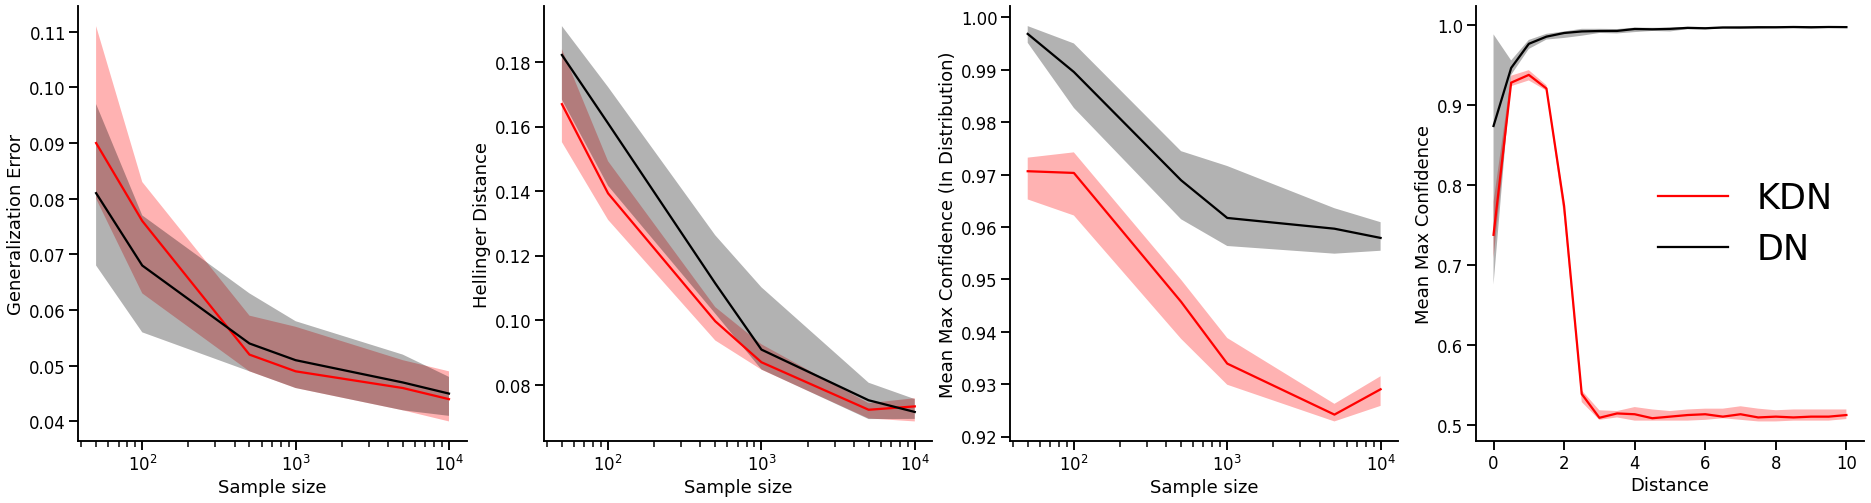

In [29]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,4, figsize=(32,8))

ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)




ax[2].plot(sample_size, df['mmcIn_kdn_med'], c="r", label='KDN')
ax[2].plot(sample_size, df['mmcIn_dn_med'], c="k", label='DN')

ax[2].fill_between(sample_size, df['mmcIn_kdn_25'], df['mmcIn_kdn_75'], facecolor='r', alpha=.3)
ax[2].fill_between(sample_size, df['mmcIn_dn_25'], df['mmcIn_dn_75'], facecolor='k', alpha=.3)

ax[2].set_xscale('log')
ax[2].set_xlabel('Sample size')
ax[2].set_ylabel('Mean Max Confidence (In Distribution)')

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[3].plot(r, df_out['mmcOut_kdn_med'], c="r", label='KDN')
ax[3].plot(r, df_out['mmcOut_dn_med'], c="k", label='DN')

ax[3].fill_between(r, df_out['mmcOut_kdn_25'], df_out['mmcOut_kdn_75'], facecolor='r', alpha=.3)
ax[3].fill_between(r, df_out['mmcOut_dn_25'], df_out['mmcOut_dn_75'], facecolor='k', alpha=.3)

#ax[3].set_xscale('log')
ax[3].set_xlabel('Distance')
ax[3].set_ylabel('Mean Max Confidence')

ax[3].legend(fontsize=35, frameon=False)

right_side = ax[3].spines["right"]
right_side.set_visible(False)
top_side = ax[3].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [30]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [31]:
sample = 10000
reps = 10
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_dn = []
roc_kdn = []

fpr_dn = []
fpr_kdn = []
reps_list = []

for ii in range(reps):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    X_ood = generate_ood_samples(n_test)

    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)

    dn_in_conf = np.max(model_kdn.network.predict(X_test), axis=1)
    dn_out_conf = np.max(model_kdn.network.predict(X_ood), axis=1)
    dn_conf = np.hstack((dn_in_conf, dn_out_conf))
    roc_dn.append(
        roc_auc_score(true_labels, dn_conf)
    )
    fpr_dn.append(
        fpr_at_95_tpr(dn_in_conf, dn_out_conf)
    )
    
    

    kdn_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
    kdn_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
    kdn_conf = np.hstack((kdn_in_conf, kdn_out_conf))
    roc_kdn.append(
        roc_auc_score(true_labels, kdn_conf)
    )
    fpr_kdn.append(
        fpr_at_95_tpr(kdn_in_conf, kdn_out_conf)
    )

    reps_list.append(ii)

2023-02-25 04:09:06.219497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Epoch 41: early stopping

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

 1/32 [..............................] - ETA: 0s

2023-02-25 04:18:05.026530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 04:18:05.841539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 04:26:42.752650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 04:26:43.535553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 04:35:47.080768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 04:35:47.872018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 04:44:42.631625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 04:44:43.433590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 04:53:46.777121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 04:53:47.557274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 05:02:49.368106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 05:02:50.160790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 15: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 05:11:15.888670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 05:11:16.675149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 21: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 05:19:49.837247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 05:19:50.626819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
29/32 [==========================>...] - ETA: 0s

2023-02-25 05:28:49.792958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 05:28:50.597400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 05:37:36.245144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 05:37:37.046491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 05:46:37.023587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 05:46:37.822236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 05:55:43.174416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 05:55:43.967997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 67: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-25 06:04:51.161330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 06:04:51.957415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-25 06:13:50.379723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 06:13:51.195108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 102: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 06:23:41.901957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 06:23:42.682084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-25 06:32:54.726040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 06:32:55.545651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
27/32 [========================>.....] - ETA: 0s

2023-02-25 06:41:52.704880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 06:41:53.505730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 127: early stopping
32/32 [==============================] - 0s 2ms/step


2023-02-25 06:52:03.271504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-25 06:52:04.049376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
27/32 [========================>.....] - ETA: 0s

2023-02-25 07:00:50.231495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 07:00:51.024380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 77: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-25 07:10:09.978813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 07:10:10.770708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 0s

2023-02-25 07:22:23.471379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 07:22:24.350974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 88: early stopping
28/32 [=========================>....] - ETA: 0s

2023-02-25 07:31:45.973577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 07:31:46.745776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 35: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-25 07:40:37.966235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 07:40:38.776469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-25 07:49:32.666851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 07:49:33.502214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 24: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-25 07:58:16.386381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 07:58:17.206483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-25 08:07:48.571701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 08:07:49.446317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 70: early stopping
 1/32 [..............................] - ETA: 0s

2023-02-25 08:17:17.603439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-02-25 08:17:18.452367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping


KeyboardInterrupt: 

In [ ]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdn), np.std(roc_kdn)))
print("DN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_dn), np.std(roc_dn)))

In [ ]:
# FPR@95
print("KDN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdn), np.std(fpr_kdn)))
print("DN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_dn), np.std(fpr_dn)))